In [1]:
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms, datasets
import time
import torch.nn.functional as F
from scipy.interpolate import interp1d
import pandas as pd
from collections import deque
import numpy as np
import cv2
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle
import timm
from sklearn.metrics import roc_curve, auc
import os
data = pd.read_csv("TNPC-Ⅲ.csv",sep=",", engine='python', encoding='utf-8')

In [2]:
all_names = []
path_label=[]
for h in range(0,len(data["ID"])):
    file_dir=data["ID"][h]
    print(file_dir)
    all_names.append(file_dir)
    path_label.append(data["Label"][h])

WFYP011
WFYP055
WFYP060
WFYP001
WFYP002
WFYP003
WFYP004
WFYP009
WFYP010
WFYP012
WFYP013
WFYP014
WFYP015
WFYP020
WFYP021
WFYP023
WFYP030
WFYP032
WFYP034
WFYP043
WFYP045
WFYP046
WFYP047
WFYP051
WFYP053
WFYP054
WFYC3048
WFYC1011
WFYC1012
WFYC1014
WFYC1015
WFYC1016
WFYC1017
WFYC1018
WFYC1019
WFYC1001
WFYC1003
WFYC1004
WFYC1005
WFYC1008
WFYC1009
WFYC2011
WFYC2033
WFYC2044
WFYC2055
WFYC2066
WFYC2069
WFYC2070
WFYC2071
WFYC2001
WFYC2002
WFYC2003
WFYC2004
WFYC2005
WFYC2007
WFYC2009
WFYC2010
WFYC2012
WFYC2013
WFYC2014
WFYC2015
WFYC2016
WFYC2017
WFYC2019
WFYC2023
WFYC2024
WFYC2025
WFYC2026
WFYC2027
WFYC2028
WFYC2029
WFYC2030
WFYC2031
WFYC2032
WFYC2035
WFYC2037
WFYC2038
WFYC2039
WFYC2041
WFYC2043
WFYC2046
WFYC2048
WFYC2050
WFYC2052
WFYC2053
WFYC2054
WFYC2056
WFYC2057
WFYC2059
WFYC2060
WFYC2061
WFYC2062
WFYC2063
WFYC2064
WFYC2065
WFYC2067
WFYC2068
WFYC3011
WFYC3022
WFYC3033
WFYC3044
WFYC3055
WFYC3062
WFYC3063
WFYC3064
WFYC3001
WFYC3002
WFYC3003
WFYC3004
WFYC3005
WFYC3007
WFYC3008
WFYC3009
WFYC3010


In [3]:
all_X_list = all_names                  # all video file names
all_y_list = np.array(path_label)

In [4]:
action_name_path = './UCF101actions.pkl'
save_model_path = "./WH-ESPC_CRNN_ckpt/"
data_path = "./DATAcopd" 
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 768
CNN_embed_dim = 512  
res_size = 320        
dropout_p = 0.2       
RNN_hidden_layers = 1
RNN_hidden_nodes = 64
RNN_FC_dim = 32
k = 3             
epochs = 80      
batch_size = 34
learning_rate = 1e-4
log_interval = 2  
n_embed = 512  
embed_dim = 512
num_heads = 4
num_layers = 2
num_experts = 16  
top_k = 4  
capacity_factor = 1  
alpha = 0.05      

begin_frame, end_frame, skip_frame = 4, 40, 2

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F

class Expert(nn.Module):
    def __init__(self, n_embd, dropout=0.1, hidden_multiplier=4, activation=nn.GELU()):
        super().__init__()
        self.hidden_dim = hidden_multiplier * n_embd
        self.net = nn.Sequential(
            nn.Linear(n_embd, self.hidden_dim),
            activation,
            nn.Linear(self.hidden_dim, n_embd),
            nn.Dropout(dropout)
        )
        self.use_residual = self.hidden_dim == n_embd
        if self.use_residual:
            self.residual_dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.net(x)
        if self.use_residual:
            out = out + self.residual_dropout(x)
        return out

class NoisyTopkRouter(nn.Module):
    def __init__(self, n_embed, num_experts, top_k):
        super(NoisyTopkRouter, self).__init__()
        self.top_k = top_k
        self.topkroute_linear = nn.Linear(n_embed, num_experts)
        self.noise_linear = nn.Linear(n_embed, num_experts)

    def forward(self, mh_output):
        logits = self.topkroute_linear(mh_output)
        noise_logits = self.noise_linear(mh_output)
        noise = torch.randn_like(logits) * F.softplus(noise_logits)
        noisy_logits = logits + noise
        top_k_logits, indices = noisy_logits.topk(self.top_k, dim=-1)
        zeros = torch.full_like(noisy_logits, float('-inf'))
        sparse_logits = zeros.scatter(-1, indices, top_k_logits)
        router_output = F.softmax(sparse_logits, dim=-1)
        return router_output, indices

class DynamicBiasAdjuster:
    def __init__(self, num_experts, alpha=0.1, window_size=3):
        self.num_experts = num_experts
        self.alpha = alpha
        self.window_size = window_size
        self.biases = torch.nn.Parameter(torch.zeros(num_experts), requires_grad=False)
        self.load_history = deque(maxlen=2 * window_size + 1)

    def update(self, load):
        self.load_history.append(load.detach().clone())
        if len(self.load_history) > 0:
            load_list = list(self.load_history)
            load_tensor = torch.stack(load_list)
            avg_load = torch.mean(load_tensor, dim=0)
        else:
            avg_load = torch.zeros_like(load)
        delta = 8 * (F.softsign(avg_load - load))
        #delta = avg_load - load
        delta = delta.to(self.biases.device)
        self.biases.data += self.alpha * delta


    def apply(self, logits):
        if self.biases.device != logits.device:
            self.biases = self.biases.to(logits.device)
        return logits + self.biases




class SparseMoE(nn.Module):
    def __init__(self, n_embed, num_experts, top_k, capacity_factor=1.0, alpha=0.1):
        super(SparseMoE, self).__init__()
        self.router = NoisyTopkRouter(n_embed, num_experts, top_k)
        self.expert_share = Expert(n_embed)
        self.experts = nn.ModuleList([Expert(n_embed) for _ in range(num_experts)])
        self.top_k = top_k
        self.capacity_factor = capacity_factor
        self.num_experts = num_experts
        self.dynamic_bias_adjuster = DynamicBiasAdjuster(num_experts, alpha=alpha, window_size=3)
        #self.dynamic_bias_adjuster = DynamicBiasAdjuster(num_experts, alpha)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        gating_output, indices = self.router(x)
        final_output = torch.zeros_like(x)
        flat_x = x.reshape(-1, x.size(-1))
        flat_gating_output = gating_output.reshape(-1, gating_output.size(-1))

        load = flat_gating_output.sum(dim=0)
        self.dynamic_bias_adjuster.update(load)
        adjusted_logits = self.dynamic_bias_adjuster.apply(self.router.topkroute_linear(flat_x))
        adjusted_gating_output = F.softmax(adjusted_logits, dim=-1)
        adjusted_gating_output = adjusted_gating_output.reshape(batch_size, seq_len, -1)

        top_k_logits, indices = adjusted_gating_output.topk(self.top_k, dim=-1)
        zeros = torch.full_like(adjusted_gating_output, float('-inf'))
        sparse_logits = zeros.scatter(-1, indices, top_k_logits)
        router_output = F.softmax(sparse_logits, dim=-1)

        updates = torch.zeros_like(flat_x)
        expert_output = self.expert_share(flat_x)
        updates += expert_output

        for i, expert in enumerate(self.experts):
            expert_mask = (indices == i).any(dim=-1)
            flat_mask = expert_mask.view(-1)
            selected_indices = torch.nonzero(flat_mask).squeeze(-1)
            limited_indices = selected_indices[:int((batch_size * seq_len * self.top_k / self.num_experts) * self.capacity_factor)]
            if limited_indices.numel() > 0:
                expert_input = flat_x[limited_indices]
                expert_output = expert(expert_input)
                gating_scores = flat_gating_output[limited_indices, i].unsqueeze(1)
                weighted_output = expert_output * gating_scores
                updates.index_add_(0, limited_indices, weighted_output)

        final_output += updates.view(batch_size, seq_len, -1)
        return final_output

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = self.global_avg_pool(x)  
        x = x.squeeze(-1) 
        
        x = self.fc(x)  
        return x

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()
        Q = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        attention_scores = torch.matmul(Q, K.transpose(-1, -2)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_weights, V).transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)
        return self.fc_out(attention_output)

class LayerNorm(nn.Module):
    def __init__(self, embed_dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(embed_dim))
        self.beta = nn.Parameter(torch.zeros(embed_dim))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
class TransformerLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, num_experts=32, top_k=8, capacity_factor=1.0, alpha=0.1):
        super(TransformerLayer, self).__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = LayerNorm(embed_dim)
        self.moe = SparseMoE(n_embed, num_experts, top_k, capacity_factor, alpha)
        self.norm2 = LayerNorm(embed_dim)

    def forward(self, x):
        attn_output = self.self_attn(x)
        x = self.norm1(x + attn_output)
        
        moe_output = self.moe(x)
        x = self.norm2(x + moe_output)
        
        return x
class ImprovedTransformer(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, num_experts, top_k, capacity_factor, alpha):
        super(ImprovedTransformer, self).__init__()
        self.layers = nn.ModuleList([
            TransformerLayer(embed_dim, num_heads, num_experts, top_k, capacity_factor, alpha)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    cnn_encoder, rnn_decoder, Transformer = model
    cnn_encoder.train()
    rnn_decoder.train()
    Transformer.train()

    losses = []
    scores = []
    N_count = 0  
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device).view(-1, )

        N_count += X.size(0)

        optimizer.zero_grad()
        feature = cnn_encoder(X)
        feature = Transformer(feature)
        output,hidden = rnn_decoder(feature)

        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        y_pred = torch.max(output, 1)[1]  
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)        

        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores


def validation(model, device, optimizer, test_loader):
    cnn_encoder, rnn_decoder, ImprovedTransformer = model
    cnn_encoder.eval()
    rnn_decoder.eval()
    Transformer.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    all_y_p = []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device).view(-1, )
            feature = cnn_encoder(X)
            feature = Transformer(feature)
            output,hidden = rnn_decoder(feature)

            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()                 
            y_pred = output.max(1, keepdim=True)[1] 
            all_y.extend(y)
            all_y_pred.extend(y_pred)
            all_y_p.extend(output)

    test_loss /= len(test_loader.dataset)

    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())
    from sklearn.metrics import classification_report
    y_true = all_y.cpu().data.squeeze().numpy()
    y_pred = all_y_pred.cpu().data.squeeze().numpy()
    print(classification_report(y_true, y_pred))
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc, precision_recall_curve
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    y_score = torch.stack(all_y_p).cpu().numpy()
    print("y_true_bin shape:", y_true_bin.shape)
    print("y_score shape:", y_score.shape)
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    colors = ['darkorange', 'blue', 'green']
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        mean_fpr = np.linspace(0, 1, 100)
        tpr_interp = interp1d(fpr, tpr)(mean_fpr)
        plt.plot(mean_fpr, tpr_interp, color=colors[i], lw=2, label=f'Class {i} ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.subplot(122)
    for i in range(3):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        mean_recall = np.linspace(0, 1, 100)
        precision_interp = interp1d(recall[::-1], precision[::-1])(mean_recall)
        plt.plot(mean_recall, precision_interp, color=colors[i], lw=2, label=f'Class {i} PR')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()
    
    print("Epoch {} model saved!".format(epoch + 1))

    return test_loss, test_score

In [9]:
# Detect devices
use_cuda = torch.cuda.is_available()                   
device = torch.device("cuda:0" if use_cuda else "cpu")  

params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 12, 'pin_memory': True} if use_cuda else {'batch_size': batch_size}

In [10]:
import torch.utils.data as data
train_list, test_list, train_label, test_label = train_test_split(all_X_list, all_y_list, test_size=0.2)

transform = transforms.Compose([transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

train_set, valid_set = Dataset_CRNN(data_path, train_list, train_label, selected_frames, transform=transform), \
                       Dataset_CRNN(data_path, test_list, test_label, selected_frames, transform=transform)
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(15),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.Resize([res_size, res_size]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_counts = np.bincount(train_label)
max_count = max(class_counts)

balanced_train_list = []
balanced_train_label = []

for class_idx in range(len(class_counts)):
    class_indices = [i for i, label in enumerate(train_label) if label == class_idx]

    augment_count = max_count - len(class_indices)

    balanced_train_list.extend([train_list[i] for i in class_indices])
    balanced_train_label.extend([class_idx] * len(class_indices))

    if augment_count > 0:
        augment_indices = np.random.choice(class_indices, size=augment_count, replace=True)
        balanced_train_list.extend([train_list[i] for i in augment_indices])
        balanced_train_label.extend([class_idx] * augment_count)

train_set_aug = Dataset_CRNN(data_path, balanced_train_list, balanced_train_label, selected_frames, transform=transform_aug)

train_set_combined = torch.utils.data.ConcatDataset([train_set, train_set_aug])

train_loader = data.DataLoader(train_set_aug, **params)
valid_loader = data.DataLoader(valid_set, **params)

In [13]:
model_name = "caformer_b36.sail_in22k"
cnn_encoder = image_Encoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, name=model_name,
                            drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim, full_number = 768).to(device)
rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_embed_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes,
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=k).to(device)
Transformer = ImprovedTransformer(embed_dim, num_heads, num_layers, num_experts, top_k, capacity_factor, alpha).to(device)

Unexpected keys (head.fc.fc1.weight, head.fc.fc1.bias, head.fc.norm.weight, head.fc.norm.bias) found while loading pretrained weights. This may be expected if model is being adapted.


In [14]:
if torch.cuda.device_count() > 2:
    print("Using", torch.cuda.device_count(), "GPUs!")
    cnn_encoder = nn.DataParallel(cnn_encoder)
    rnn_decoder = nn.DataParallel(rnn_decoder)

    crnn_params = list(cnn_encoder.module.fc1.parameters()) + list(cnn_encoder.module.bn1.parameters()) + \
                  list(cnn_encoder.module.fc2.parameters()) + list(cnn_encoder.module.bn2.parameters()) + \
                  list(cnn_encoder.module.fc3.parameters()) + list(rnn_decoder.parameters())

elif torch.cuda.device_count() == 1:
    print("Using", torch.cuda.device_count(), "GPU!")
    crnn_params = list(cnn_encoder.fc1.parameters()) + list(cnn_encoder.bn1.parameters()) + \
                  list(cnn_encoder.fc2.parameters()) + list(cnn_encoder.bn2.parameters()) + \
                  list(cnn_encoder.fc3.parameters()) + list(rnn_decoder.parameters()) + \
                  list(Transformer.parameters())
optimizer = torch.optim.Adam(crnn_params, lr=learning_rate)
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []

Using 1 GPU!


Train Epoch: 1 [68/321 (20%)]	Loss: 0.937916, Accu: 61.76%
Train Epoch: 1 [136/321 (40%)]	Loss: 0.865184, Accu: 73.53%
Train Epoch: 1 [204/321 (60%)]	Loss: 0.784114, Accu: 85.29%
Train Epoch: 1 [272/321 (80%)]	Loss: 0.805751, Accu: 82.35%
Train Epoch: 1 [321/321 (100%)]	Loss: 0.843502, Accu: 80.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.25      1.00      0.40         4
           2       1.00      0.59      0.74        29

    accuracy                           0.76        49
   macro avg       0.75      0.86      0.71        49
weighted avg       0.94      0.76      0.80        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


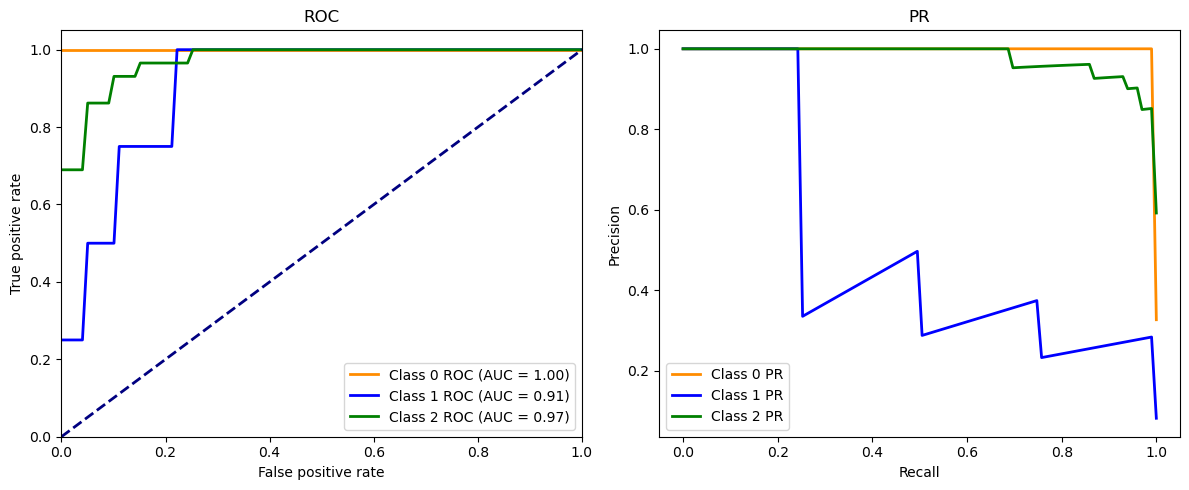

Epoch 1 model saved!
Model saved for epoch 1
Train Epoch: 2 [68/321 (20%)]	Loss: 0.689253, Accu: 94.12%
Train Epoch: 2 [136/321 (40%)]	Loss: 0.674521, Accu: 97.06%
Train Epoch: 2 [204/321 (60%)]	Loss: 0.684345, Accu: 94.12%
Train Epoch: 2 [272/321 (80%)]	Loss: 0.717795, Accu: 88.24%
Train Epoch: 2 [321/321 (100%)]	Loss: 0.663825, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.24      1.00      0.38         4
           2       1.00      0.55      0.71        29

    accuracy                           0.73        49
   macro avg       0.75      0.85      0.70        49
weighted avg       0.94      0.73      0.78        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


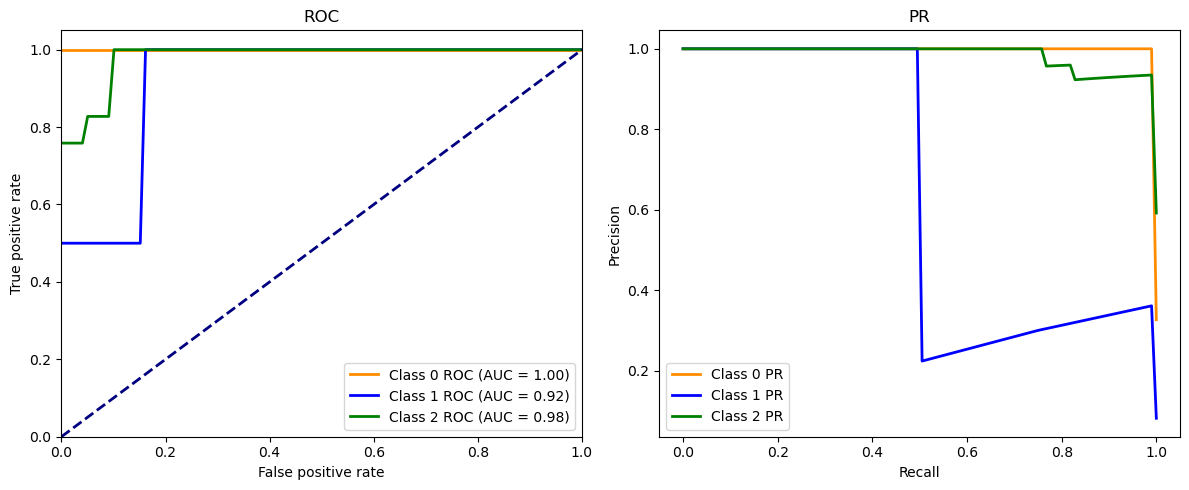

Epoch 2 model saved!
Model saved for epoch 2
Train Epoch: 3 [68/321 (20%)]	Loss: 0.654081, Accu: 100.00%
Train Epoch: 3 [136/321 (40%)]	Loss: 0.702695, Accu: 94.12%
Train Epoch: 3 [204/321 (60%)]	Loss: 0.722304, Accu: 88.24%
Train Epoch: 3 [272/321 (80%)]	Loss: 0.644440, Accu: 97.06%
Train Epoch: 3 [321/321 (100%)]	Loss: 0.766649, Accu: 86.67%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      1.00      0.50         4
           2       1.00      0.72      0.84        29

    accuracy                           0.84        49
   macro avg       0.78      0.91      0.78        49
weighted avg       0.95      0.84      0.86        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


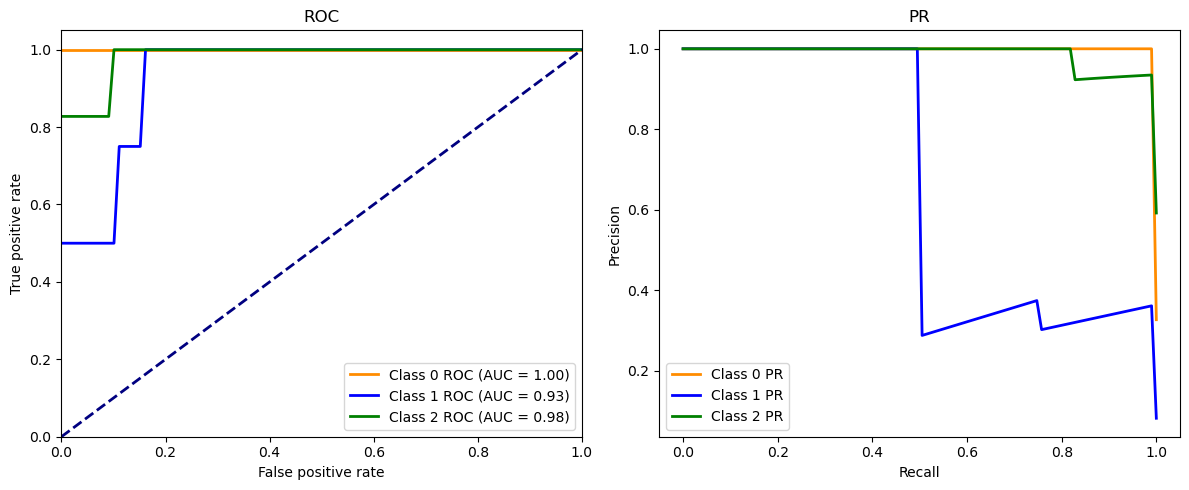

Epoch 3 model saved!
Model saved for epoch 3
Train Epoch: 4 [68/321 (20%)]	Loss: 0.629824, Accu: 100.00%
Train Epoch: 4 [136/321 (40%)]	Loss: 0.707951, Accu: 88.24%
Train Epoch: 4 [204/321 (60%)]	Loss: 0.675125, Accu: 94.12%
Train Epoch: 4 [272/321 (80%)]	Loss: 0.644636, Accu: 97.06%
Train Epoch: 4 [321/321 (100%)]	Loss: 0.647575, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.29      0.50      0.36         4
           2       0.92      0.83      0.87        29

    accuracy                           0.86        49
   macro avg       0.74      0.78      0.75        49
weighted avg       0.90      0.86      0.87        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


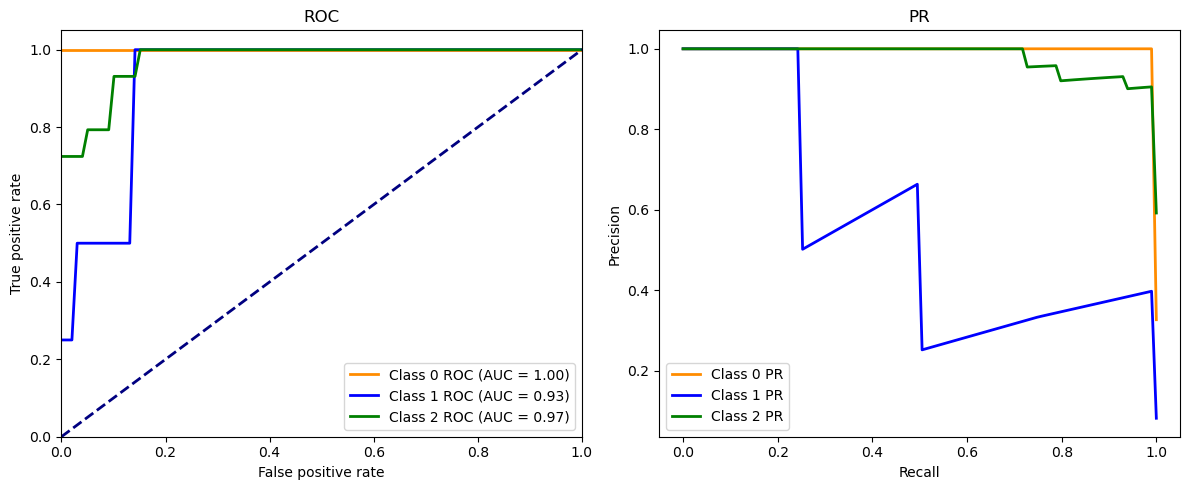

Epoch 4 model saved!
Model saved for epoch 4
Train Epoch: 5 [68/321 (20%)]	Loss: 0.649865, Accu: 94.12%
Train Epoch: 5 [136/321 (40%)]	Loss: 0.629420, Accu: 100.00%
Train Epoch: 5 [204/321 (60%)]	Loss: 0.677661, Accu: 94.12%
Train Epoch: 5 [272/321 (80%)]	Loss: 0.626579, Accu: 97.06%
Train Epoch: 5 [321/321 (100%)]	Loss: 0.669163, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.50      0.40         4
           2       0.93      0.86      0.89        29

    accuracy                           0.88        49
   macro avg       0.75      0.79      0.76        49
weighted avg       0.90      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


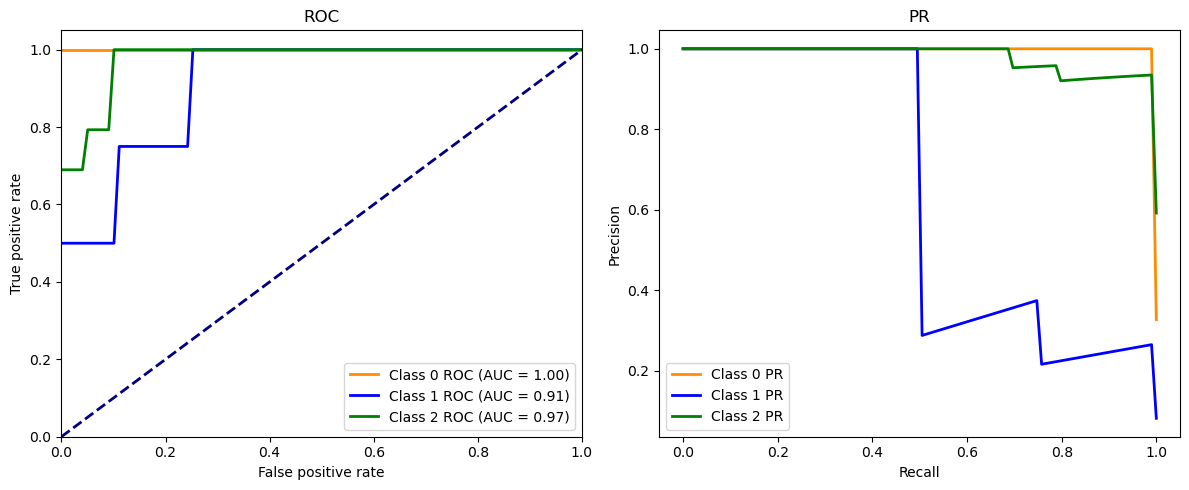

Epoch 5 model saved!
Model saved for epoch 5
Train Epoch: 6 [68/321 (20%)]	Loss: 0.626002, Accu: 100.00%
Train Epoch: 6 [136/321 (40%)]	Loss: 0.638958, Accu: 94.12%
Train Epoch: 6 [204/321 (60%)]	Loss: 0.665141, Accu: 91.18%
Train Epoch: 6 [272/321 (80%)]	Loss: 0.630589, Accu: 97.06%
Train Epoch: 6 [321/321 (100%)]	Loss: 0.608599, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.31      1.00      0.47         4
           2       1.00      0.69      0.82        29

    accuracy                           0.82        49
   macro avg       0.77      0.90      0.76        49
weighted avg       0.94      0.82      0.85        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


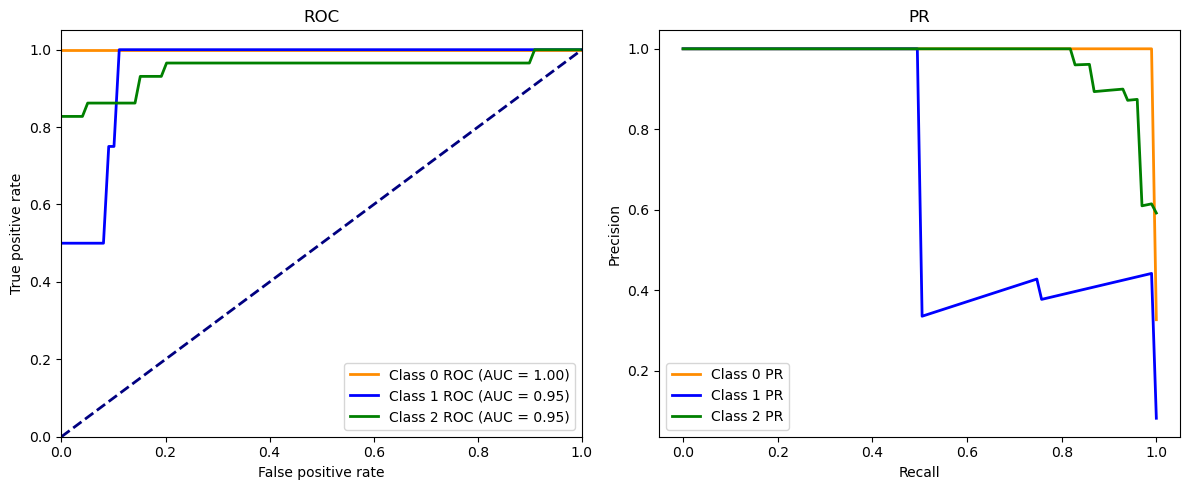

Epoch 6 model saved!
Model saved for epoch 6
Train Epoch: 7 [68/321 (20%)]	Loss: 0.647225, Accu: 94.12%
Train Epoch: 7 [136/321 (40%)]	Loss: 0.621792, Accu: 100.00%
Train Epoch: 7 [204/321 (60%)]	Loss: 0.617521, Accu: 97.06%
Train Epoch: 7 [272/321 (80%)]	Loss: 0.610386, Accu: 100.00%
Train Epoch: 7 [321/321 (100%)]	Loss: 0.647335, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.50      0.40         4
           2       0.93      0.86      0.89        29

    accuracy                           0.88        49
   macro avg       0.75      0.79      0.76        49
weighted avg       0.90      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


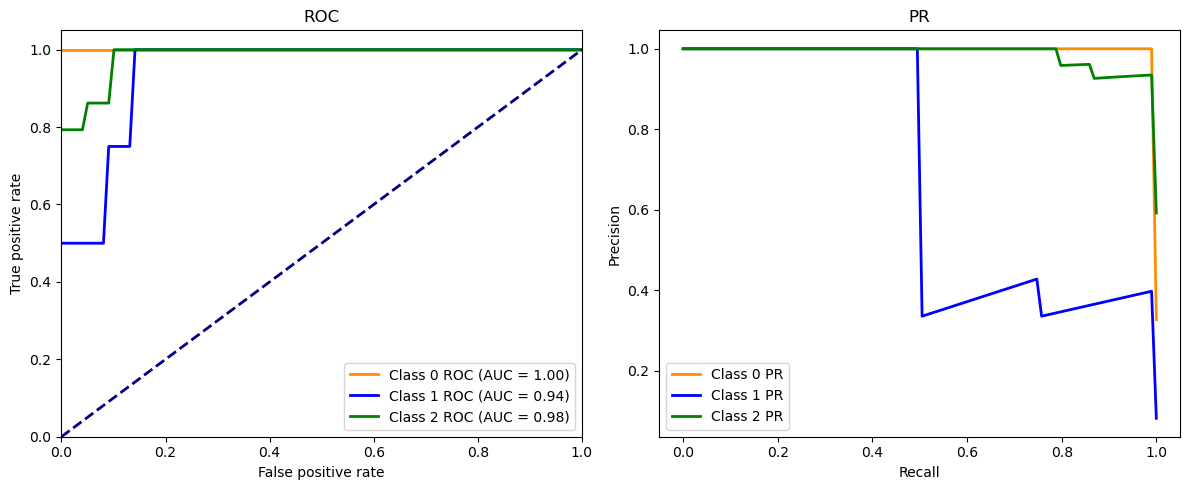

Epoch 7 model saved!
Model saved for epoch 7
Train Epoch: 8 [68/321 (20%)]	Loss: 0.637557, Accu: 97.06%
Train Epoch: 8 [136/321 (40%)]	Loss: 0.627530, Accu: 100.00%
Train Epoch: 8 [204/321 (60%)]	Loss: 0.599286, Accu: 100.00%
Train Epoch: 8 [272/321 (80%)]	Loss: 0.596900, Accu: 100.00%
Train Epoch: 8 [321/321 (100%)]	Loss: 0.598601, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.29      0.50      0.36         4
           2       0.92      0.83      0.87        29

    accuracy                           0.86        49
   macro avg       0.74      0.78      0.75        49
weighted avg       0.90      0.86      0.87        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


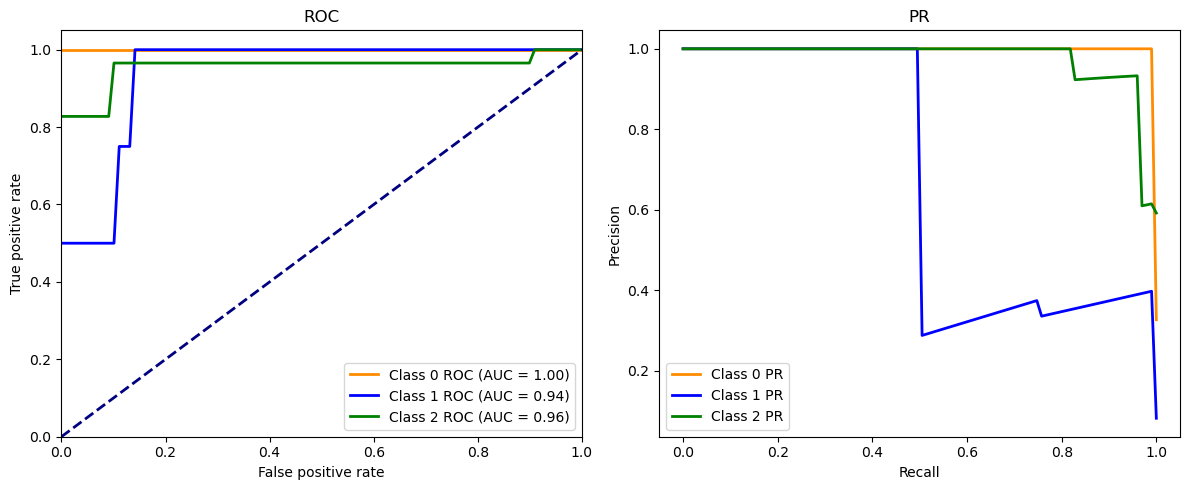

Epoch 8 model saved!
Model saved for epoch 8
Train Epoch: 9 [68/321 (20%)]	Loss: 0.604583, Accu: 100.00%
Train Epoch: 9 [136/321 (40%)]	Loss: 0.599985, Accu: 97.06%
Train Epoch: 9 [204/321 (60%)]	Loss: 0.598904, Accu: 100.00%
Train Epoch: 9 [272/321 (80%)]	Loss: 0.592440, Accu: 100.00%
Train Epoch: 9 [321/321 (100%)]	Loss: 0.594953, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.60      0.75      0.67         4
           2       0.96      0.93      0.95        29

    accuracy                           0.94        49
   macro avg       0.85      0.89      0.87        49
weighted avg       0.95      0.94      0.94        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


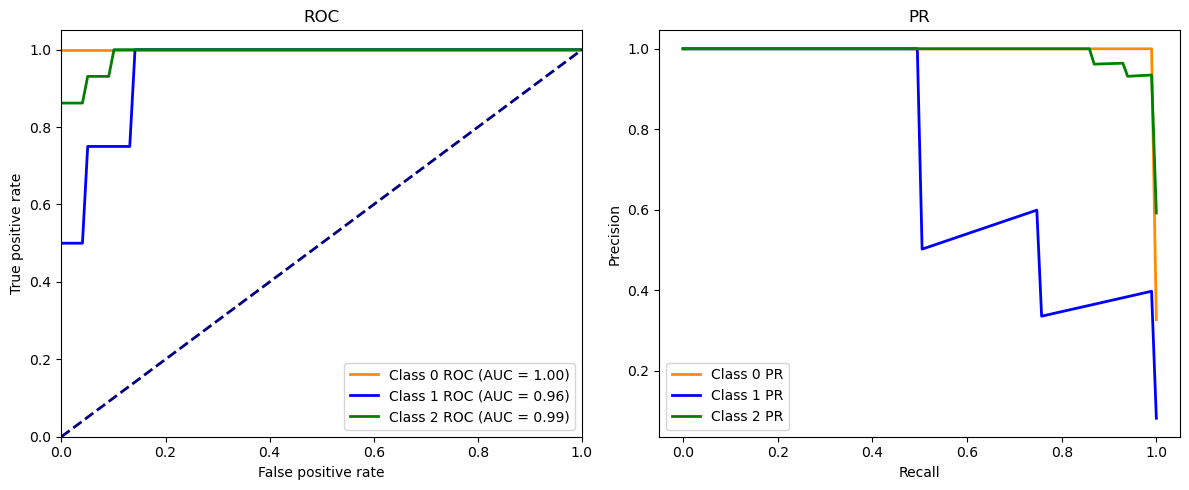

Epoch 9 model saved!
Model saved for epoch 9
Train Epoch: 10 [68/321 (20%)]	Loss: 0.594074, Accu: 100.00%
Train Epoch: 10 [136/321 (40%)]	Loss: 0.607077, Accu: 100.00%
Train Epoch: 10 [204/321 (60%)]	Loss: 0.608416, Accu: 100.00%
Train Epoch: 10 [272/321 (80%)]	Loss: 0.642791, Accu: 94.12%
Train Epoch: 10 [321/321 (100%)]	Loss: 0.608216, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.31      1.00      0.47         4
           2       1.00      0.69      0.82        29

    accuracy                           0.82        49
   macro avg       0.77      0.90      0.76        49
weighted avg       0.94      0.82      0.85        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


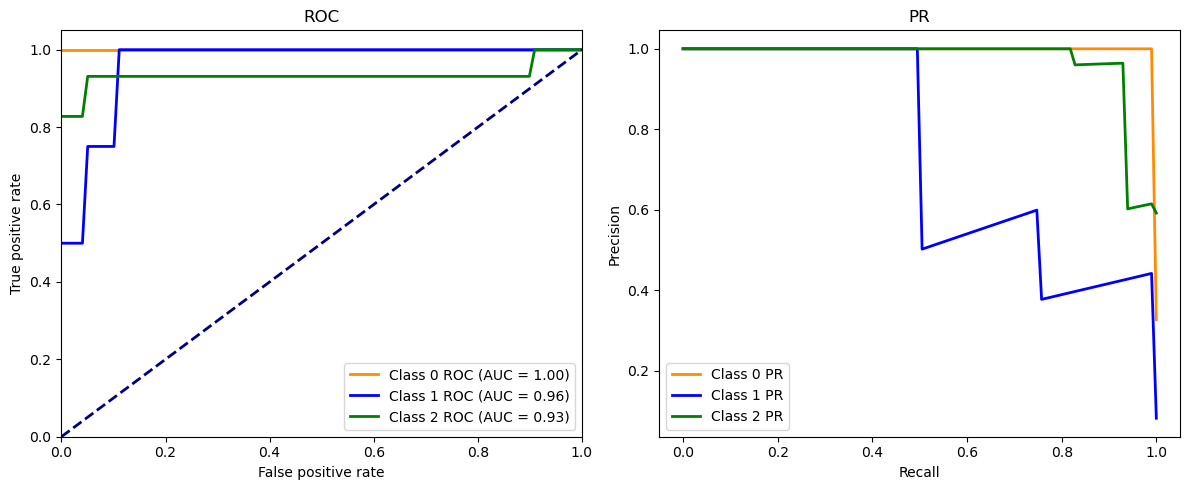

Epoch 10 model saved!
Model saved for epoch 10
Train Epoch: 11 [68/321 (20%)]	Loss: 0.587412, Accu: 100.00%
Train Epoch: 11 [136/321 (40%)]	Loss: 0.607896, Accu: 97.06%
Train Epoch: 11 [204/321 (60%)]	Loss: 0.603281, Accu: 100.00%
Train Epoch: 11 [272/321 (80%)]	Loss: 0.589326, Accu: 100.00%
Train Epoch: 11 [321/321 (100%)]	Loss: 0.600165, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


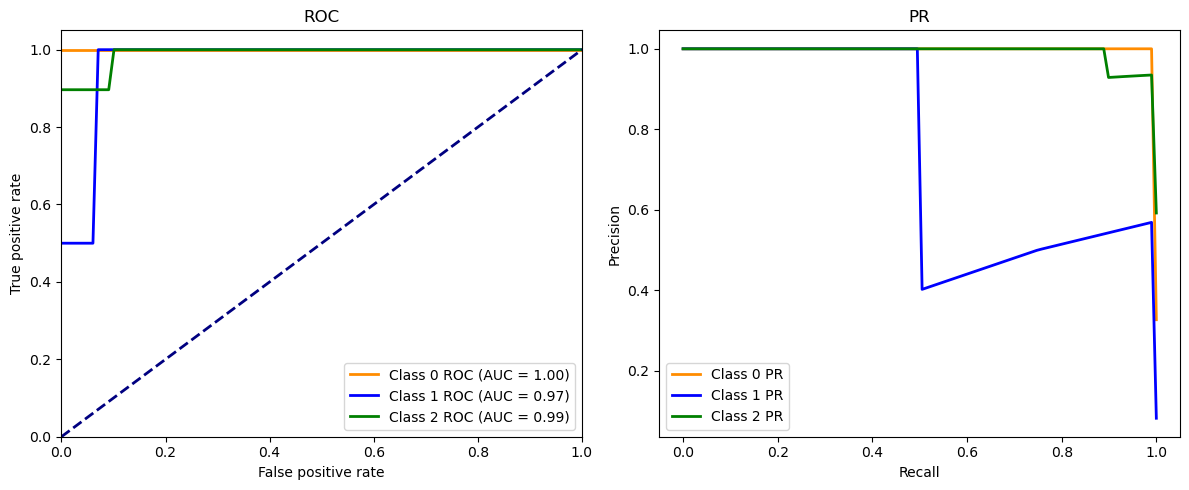

Epoch 11 model saved!
Model saved for epoch 11
Train Epoch: 12 [68/321 (20%)]	Loss: 0.588337, Accu: 100.00%
Train Epoch: 12 [136/321 (40%)]	Loss: 0.581748, Accu: 100.00%
Train Epoch: 12 [204/321 (60%)]	Loss: 0.603236, Accu: 97.06%
Train Epoch: 12 [272/321 (80%)]	Loss: 0.612759, Accu: 97.06%
Train Epoch: 12 [321/321 (100%)]	Loss: 0.652302, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.67      0.50      0.57         4
           2       0.93      0.97      0.95        29

    accuracy                           0.94        49
   macro avg       0.87      0.82      0.84        49
weighted avg       0.93      0.94      0.93        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


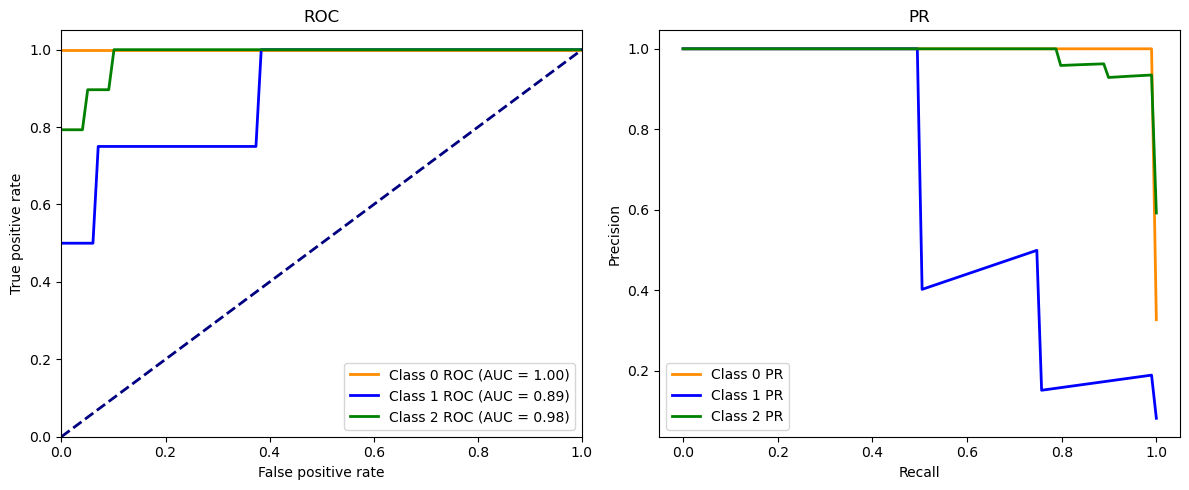

Epoch 12 model saved!
Model saved for epoch 12
Train Epoch: 13 [68/321 (20%)]	Loss: 0.582878, Accu: 100.00%
Train Epoch: 13 [136/321 (40%)]	Loss: 0.585540, Accu: 100.00%
Train Epoch: 13 [204/321 (60%)]	Loss: 0.595651, Accu: 100.00%
Train Epoch: 13 [272/321 (80%)]	Loss: 0.631670, Accu: 100.00%
Train Epoch: 13 [321/321 (100%)]	Loss: 0.748953, Accu: 86.67%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.50      0.67         4
           2       0.94      1.00      0.97        29

    accuracy                           0.96        49
   macro avg       0.98      0.83      0.88        49
weighted avg       0.96      0.96      0.95        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


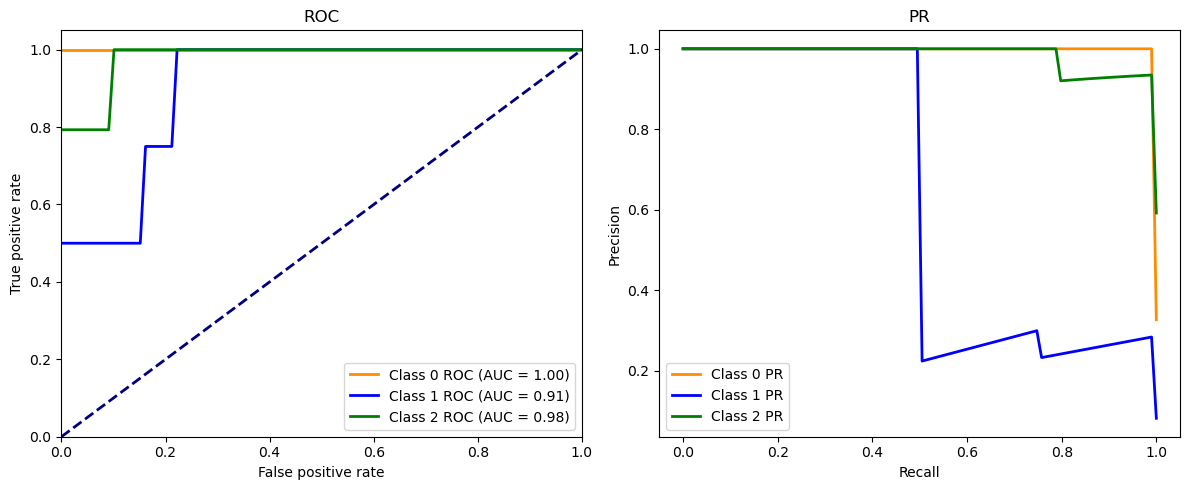

Epoch 13 model saved!
Model saved for epoch 13
Train Epoch: 14 [68/321 (20%)]	Loss: 0.601815, Accu: 100.00%
Train Epoch: 14 [136/321 (40%)]	Loss: 0.583610, Accu: 100.00%
Train Epoch: 14 [204/321 (60%)]	Loss: 0.609110, Accu: 100.00%
Train Epoch: 14 [272/321 (80%)]	Loss: 0.579021, Accu: 100.00%
Train Epoch: 14 [321/321 (100%)]	Loss: 0.637165, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.50      0.50      0.50         4
           2       0.93      0.93      0.93        29

    accuracy                           0.92        49
   macro avg       0.81      0.81      0.81        49
weighted avg       0.92      0.92      0.92        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


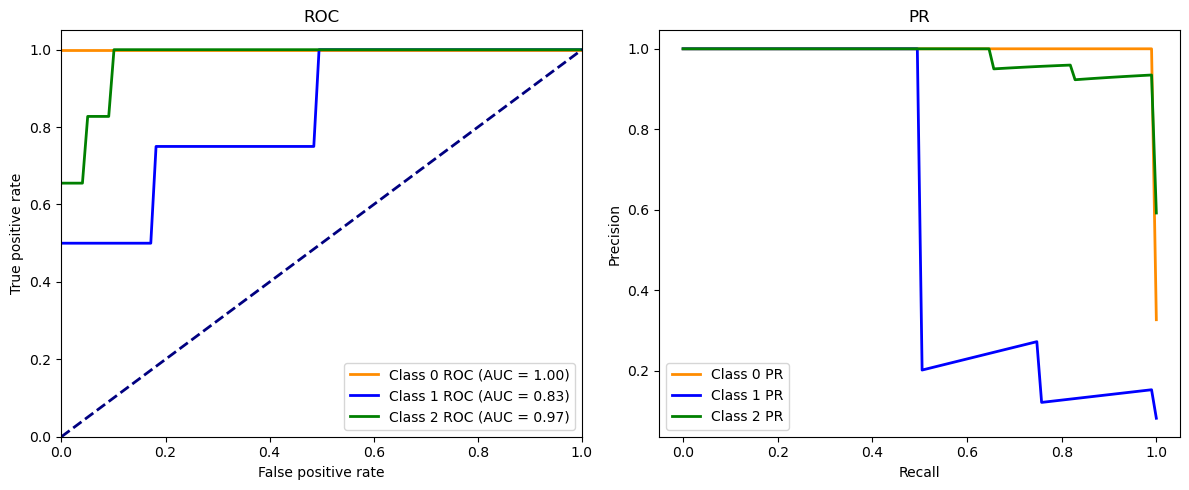

Epoch 14 model saved!
Model saved for epoch 14
Train Epoch: 15 [68/321 (20%)]	Loss: 0.592145, Accu: 100.00%
Train Epoch: 15 [136/321 (40%)]	Loss: 0.596371, Accu: 100.00%
Train Epoch: 15 [204/321 (60%)]	Loss: 0.621852, Accu: 97.06%
Train Epoch: 15 [272/321 (80%)]	Loss: 0.592427, Accu: 100.00%
Train Epoch: 15 [321/321 (100%)]	Loss: 0.627726, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.43      0.75      0.55         4
           2       0.96      0.86      0.91        29

    accuracy                           0.90        49
   macro avg       0.80      0.87      0.82        49
weighted avg       0.93      0.90      0.91        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


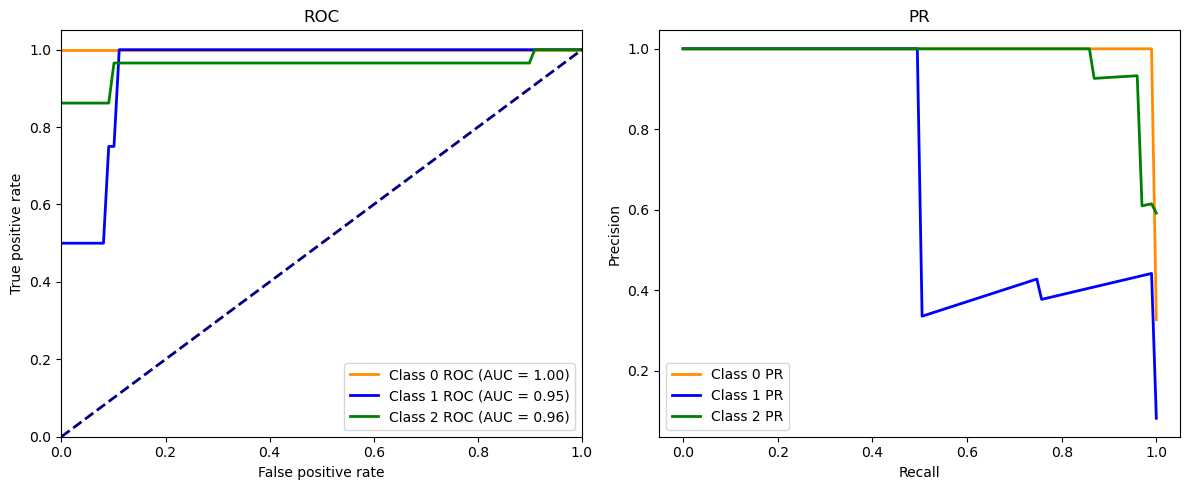

Epoch 15 model saved!
Model saved for epoch 15
Train Epoch: 16 [68/321 (20%)]	Loss: 0.577254, Accu: 100.00%
Train Epoch: 16 [136/321 (40%)]	Loss: 0.580374, Accu: 100.00%
Train Epoch: 16 [204/321 (60%)]	Loss: 0.586851, Accu: 100.00%
Train Epoch: 16 [272/321 (80%)]	Loss: 0.614879, Accu: 97.06%
Train Epoch: 16 [321/321 (100%)]	Loss: 0.581616, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.38      0.75      0.50         4
           2       0.96      0.83      0.89        29

    accuracy                           0.88        49
   macro avg       0.78      0.86      0.80        49
weighted avg       0.93      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


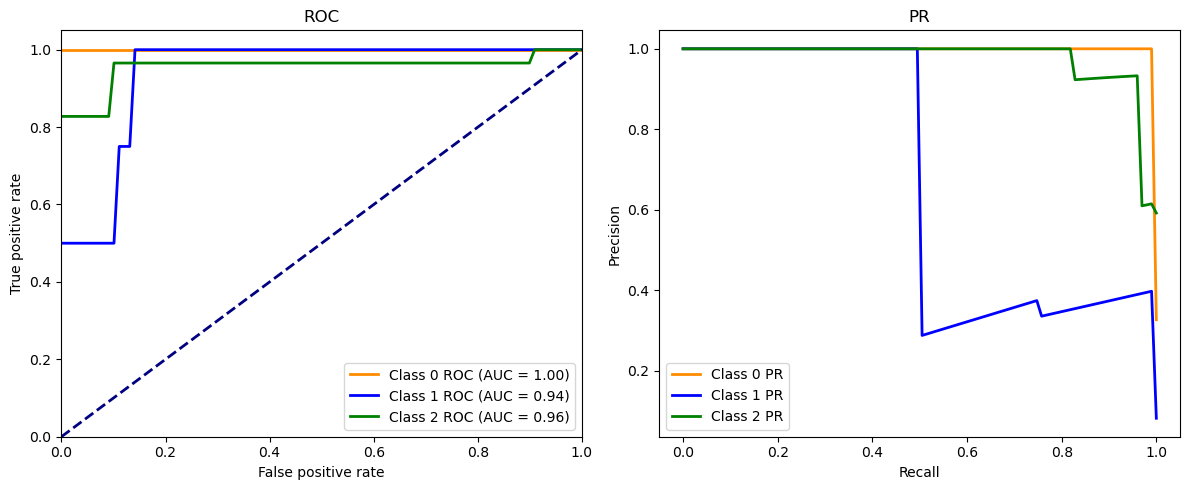

Epoch 16 model saved!
Model saved for epoch 16
Train Epoch: 17 [68/321 (20%)]	Loss: 0.583006, Accu: 100.00%
Train Epoch: 17 [136/321 (40%)]	Loss: 0.607180, Accu: 97.06%
Train Epoch: 17 [204/321 (60%)]	Loss: 0.610237, Accu: 97.06%
Train Epoch: 17 [272/321 (80%)]	Loss: 0.579180, Accu: 100.00%
Train Epoch: 17 [321/321 (100%)]	Loss: 0.618159, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.67      0.50      0.57         4
           2       0.93      0.97      0.95        29

    accuracy                           0.94        49
   macro avg       0.87      0.82      0.84        49
weighted avg       0.93      0.94      0.93        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


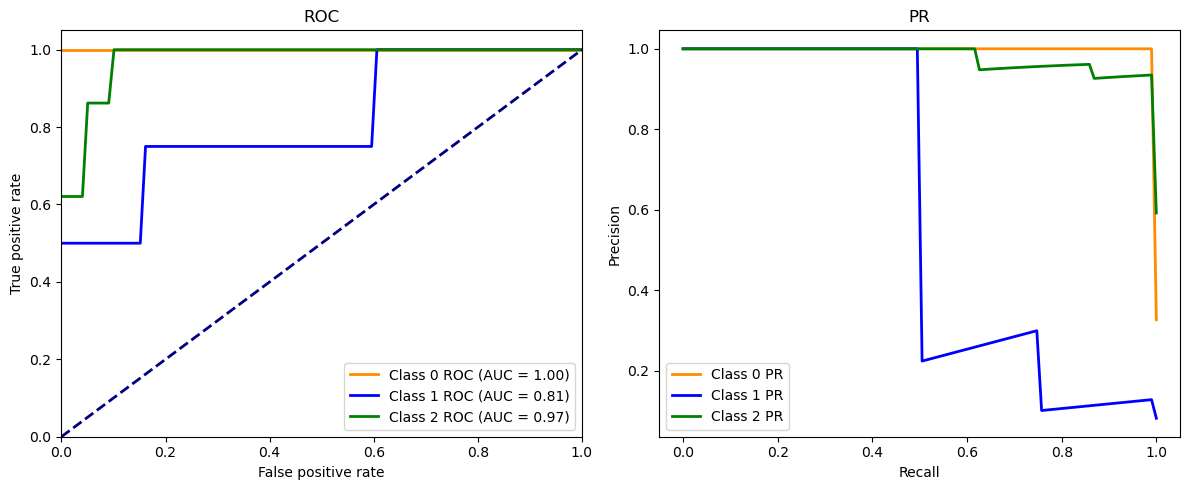

Epoch 17 model saved!
Model saved for epoch 17
Train Epoch: 18 [68/321 (20%)]	Loss: 0.580559, Accu: 100.00%
Train Epoch: 18 [136/321 (40%)]	Loss: 0.579148, Accu: 100.00%
Train Epoch: 18 [204/321 (60%)]	Loss: 0.584728, Accu: 100.00%
Train Epoch: 18 [272/321 (80%)]	Loss: 0.579246, Accu: 100.00%
Train Epoch: 18 [321/321 (100%)]	Loss: 0.578931, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.75      0.46         4
           2       0.96      0.79      0.87        29

    accuracy                           0.86        49
   macro avg       0.76      0.85      0.78        49
weighted avg       0.92      0.86      0.88        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


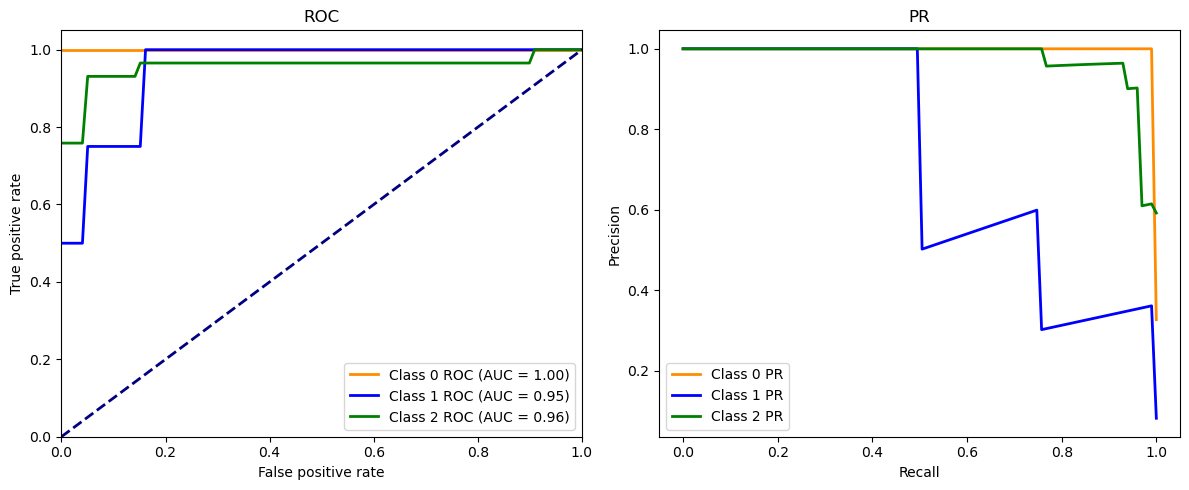

Epoch 18 model saved!
Model saved for epoch 18
Train Epoch: 19 [68/321 (20%)]	Loss: 0.575242, Accu: 100.00%
Train Epoch: 19 [136/321 (40%)]	Loss: 0.610016, Accu: 97.06%
Train Epoch: 19 [204/321 (60%)]	Loss: 0.583158, Accu: 100.00%
Train Epoch: 19 [272/321 (80%)]	Loss: 0.623074, Accu: 94.12%
Train Epoch: 19 [321/321 (100%)]	Loss: 0.583604, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.50      0.75      0.60         4
           2       0.96      0.90      0.93        29

    accuracy                           0.92        49
   macro avg       0.82      0.88      0.84        49
weighted avg       0.94      0.92      0.93        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


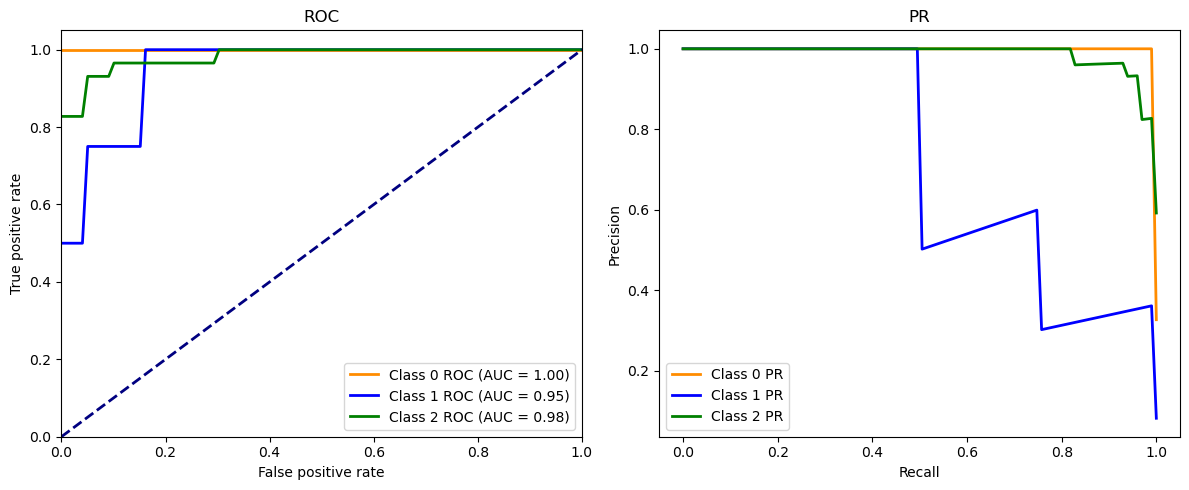

Epoch 19 model saved!
Model saved for epoch 19
Train Epoch: 20 [68/321 (20%)]	Loss: 0.577547, Accu: 100.00%
Train Epoch: 20 [136/321 (40%)]	Loss: 0.573012, Accu: 100.00%
Train Epoch: 20 [204/321 (60%)]	Loss: 0.575854, Accu: 100.00%
Train Epoch: 20 [272/321 (80%)]	Loss: 0.586195, Accu: 100.00%
Train Epoch: 20 [321/321 (100%)]	Loss: 0.656783, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.67      0.50      0.57         4
           2       0.93      0.97      0.95        29

    accuracy                           0.94        49
   macro avg       0.87      0.82      0.84        49
weighted avg       0.93      0.94      0.93        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


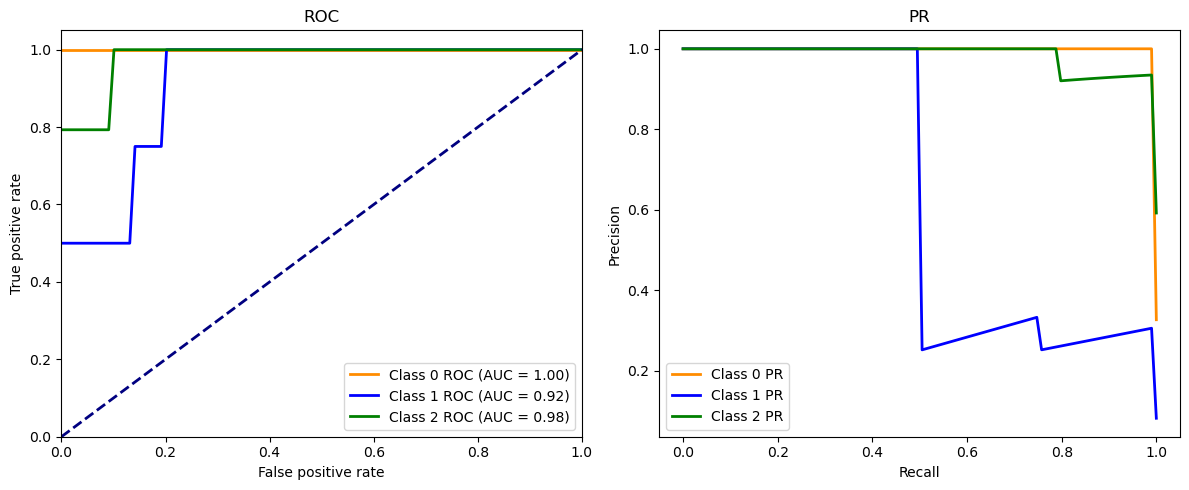

Epoch 20 model saved!
Model saved for epoch 20
Train Epoch: 21 [68/321 (20%)]	Loss: 0.594216, Accu: 97.06%
Train Epoch: 21 [136/321 (40%)]	Loss: 0.580529, Accu: 100.00%
Train Epoch: 21 [204/321 (60%)]	Loss: 0.575262, Accu: 100.00%
Train Epoch: 21 [272/321 (80%)]	Loss: 0.579270, Accu: 100.00%
Train Epoch: 21 [321/321 (100%)]	Loss: 0.610037, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.75      0.46         4
           2       0.96      0.79      0.87        29

    accuracy                           0.86        49
   macro avg       0.76      0.85      0.78        49
weighted avg       0.92      0.86      0.88        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


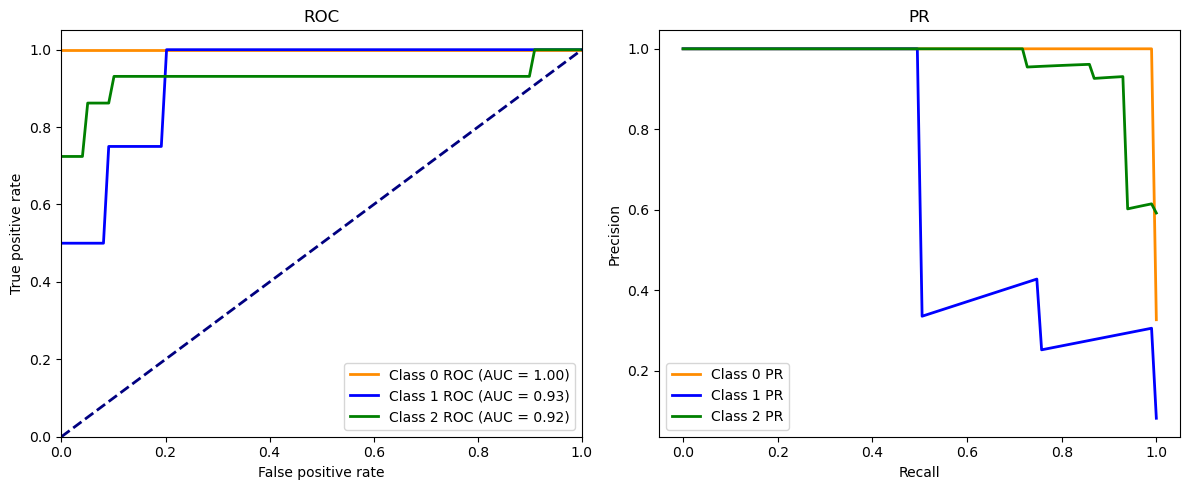

Epoch 21 model saved!
Model saved for epoch 21
Train Epoch: 22 [68/321 (20%)]	Loss: 0.574574, Accu: 100.00%
Train Epoch: 22 [136/321 (40%)]	Loss: 0.576484, Accu: 100.00%
Train Epoch: 22 [204/321 (60%)]	Loss: 0.573945, Accu: 100.00%
Train Epoch: 22 [272/321 (80%)]	Loss: 0.587573, Accu: 100.00%
Train Epoch: 22 [321/321 (100%)]	Loss: 0.569624, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


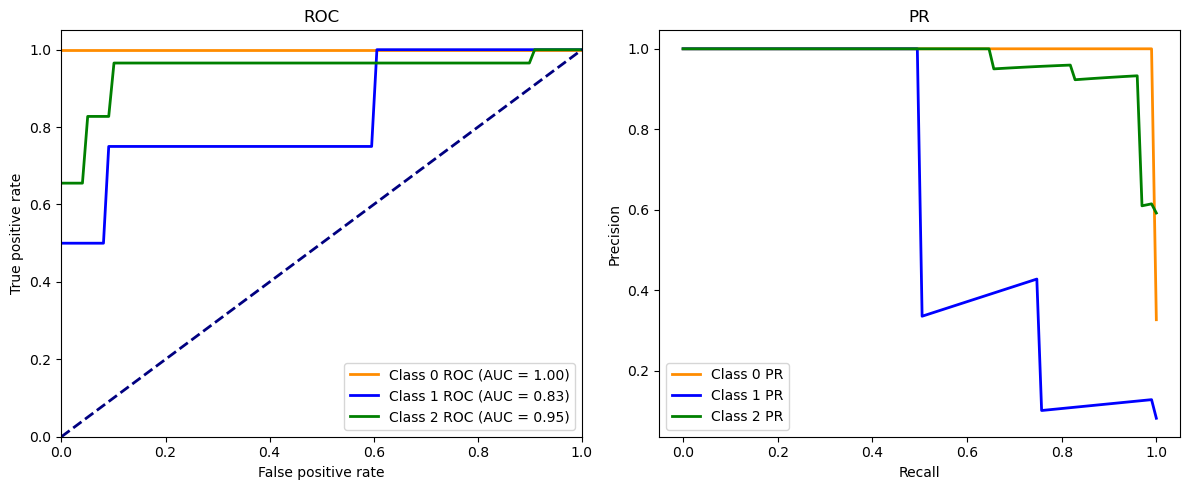

Epoch 22 model saved!
Model saved for epoch 22
Train Epoch: 23 [68/321 (20%)]	Loss: 0.573427, Accu: 100.00%
Train Epoch: 23 [136/321 (40%)]	Loss: 0.601486, Accu: 97.06%
Train Epoch: 23 [204/321 (60%)]	Loss: 0.573794, Accu: 100.00%
Train Epoch: 23 [272/321 (80%)]	Loss: 0.582966, Accu: 100.00%
Train Epoch: 23 [321/321 (100%)]	Loss: 0.581181, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.50      0.40         4
           2       0.93      0.86      0.89        29

    accuracy                           0.88        49
   macro avg       0.75      0.79      0.76        49
weighted avg       0.90      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


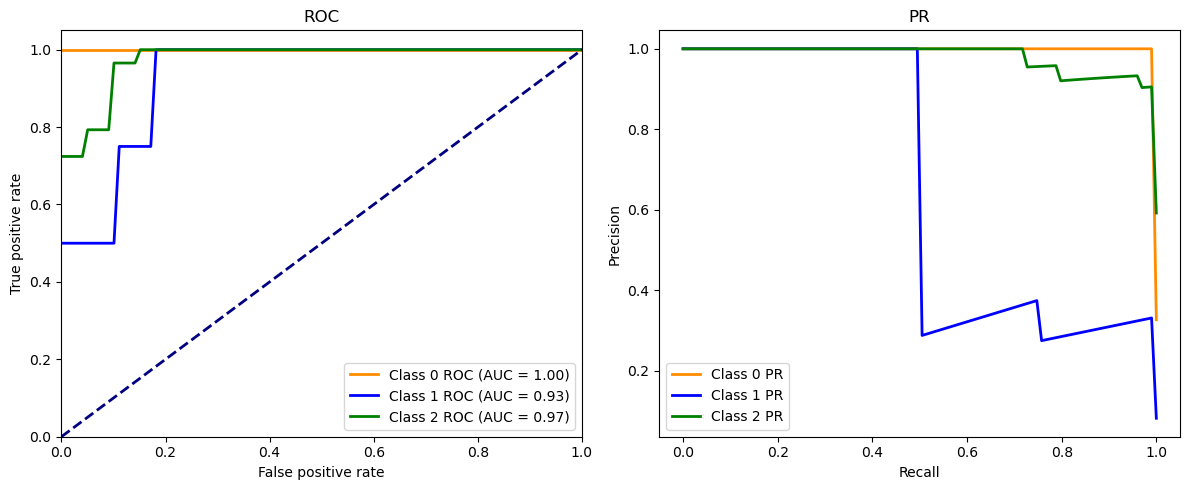

Epoch 23 model saved!
Model saved for epoch 23
Train Epoch: 24 [68/321 (20%)]	Loss: 0.578001, Accu: 100.00%
Train Epoch: 24 [136/321 (40%)]	Loss: 0.574788, Accu: 100.00%
Train Epoch: 24 [204/321 (60%)]	Loss: 0.588405, Accu: 100.00%
Train Epoch: 24 [272/321 (80%)]	Loss: 0.587527, Accu: 100.00%
Train Epoch: 24 [321/321 (100%)]	Loss: 0.591849, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


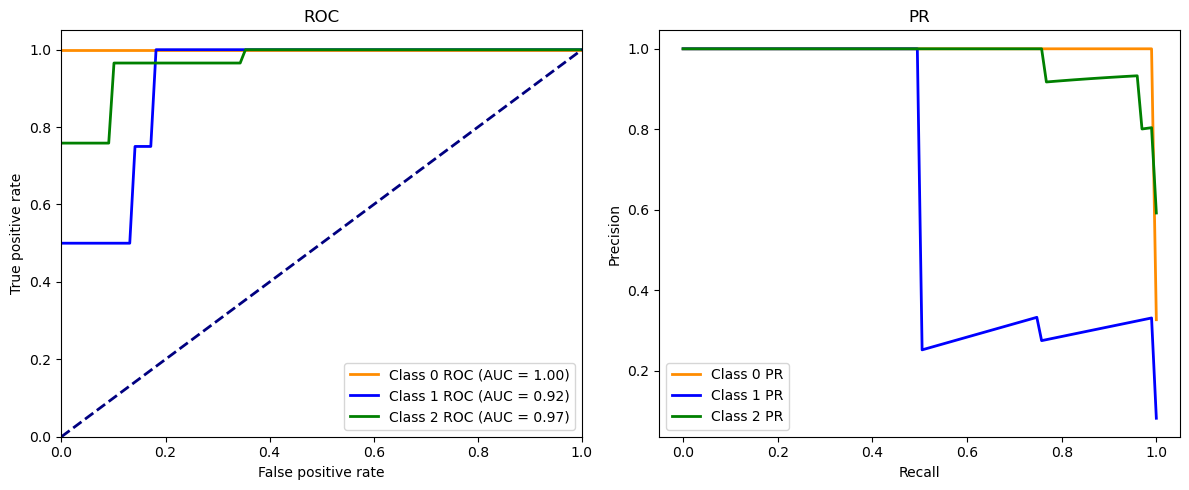

Epoch 24 model saved!
Model saved for epoch 24
Train Epoch: 25 [68/321 (20%)]	Loss: 0.570997, Accu: 100.00%
Train Epoch: 25 [136/321 (40%)]	Loss: 0.579057, Accu: 100.00%
Train Epoch: 25 [204/321 (60%)]	Loss: 0.598172, Accu: 97.06%
Train Epoch: 25 [272/321 (80%)]	Loss: 0.601849, Accu: 100.00%
Train Epoch: 25 [321/321 (100%)]	Loss: 0.582491, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.50      0.40         4
           2       0.93      0.86      0.89        29

    accuracy                           0.88        49
   macro avg       0.75      0.79      0.76        49
weighted avg       0.90      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


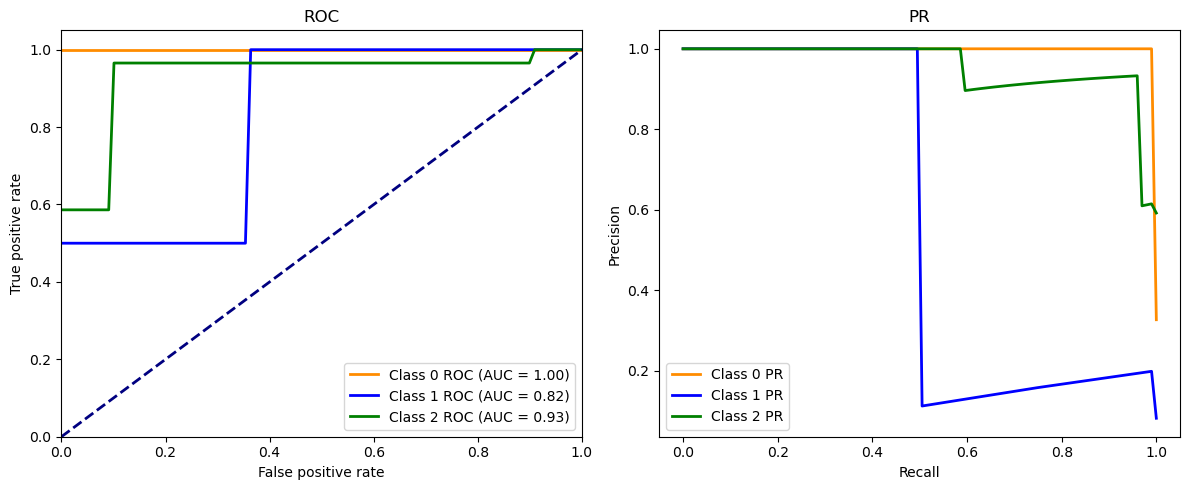

Epoch 25 model saved!
Model saved for epoch 25
Train Epoch: 26 [68/321 (20%)]	Loss: 0.599308, Accu: 97.06%
Train Epoch: 26 [136/321 (40%)]	Loss: 0.578323, Accu: 100.00%
Train Epoch: 26 [204/321 (60%)]	Loss: 0.583571, Accu: 100.00%
Train Epoch: 26 [272/321 (80%)]	Loss: 0.577011, Accu: 100.00%
Train Epoch: 26 [321/321 (100%)]	Loss: 0.573009, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.29      1.00      0.44         4
           2       1.00      0.66      0.79        29

    accuracy                           0.80        49
   macro avg       0.76      0.89      0.75        49
weighted avg       0.94      0.80      0.83        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


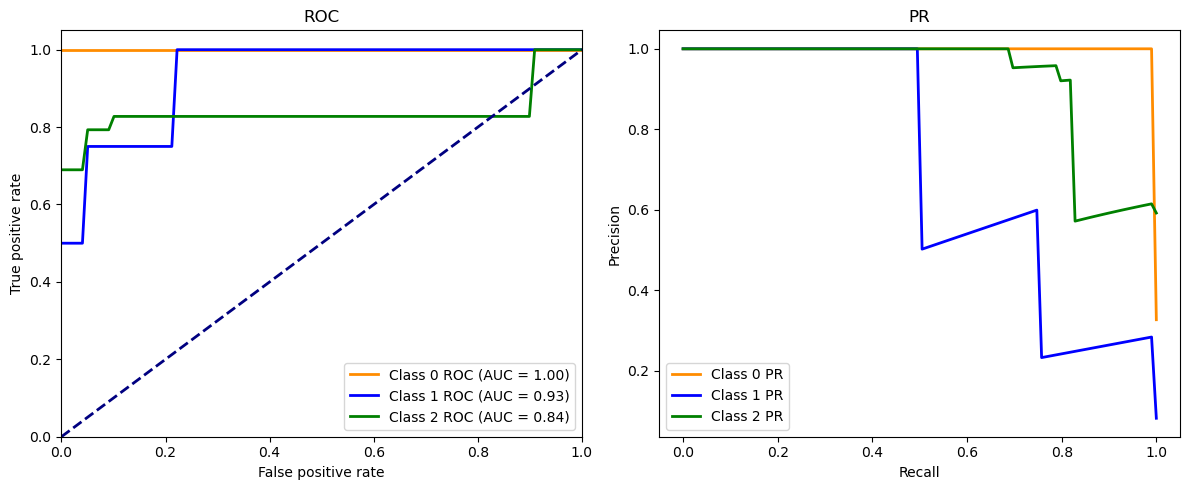

Epoch 26 model saved!
Model saved for epoch 26
Train Epoch: 27 [68/321 (20%)]	Loss: 0.573165, Accu: 100.00%
Train Epoch: 27 [136/321 (40%)]	Loss: 0.576514, Accu: 100.00%
Train Epoch: 27 [204/321 (60%)]	Loss: 0.584065, Accu: 97.06%
Train Epoch: 27 [272/321 (80%)]	Loss: 0.566755, Accu: 100.00%
Train Epoch: 27 [321/321 (100%)]	Loss: 0.576256, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.50      0.50      0.50         4
           2       0.93      0.93      0.93        29

    accuracy                           0.92        49
   macro avg       0.81      0.81      0.81        49
weighted avg       0.92      0.92      0.92        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


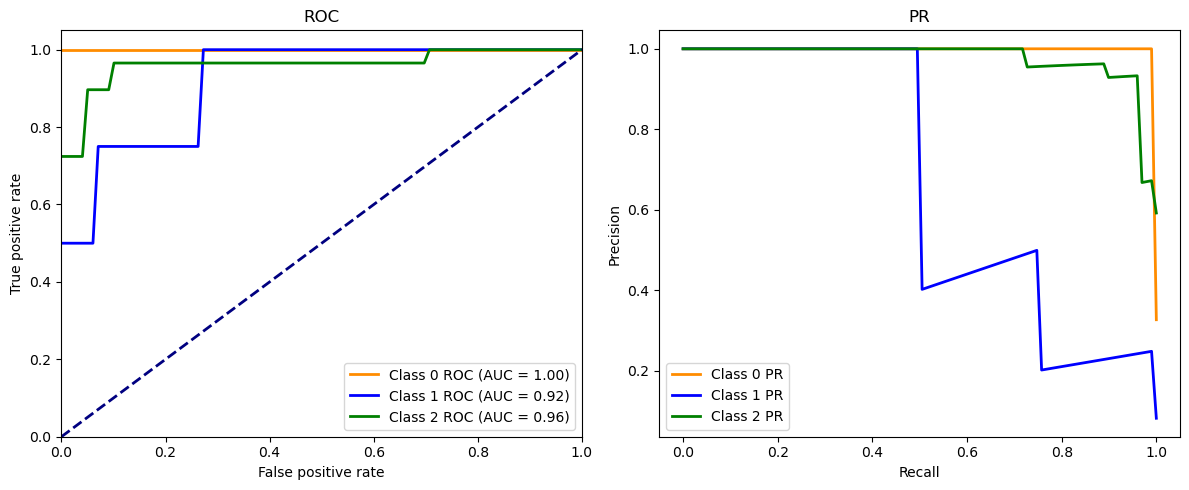

Epoch 27 model saved!
Model saved for epoch 27
Train Epoch: 28 [68/321 (20%)]	Loss: 0.581968, Accu: 100.00%
Train Epoch: 28 [136/321 (40%)]	Loss: 0.593102, Accu: 97.06%
Train Epoch: 28 [204/321 (60%)]	Loss: 0.580495, Accu: 100.00%
Train Epoch: 28 [272/321 (80%)]	Loss: 0.596882, Accu: 97.06%
Train Epoch: 28 [321/321 (100%)]	Loss: 0.567876, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


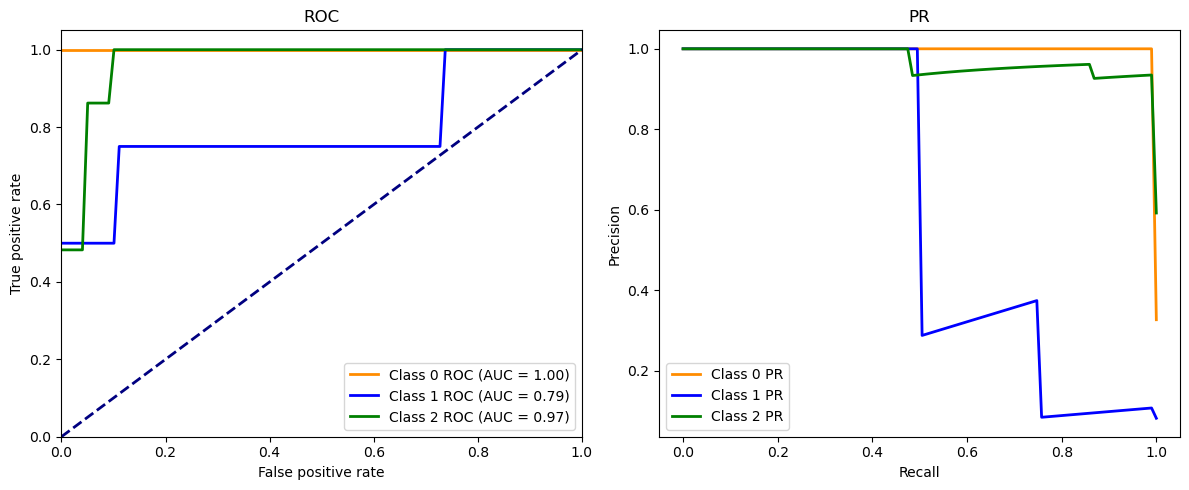

Epoch 28 model saved!
Model saved for epoch 28
Train Epoch: 29 [68/321 (20%)]	Loss: 0.573066, Accu: 100.00%
Train Epoch: 29 [136/321 (40%)]	Loss: 0.577082, Accu: 100.00%
Train Epoch: 29 [204/321 (60%)]	Loss: 0.600626, Accu: 97.06%
Train Epoch: 29 [272/321 (80%)]	Loss: 0.576400, Accu: 100.00%
Train Epoch: 29 [321/321 (100%)]	Loss: 0.583795, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.00      0.00      0.00         4
           2       0.88      1.00      0.94        29

    accuracy                           0.92        49
   macro avg       0.63      0.67      0.65        49
weighted avg       0.85      0.92      0.88        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


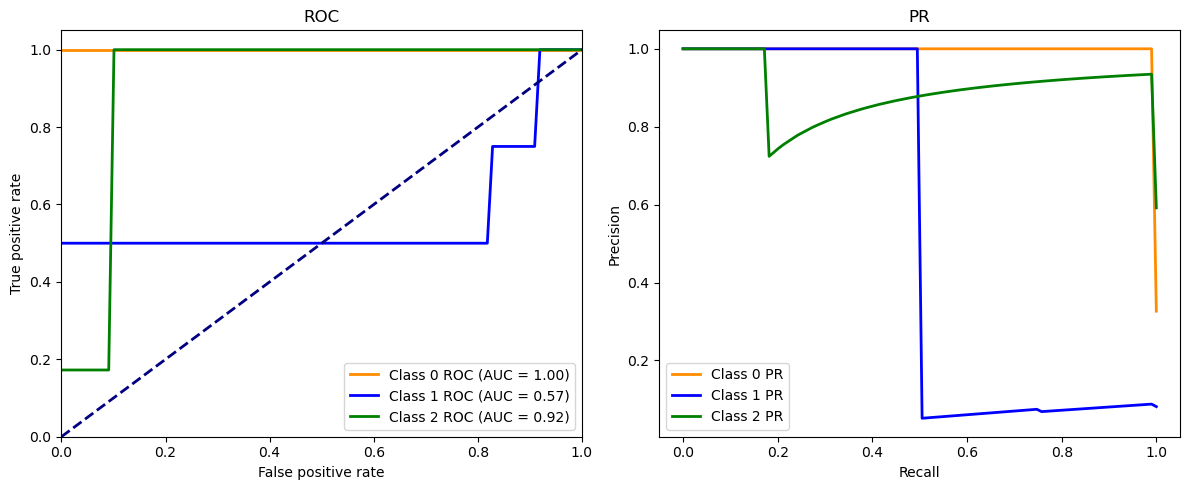

Epoch 29 model saved!
Model saved for epoch 29
Train Epoch: 30 [68/321 (20%)]	Loss: 0.580887, Accu: 100.00%
Train Epoch: 30 [136/321 (40%)]	Loss: 0.569050, Accu: 100.00%
Train Epoch: 30 [204/321 (60%)]	Loss: 0.566897, Accu: 100.00%
Train Epoch: 30 [272/321 (80%)]	Loss: 0.570944, Accu: 100.00%
Train Epoch: 30 [321/321 (100%)]	Loss: 0.635967, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


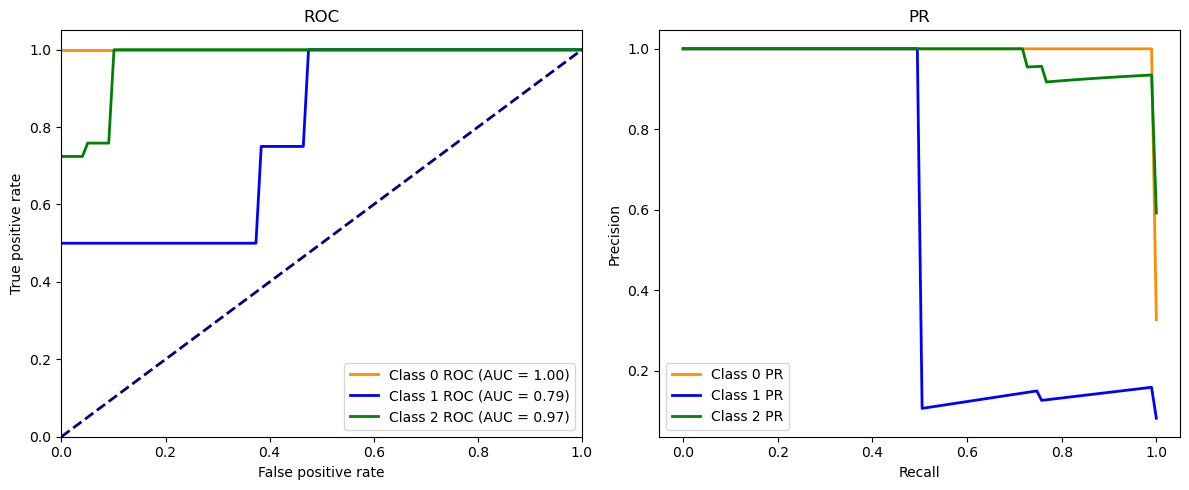

Epoch 30 model saved!
Model saved for epoch 30
Train Epoch: 31 [68/321 (20%)]	Loss: 0.572885, Accu: 100.00%
Train Epoch: 31 [136/321 (40%)]	Loss: 0.573017, Accu: 100.00%
Train Epoch: 31 [204/321 (60%)]	Loss: 0.583756, Accu: 97.06%
Train Epoch: 31 [272/321 (80%)]	Loss: 0.585195, Accu: 100.00%
Train Epoch: 31 [321/321 (100%)]	Loss: 0.569412, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.50      0.50      0.50         4
           2       0.93      0.93      0.93        29

    accuracy                           0.92        49
   macro avg       0.81      0.81      0.81        49
weighted avg       0.92      0.92      0.92        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


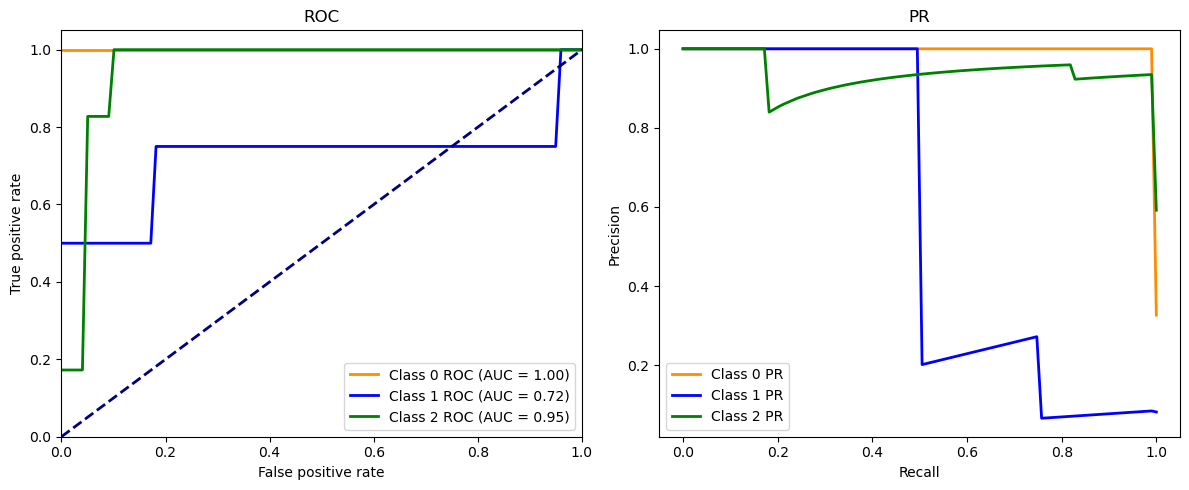

Epoch 31 model saved!
Model saved for epoch 31
Train Epoch: 32 [68/321 (20%)]	Loss: 0.569431, Accu: 100.00%
Train Epoch: 32 [136/321 (40%)]	Loss: 0.589363, Accu: 100.00%
Train Epoch: 32 [204/321 (60%)]	Loss: 0.619126, Accu: 97.06%
Train Epoch: 32 [272/321 (80%)]	Loss: 0.639367, Accu: 94.12%
Train Epoch: 32 [321/321 (100%)]	Loss: 0.574618, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.27      1.00      0.42         4
           2       1.00      0.62      0.77        29

    accuracy                           0.78        49
   macro avg       0.76      0.87      0.73        49
weighted avg       0.94      0.78      0.81        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


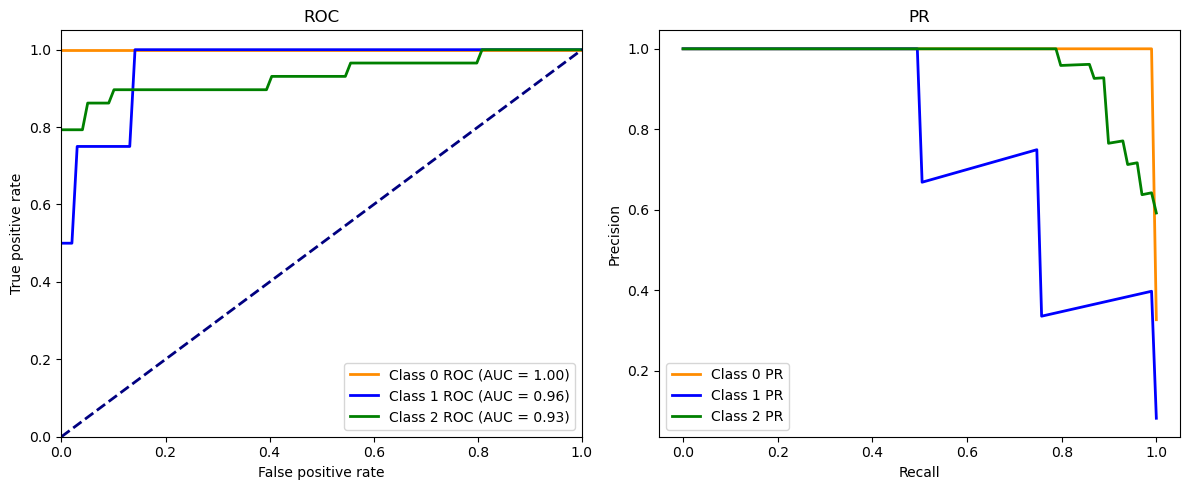

Epoch 32 model saved!
Model saved for epoch 32
Train Epoch: 33 [68/321 (20%)]	Loss: 0.568050, Accu: 100.00%
Train Epoch: 33 [136/321 (40%)]	Loss: 0.600503, Accu: 100.00%
Train Epoch: 33 [204/321 (60%)]	Loss: 0.576171, Accu: 100.00%
Train Epoch: 33 [272/321 (80%)]	Loss: 0.584954, Accu: 100.00%
Train Epoch: 33 [321/321 (100%)]	Loss: 0.660540, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      1.00      0.57         4
           2       1.00      0.79      0.88        29

    accuracy                           0.88        49
   macro avg       0.80      0.93      0.82        49
weighted avg       0.95      0.88      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


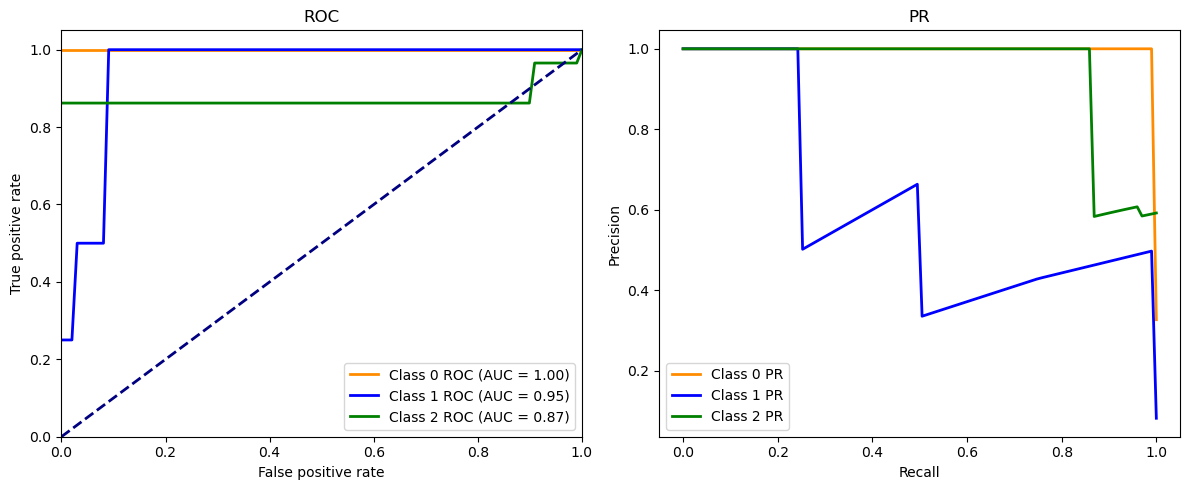

Epoch 33 model saved!
Model saved for epoch 33
Train Epoch: 34 [68/321 (20%)]	Loss: 0.572114, Accu: 100.00%
Train Epoch: 34 [136/321 (40%)]	Loss: 0.566286, Accu: 100.00%
Train Epoch: 34 [204/321 (60%)]	Loss: 0.574067, Accu: 100.00%
Train Epoch: 34 [272/321 (80%)]	Loss: 0.568848, Accu: 100.00%
Train Epoch: 34 [321/321 (100%)]	Loss: 0.583723, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


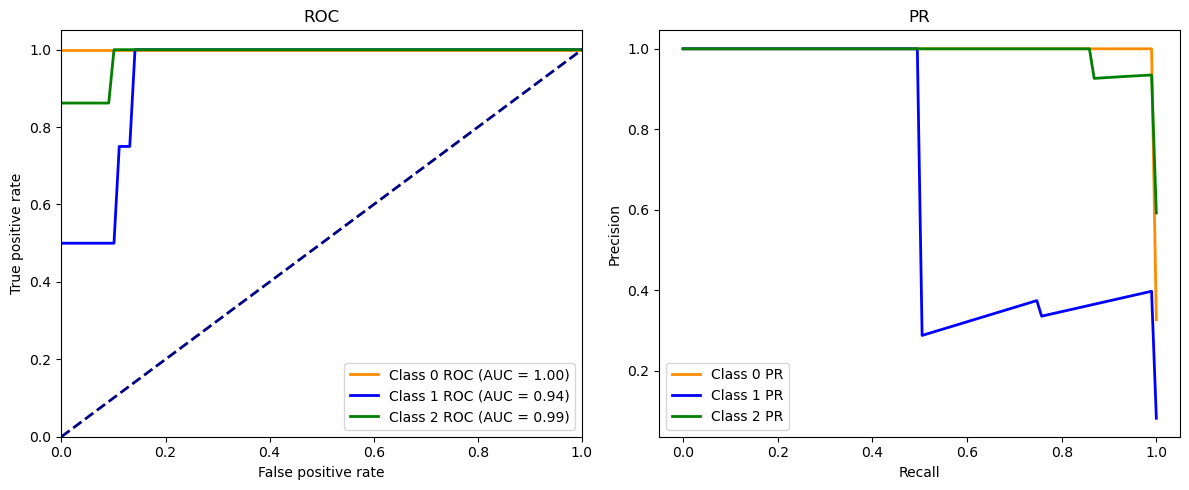

Epoch 34 model saved!
Model saved for epoch 34
Train Epoch: 35 [68/321 (20%)]	Loss: 0.584186, Accu: 100.00%
Train Epoch: 35 [136/321 (40%)]	Loss: 0.573408, Accu: 100.00%
Train Epoch: 35 [204/321 (60%)]	Loss: 0.574524, Accu: 100.00%
Train Epoch: 35 [272/321 (80%)]	Loss: 0.568106, Accu: 100.00%
Train Epoch: 35 [321/321 (100%)]	Loss: 0.570431, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      1.00      0.57         4
           2       1.00      0.79      0.88        29

    accuracy                           0.88        49
   macro avg       0.80      0.93      0.82        49
weighted avg       0.95      0.88      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


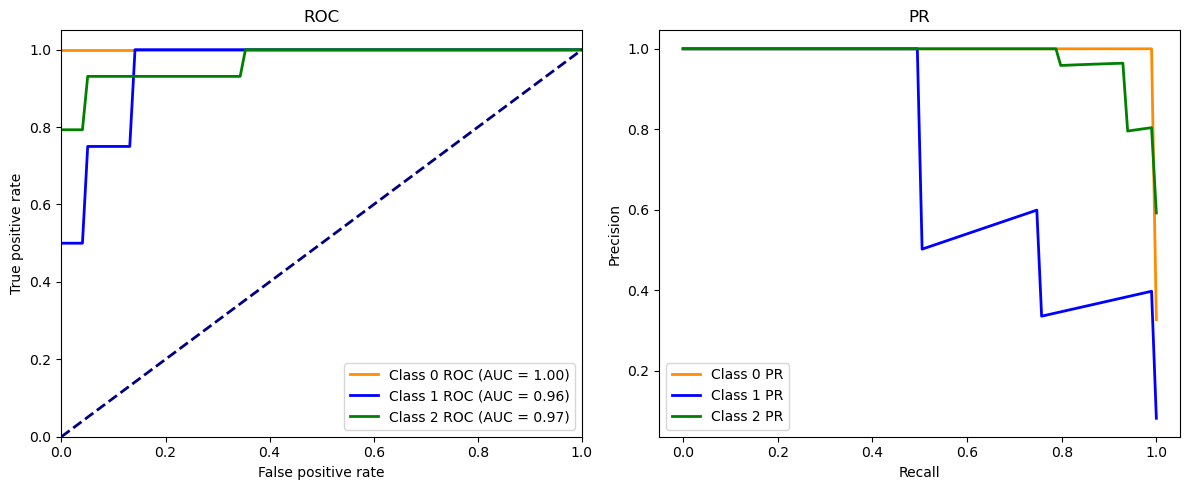

Epoch 35 model saved!
Model saved for epoch 35
Train Epoch: 36 [68/321 (20%)]	Loss: 0.569267, Accu: 100.00%
Train Epoch: 36 [136/321 (40%)]	Loss: 0.566682, Accu: 100.00%
Train Epoch: 36 [204/321 (60%)]	Loss: 0.566183, Accu: 100.00%
Train Epoch: 36 [272/321 (80%)]	Loss: 0.576955, Accu: 100.00%
Train Epoch: 36 [321/321 (100%)]	Loss: 0.569804, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      1.00      0.57         4
           2       1.00      0.79      0.88        29

    accuracy                           0.88        49
   macro avg       0.80      0.93      0.82        49
weighted avg       0.95      0.88      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


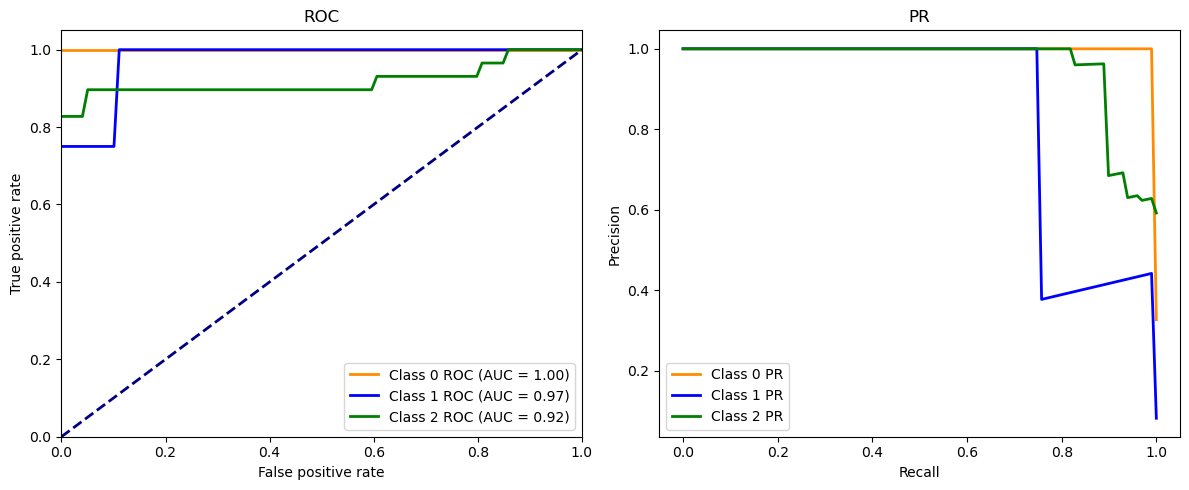

Epoch 36 model saved!
Model saved for epoch 36
Train Epoch: 37 [68/321 (20%)]	Loss: 0.567510, Accu: 100.00%
Train Epoch: 37 [136/321 (40%)]	Loss: 0.571587, Accu: 100.00%
Train Epoch: 37 [204/321 (60%)]	Loss: 0.567830, Accu: 100.00%
Train Epoch: 37 [272/321 (80%)]	Loss: 0.574118, Accu: 100.00%
Train Epoch: 37 [321/321 (100%)]	Loss: 0.596671, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.50      0.40         4
           2       0.93      0.86      0.89        29

    accuracy                           0.88        49
   macro avg       0.75      0.79      0.76        49
weighted avg       0.90      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


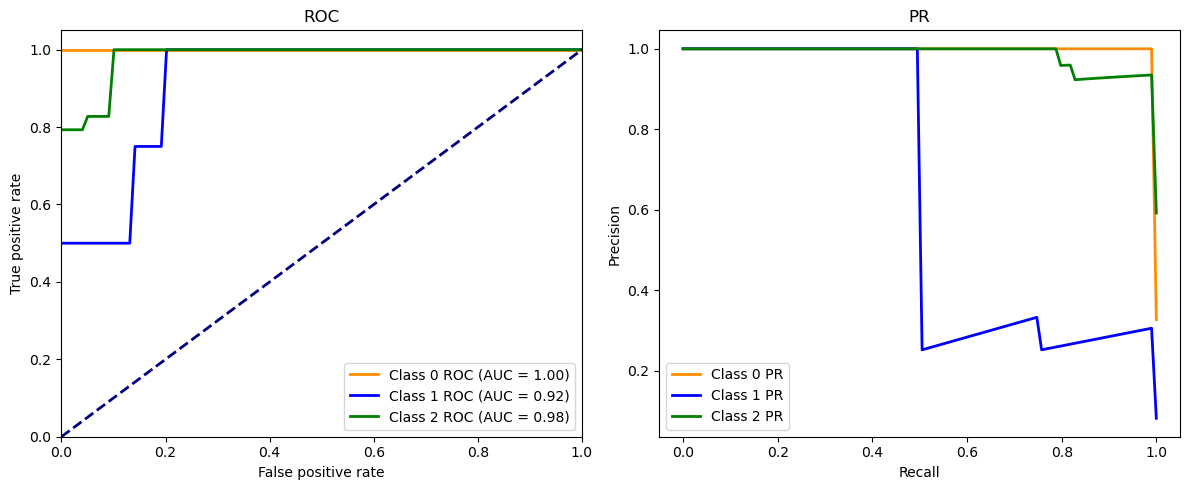

Epoch 37 model saved!
Model saved for epoch 37
Train Epoch: 38 [68/321 (20%)]	Loss: 0.571383, Accu: 100.00%
Train Epoch: 38 [136/321 (40%)]	Loss: 0.577121, Accu: 100.00%
Train Epoch: 38 [204/321 (60%)]	Loss: 0.602412, Accu: 97.06%
Train Epoch: 38 [272/321 (80%)]	Loss: 0.569310, Accu: 100.00%
Train Epoch: 38 [321/321 (100%)]	Loss: 0.655693, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.29      1.00      0.44         4
           2       1.00      0.69      0.82        29

    accuracy                           0.80        49
   macro avg       0.76      0.88      0.74        49
weighted avg       0.94      0.80      0.84        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


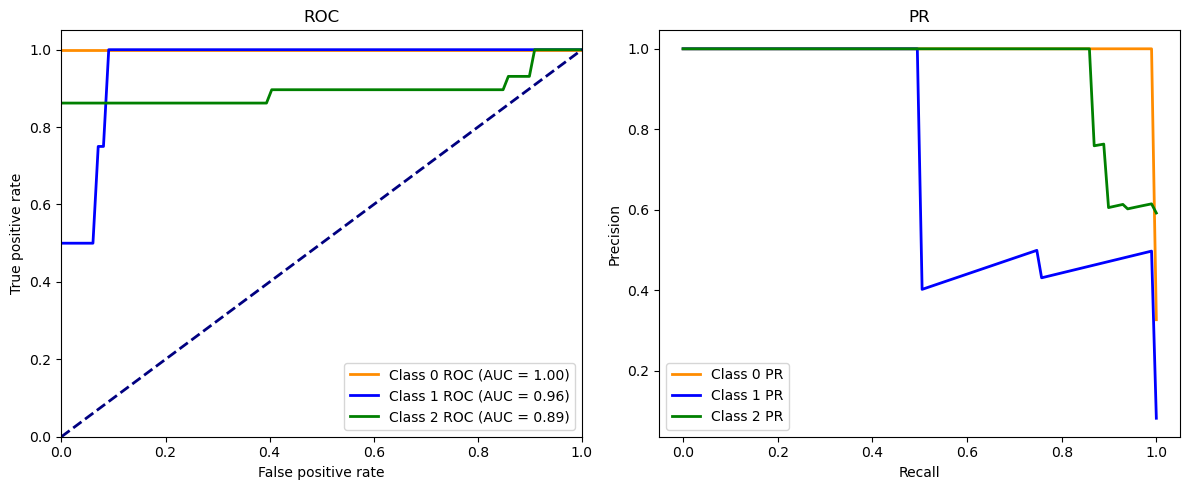

Epoch 38 model saved!
Model saved for epoch 38
Train Epoch: 39 [68/321 (20%)]	Loss: 0.576406, Accu: 100.00%
Train Epoch: 39 [136/321 (40%)]	Loss: 0.569822, Accu: 100.00%
Train Epoch: 39 [204/321 (60%)]	Loss: 0.564110, Accu: 100.00%
Train Epoch: 39 [272/321 (80%)]	Loss: 0.567788, Accu: 100.00%
Train Epoch: 39 [321/321 (100%)]	Loss: 0.633050, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.36      1.00      0.53         4
           2       1.00      0.76      0.86        29

    accuracy                           0.86        49
   macro avg       0.79      0.92      0.80        49
weighted avg       0.95      0.86      0.88        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


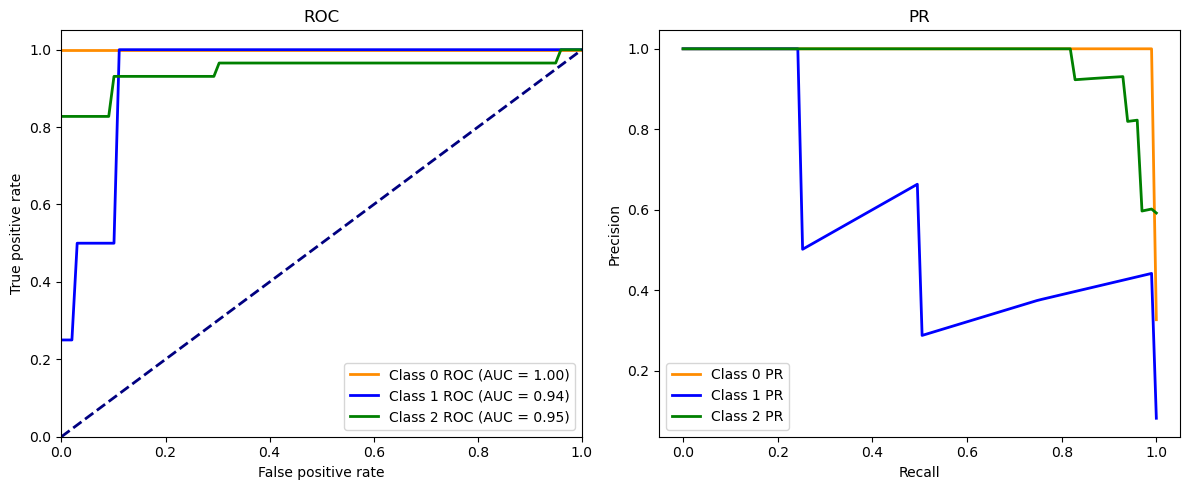

Epoch 39 model saved!
Model saved for epoch 39
Train Epoch: 40 [68/321 (20%)]	Loss: 0.569426, Accu: 100.00%
Train Epoch: 40 [136/321 (40%)]	Loss: 0.567720, Accu: 100.00%
Train Epoch: 40 [204/321 (60%)]	Loss: 0.566189, Accu: 100.00%
Train Epoch: 40 [272/321 (80%)]	Loss: 0.565717, Accu: 100.00%
Train Epoch: 40 [321/321 (100%)]	Loss: 0.572077, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      1.00      0.50         4
           2       1.00      0.72      0.84        29

    accuracy                           0.84        49
   macro avg       0.78      0.91      0.78        49
weighted avg       0.95      0.84      0.86        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


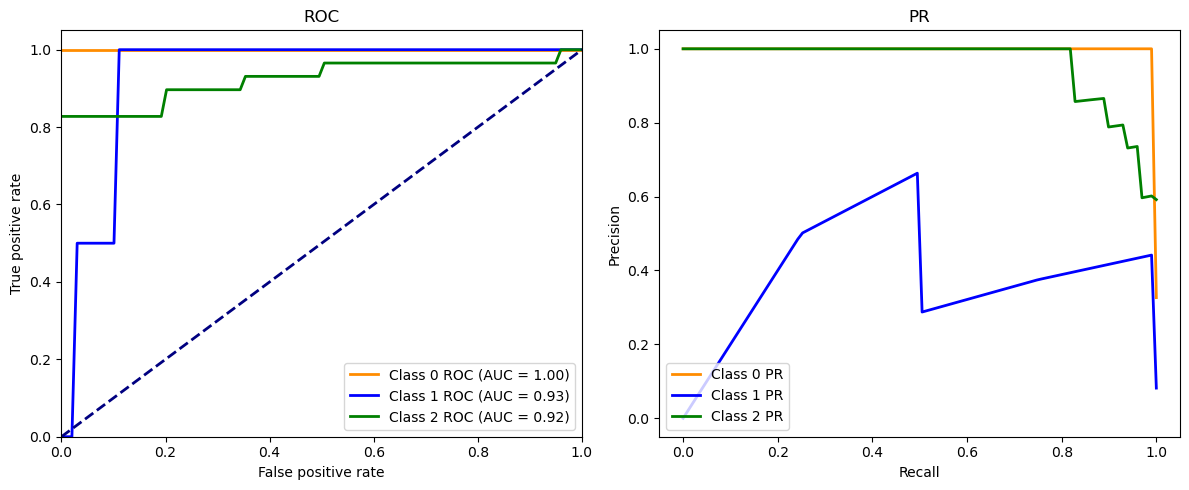

Epoch 40 model saved!
Model saved for epoch 40
Train Epoch: 41 [68/321 (20%)]	Loss: 0.563598, Accu: 100.00%
Train Epoch: 41 [136/321 (40%)]	Loss: 0.564854, Accu: 100.00%
Train Epoch: 41 [204/321 (60%)]	Loss: 0.566681, Accu: 100.00%
Train Epoch: 41 [272/321 (80%)]	Loss: 0.567122, Accu: 100.00%
Train Epoch: 41 [321/321 (100%)]	Loss: 0.567758, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.36      1.00      0.53         4
           2       1.00      0.79      0.88        29

    accuracy                           0.86        49
   macro avg       0.79      0.91      0.80        49
weighted avg       0.95      0.86      0.88        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


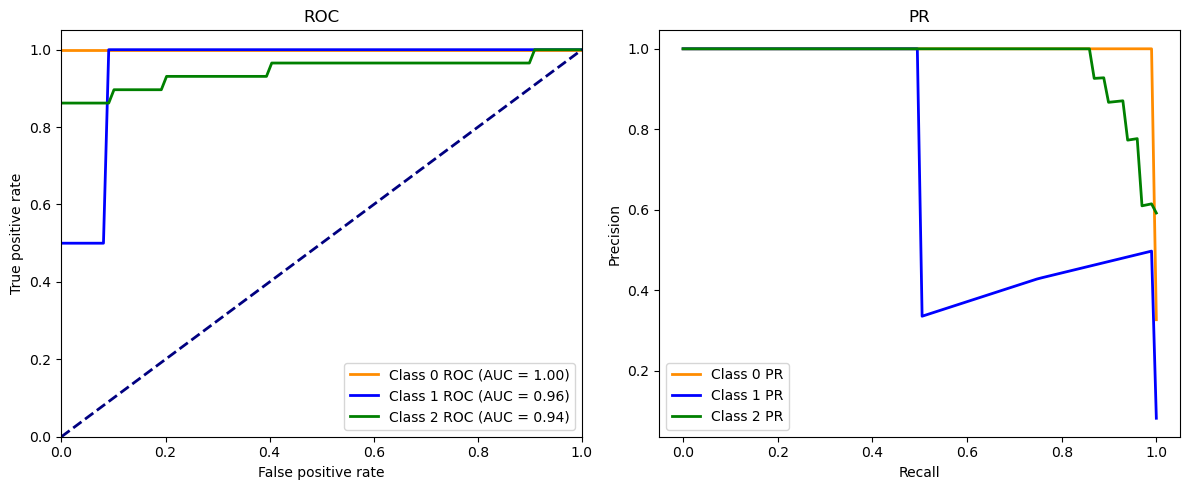

Epoch 41 model saved!
Model saved for epoch 41
Train Epoch: 42 [68/321 (20%)]	Loss: 0.565030, Accu: 100.00%
Train Epoch: 42 [136/321 (40%)]	Loss: 0.574788, Accu: 100.00%
Train Epoch: 42 [204/321 (60%)]	Loss: 0.568234, Accu: 100.00%
Train Epoch: 42 [272/321 (80%)]	Loss: 0.564917, Accu: 100.00%
Train Epoch: 42 [321/321 (100%)]	Loss: 0.563954, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.50      0.40         4
           2       0.93      0.86      0.89        29

    accuracy                           0.88        49
   macro avg       0.75      0.79      0.76        49
weighted avg       0.90      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


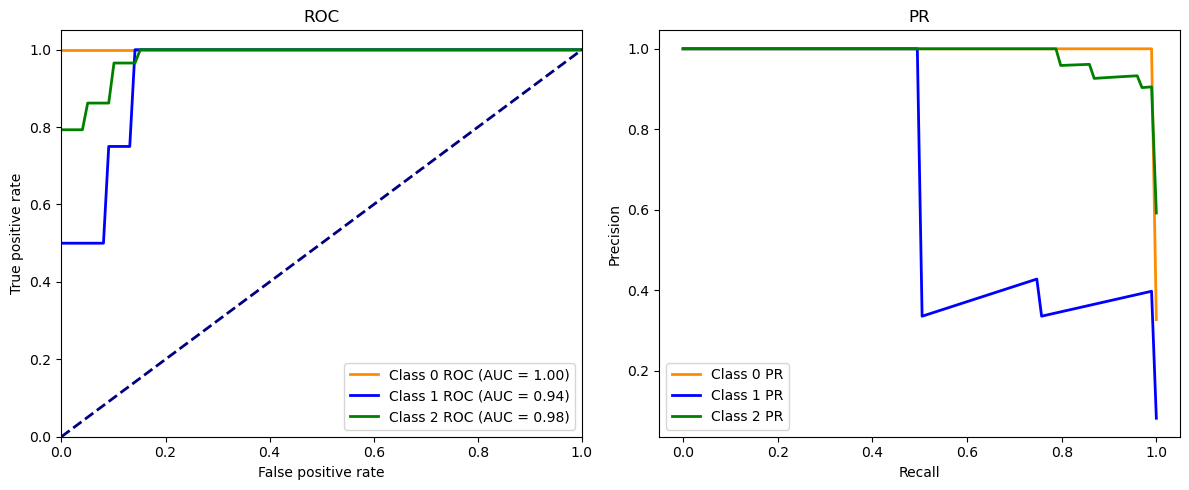

Epoch 42 model saved!
Model saved for epoch 42
Train Epoch: 43 [68/321 (20%)]	Loss: 0.566227, Accu: 100.00%
Train Epoch: 43 [136/321 (40%)]	Loss: 0.568477, Accu: 100.00%
Train Epoch: 43 [204/321 (60%)]	Loss: 0.565820, Accu: 100.00%
Train Epoch: 43 [272/321 (80%)]	Loss: 0.562651, Accu: 100.00%
Train Epoch: 43 [321/321 (100%)]	Loss: 0.566138, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.50      0.40         4
           2       0.93      0.86      0.89        29

    accuracy                           0.88        49
   macro avg       0.75      0.79      0.76        49
weighted avg       0.90      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


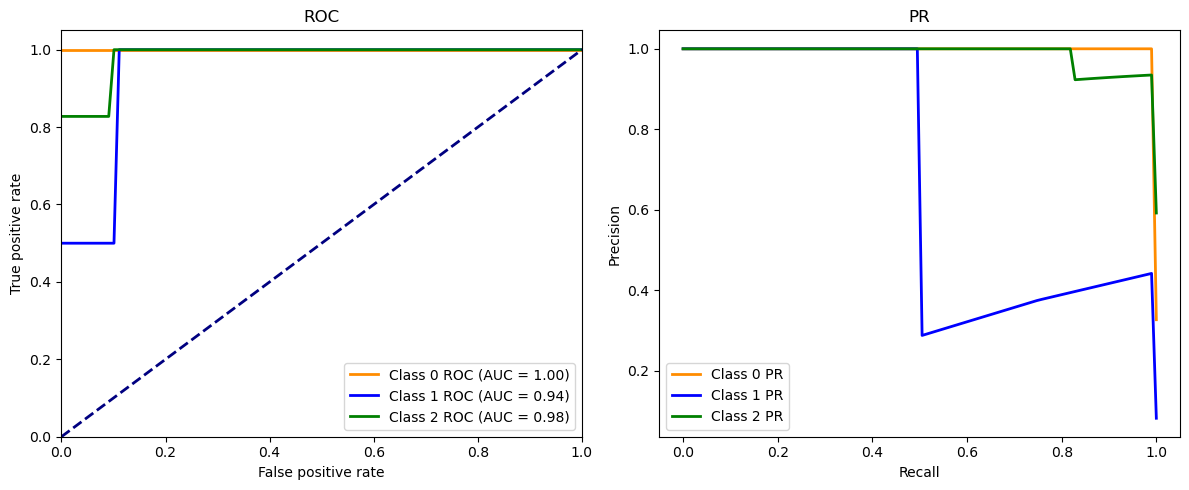

Epoch 43 model saved!
Model saved for epoch 43
Train Epoch: 44 [68/321 (20%)]	Loss: 0.565003, Accu: 100.00%
Train Epoch: 44 [136/321 (40%)]	Loss: 0.581568, Accu: 100.00%
Train Epoch: 44 [204/321 (60%)]	Loss: 0.563180, Accu: 100.00%
Train Epoch: 44 [272/321 (80%)]	Loss: 0.572509, Accu: 100.00%
Train Epoch: 44 [321/321 (100%)]	Loss: 0.580559, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.33      0.50      0.40         4
           2       0.93      0.90      0.91        29

    accuracy                           0.88        49
   macro avg       0.75      0.78      0.76        49
weighted avg       0.90      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


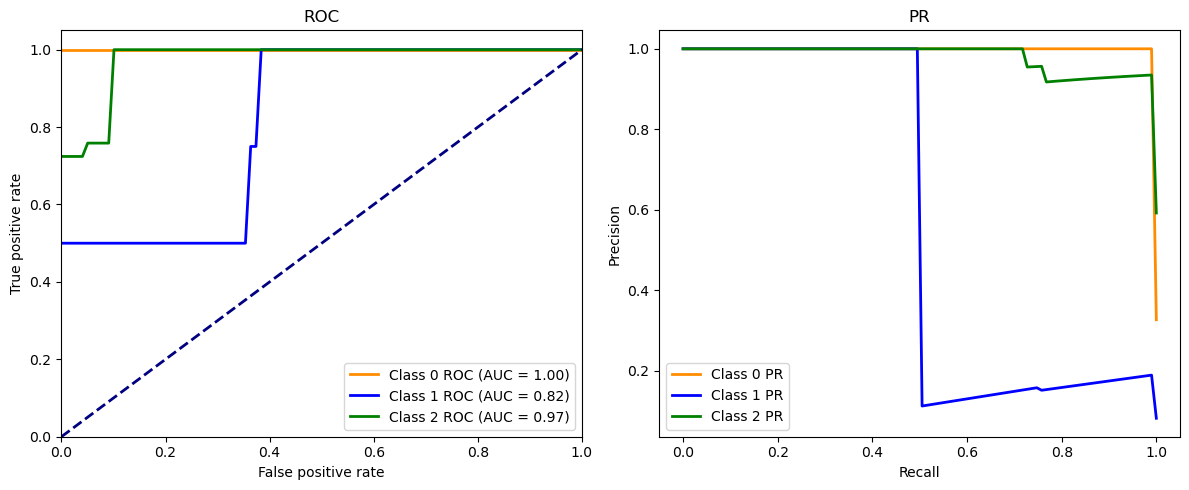

Epoch 44 model saved!
Model saved for epoch 44
Train Epoch: 45 [68/321 (20%)]	Loss: 0.566964, Accu: 100.00%
Train Epoch: 45 [136/321 (40%)]	Loss: 0.569546, Accu: 100.00%
Train Epoch: 45 [204/321 (60%)]	Loss: 0.563773, Accu: 100.00%
Train Epoch: 45 [272/321 (80%)]	Loss: 0.564887, Accu: 100.00%
Train Epoch: 45 [321/321 (100%)]	Loss: 0.564931, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


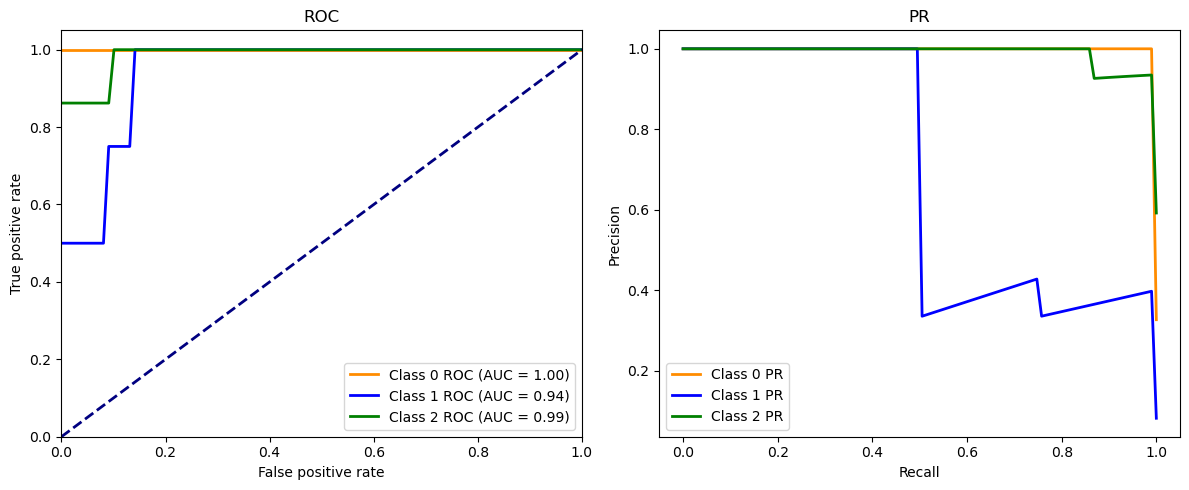

Epoch 45 model saved!
Model saved for epoch 45
Train Epoch: 46 [68/321 (20%)]	Loss: 0.571656, Accu: 100.00%
Train Epoch: 46 [136/321 (40%)]	Loss: 0.568116, Accu: 100.00%
Train Epoch: 46 [204/321 (60%)]	Loss: 0.563247, Accu: 100.00%
Train Epoch: 46 [272/321 (80%)]	Loss: 0.561886, Accu: 100.00%
Train Epoch: 46 [321/321 (100%)]	Loss: 0.562711, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


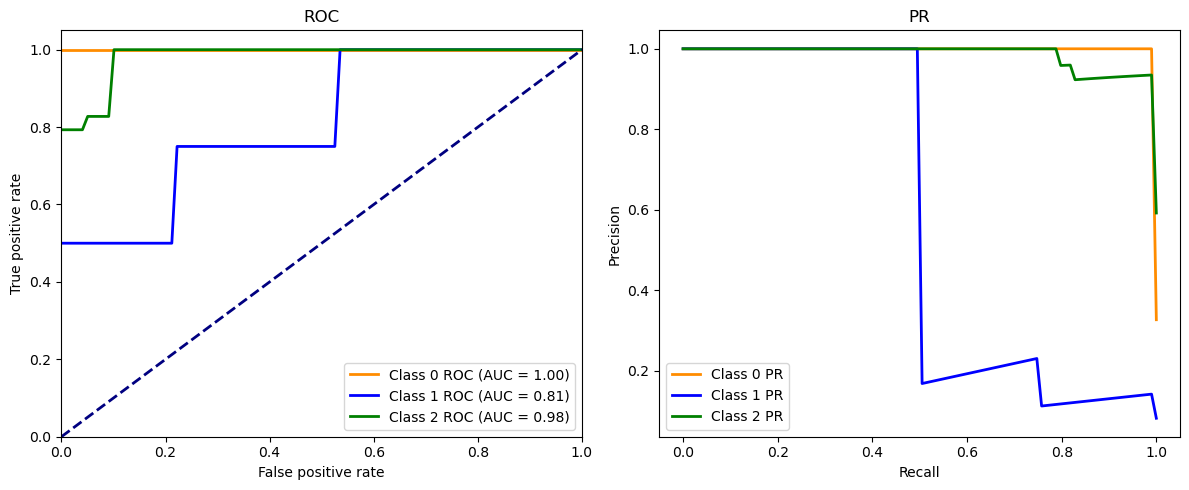

Epoch 46 model saved!
Model saved for epoch 46
Train Epoch: 47 [68/321 (20%)]	Loss: 0.565575, Accu: 100.00%
Train Epoch: 47 [136/321 (40%)]	Loss: 0.569622, Accu: 100.00%
Train Epoch: 47 [204/321 (60%)]	Loss: 0.574050, Accu: 100.00%
Train Epoch: 47 [272/321 (80%)]	Loss: 0.562699, Accu: 100.00%
Train Epoch: 47 [321/321 (100%)]	Loss: 0.562205, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.50      0.50      0.50         4
           2       0.93      0.93      0.93        29

    accuracy                           0.92        49
   macro avg       0.81      0.81      0.81        49
weighted avg       0.92      0.92      0.92        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


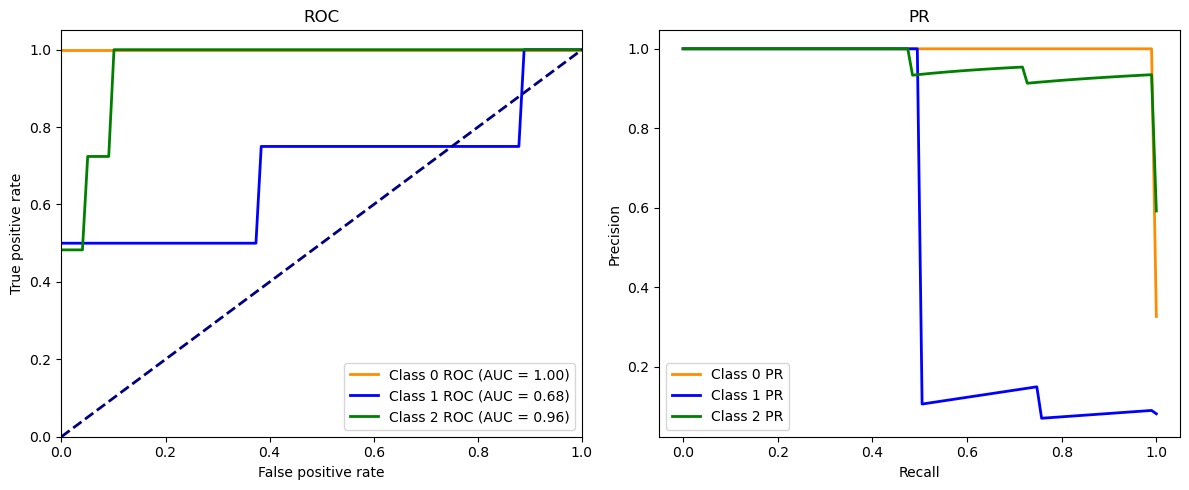

Epoch 47 model saved!
Model saved for epoch 47
Train Epoch: 48 [68/321 (20%)]	Loss: 0.562650, Accu: 100.00%
Train Epoch: 48 [136/321 (40%)]	Loss: 0.572519, Accu: 100.00%
Train Epoch: 48 [204/321 (60%)]	Loss: 0.565073, Accu: 100.00%
Train Epoch: 48 [272/321 (80%)]	Loss: 0.567776, Accu: 100.00%
Train Epoch: 48 [321/321 (100%)]	Loss: 0.563490, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


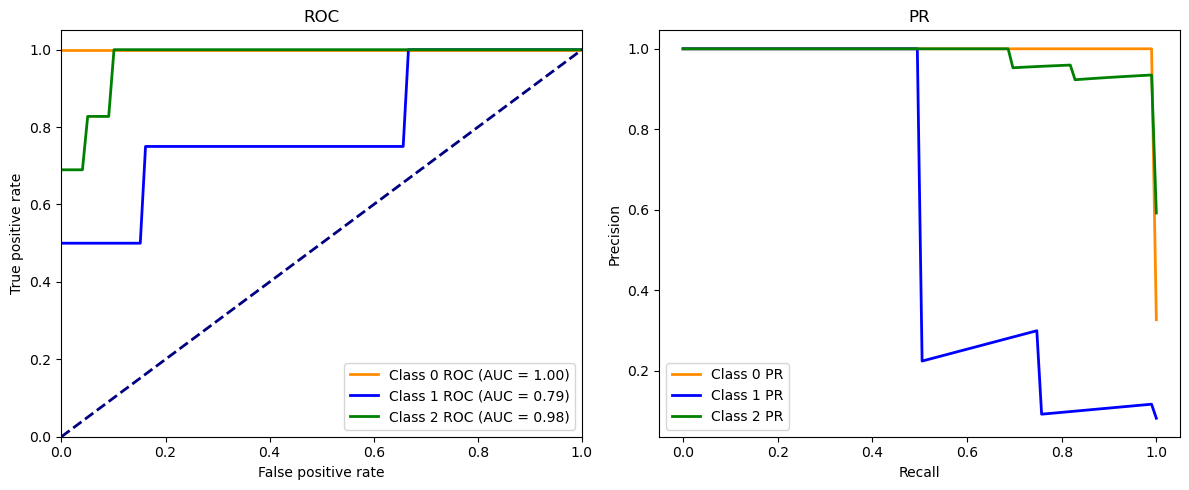

Epoch 48 model saved!
Model saved for epoch 48
Train Epoch: 49 [68/321 (20%)]	Loss: 0.562736, Accu: 100.00%
Train Epoch: 49 [136/321 (40%)]	Loss: 0.567287, Accu: 100.00%
Train Epoch: 49 [204/321 (60%)]	Loss: 0.571222, Accu: 100.00%
Train Epoch: 49 [272/321 (80%)]	Loss: 0.561522, Accu: 100.00%
Train Epoch: 49 [321/321 (100%)]	Loss: 0.579555, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.43      0.75      0.55         4
           2       0.96      0.86      0.91        29

    accuracy                           0.90        49
   macro avg       0.80      0.87      0.82        49
weighted avg       0.93      0.90      0.91        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


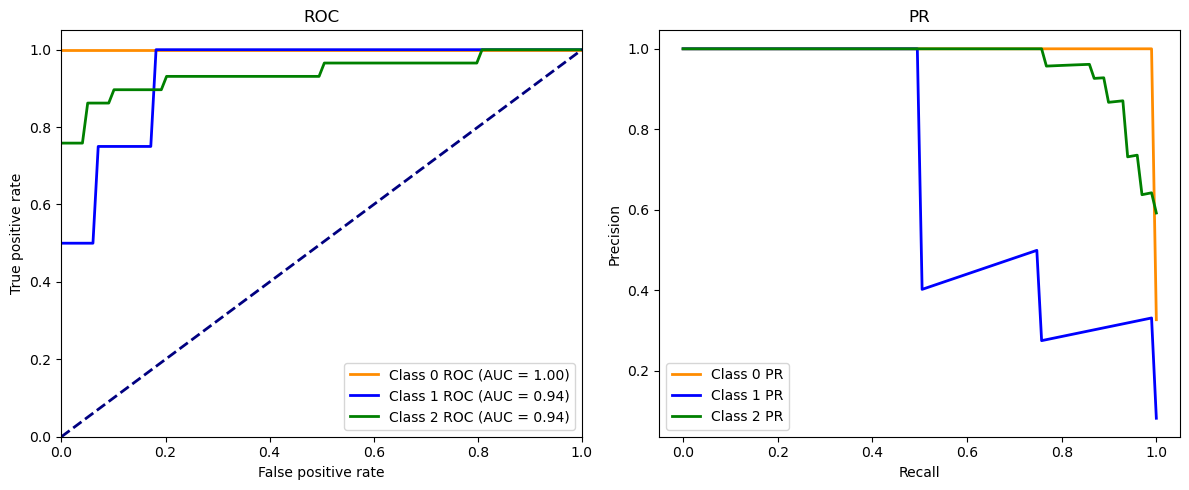

Epoch 49 model saved!
Model saved for epoch 49
Train Epoch: 50 [68/321 (20%)]	Loss: 0.561244, Accu: 100.00%
Train Epoch: 50 [136/321 (40%)]	Loss: 0.561186, Accu: 100.00%
Train Epoch: 50 [204/321 (60%)]	Loss: 0.560756, Accu: 100.00%
Train Epoch: 50 [272/321 (80%)]	Loss: 0.565745, Accu: 100.00%
Train Epoch: 50 [321/321 (100%)]	Loss: 0.562855, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.67      0.50      0.57         4
           2       0.93      0.97      0.95        29

    accuracy                           0.94        49
   macro avg       0.87      0.82      0.84        49
weighted avg       0.93      0.94      0.93        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


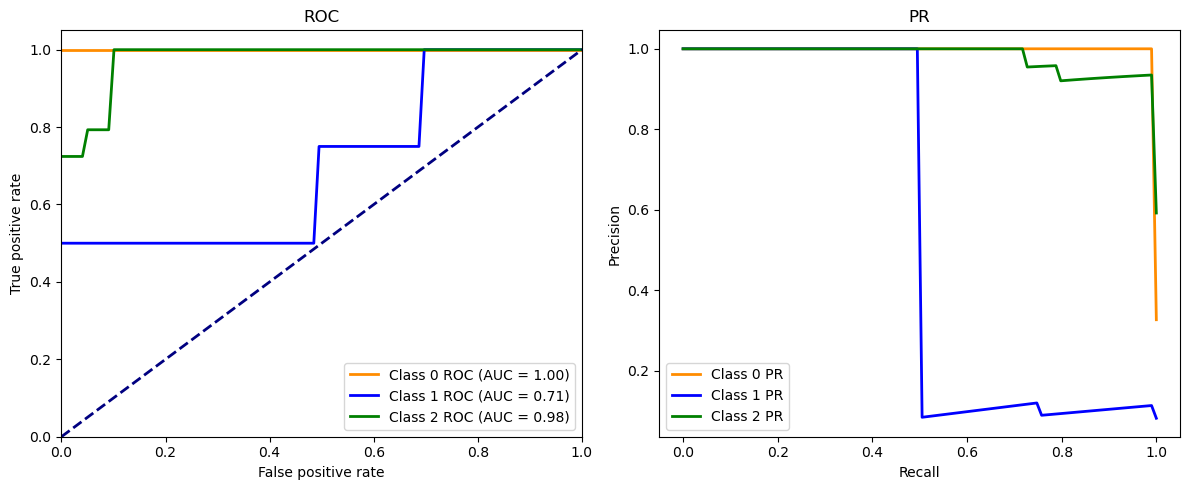

Epoch 50 model saved!
Model saved for epoch 50
Train Epoch: 51 [68/321 (20%)]	Loss: 0.586374, Accu: 100.00%
Train Epoch: 51 [136/321 (40%)]	Loss: 0.579378, Accu: 100.00%
Train Epoch: 51 [204/321 (60%)]	Loss: 0.568840, Accu: 100.00%
Train Epoch: 51 [272/321 (80%)]	Loss: 0.564200, Accu: 100.00%
Train Epoch: 51 [321/321 (100%)]	Loss: 0.570695, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.50      0.50      0.50         4
           2       0.93      0.93      0.93        29

    accuracy                           0.92        49
   macro avg       0.81      0.81      0.81        49
weighted avg       0.92      0.92      0.92        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


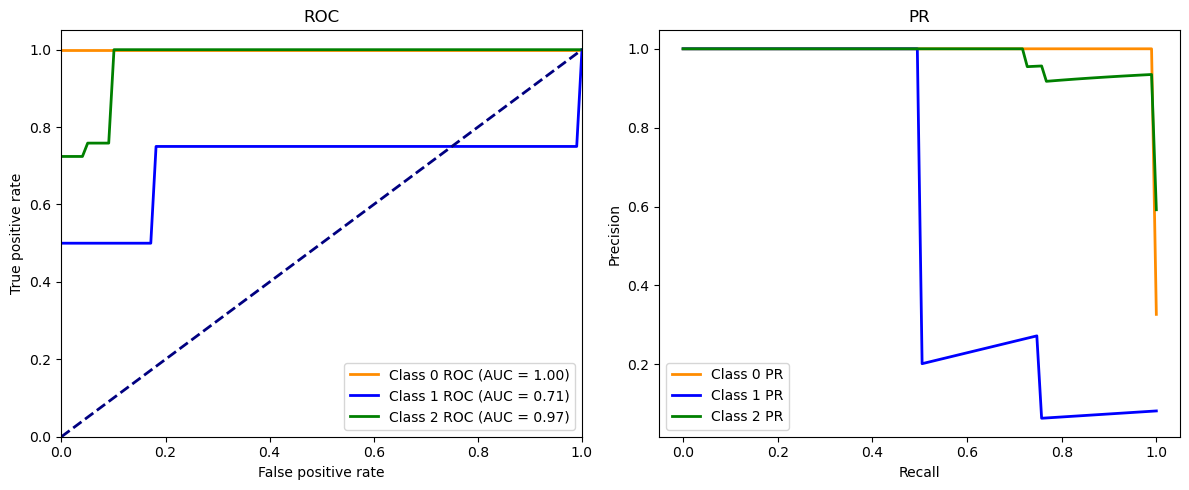

Epoch 51 model saved!
Model saved for epoch 51
Train Epoch: 52 [68/321 (20%)]	Loss: 0.563988, Accu: 100.00%
Train Epoch: 52 [136/321 (40%)]	Loss: 0.563114, Accu: 100.00%
Train Epoch: 52 [204/321 (60%)]	Loss: 0.561433, Accu: 100.00%
Train Epoch: 52 [272/321 (80%)]	Loss: 0.561461, Accu: 100.00%
Train Epoch: 52 [321/321 (100%)]	Loss: 0.563883, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.67      0.50      0.57         4
           2       0.93      0.97      0.95        29

    accuracy                           0.94        49
   macro avg       0.87      0.82      0.84        49
weighted avg       0.93      0.94      0.93        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


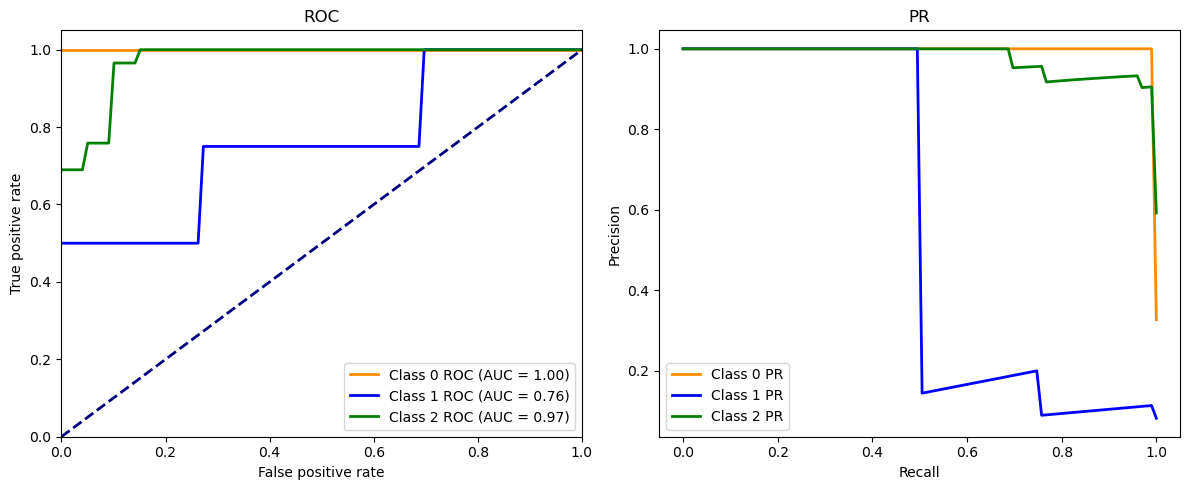

Epoch 52 model saved!
Model saved for epoch 52
Train Epoch: 53 [68/321 (20%)]	Loss: 0.560868, Accu: 100.00%
Train Epoch: 53 [136/321 (40%)]	Loss: 0.562107, Accu: 100.00%
Train Epoch: 53 [204/321 (60%)]	Loss: 0.562323, Accu: 100.00%
Train Epoch: 53 [272/321 (80%)]	Loss: 0.564437, Accu: 100.00%
Train Epoch: 53 [321/321 (100%)]	Loss: 0.566875, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.44      1.00      0.62         4
           2       1.00      0.86      0.93        29

    accuracy                           0.90        49
   macro avg       0.81      0.93      0.84        49
weighted avg       0.95      0.90      0.91        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


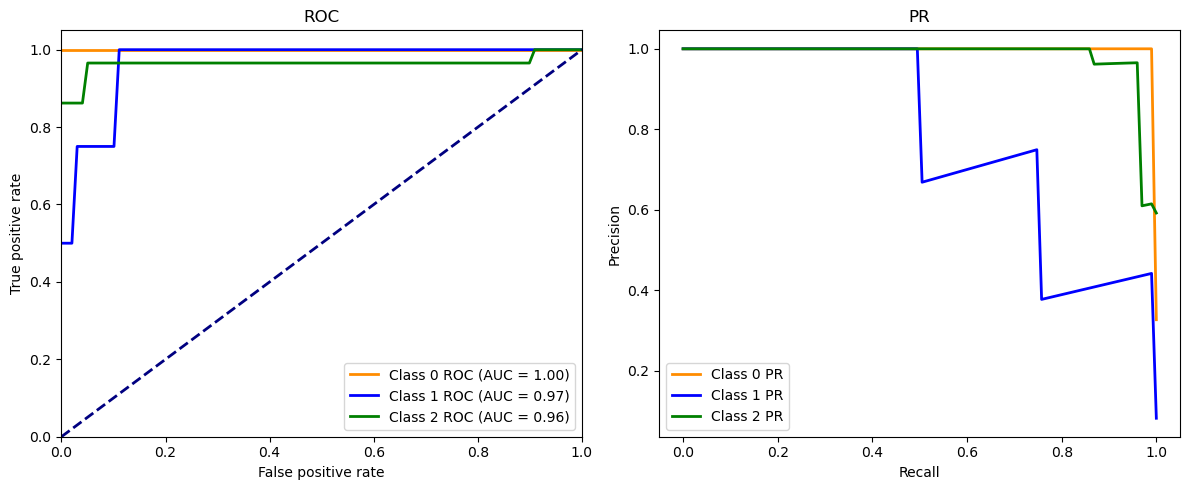

Epoch 53 model saved!
Model saved for epoch 53
Train Epoch: 54 [68/321 (20%)]	Loss: 0.561707, Accu: 100.00%
Train Epoch: 54 [136/321 (40%)]	Loss: 0.560145, Accu: 100.00%
Train Epoch: 54 [204/321 (60%)]	Loss: 0.562101, Accu: 100.00%
Train Epoch: 54 [272/321 (80%)]	Loss: 0.564482, Accu: 100.00%
Train Epoch: 54 [321/321 (100%)]	Loss: 0.560159, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.50      0.40         4
           2       0.93      0.86      0.89        29

    accuracy                           0.88        49
   macro avg       0.75      0.79      0.76        49
weighted avg       0.90      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


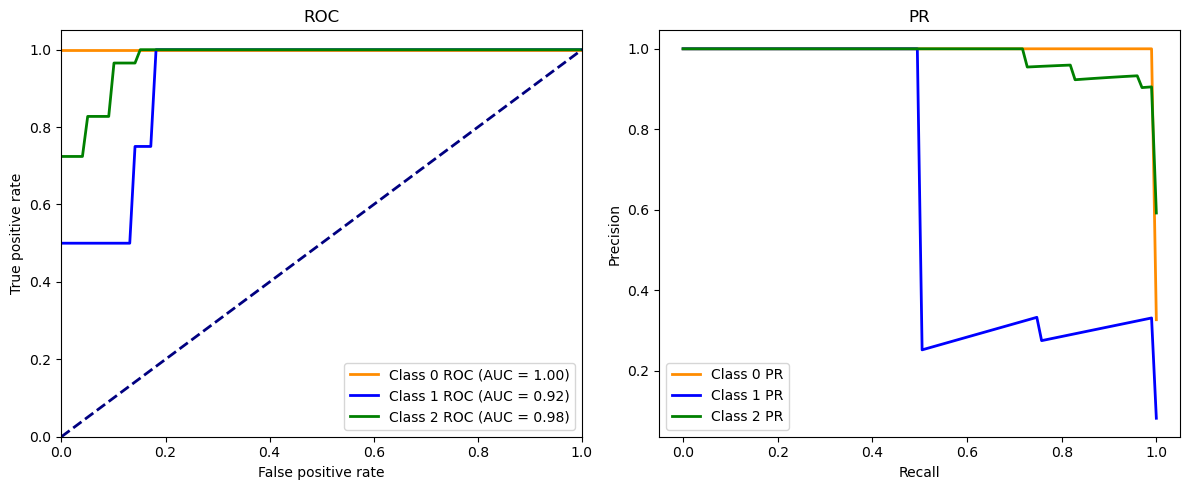

Epoch 54 model saved!
Model saved for epoch 54
Train Epoch: 55 [68/321 (20%)]	Loss: 0.560472, Accu: 100.00%
Train Epoch: 55 [136/321 (40%)]	Loss: 0.566058, Accu: 100.00%
Train Epoch: 55 [204/321 (60%)]	Loss: 0.565925, Accu: 100.00%
Train Epoch: 55 [272/321 (80%)]	Loss: 0.561158, Accu: 100.00%
Train Epoch: 55 [321/321 (100%)]	Loss: 0.571503, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


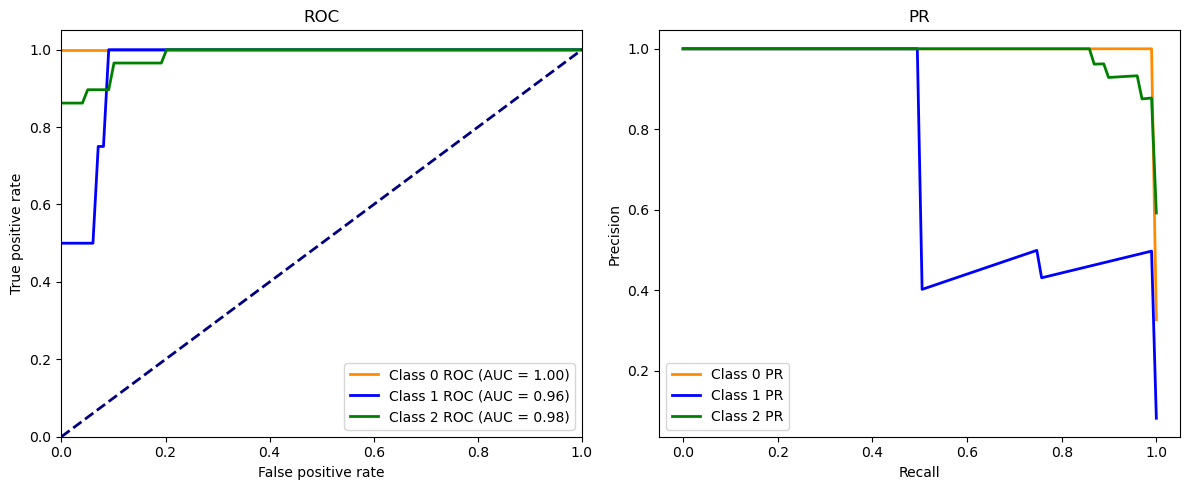

Epoch 55 model saved!
Model saved for epoch 55
Train Epoch: 56 [68/321 (20%)]	Loss: 0.560934, Accu: 100.00%
Train Epoch: 56 [136/321 (40%)]	Loss: 0.559463, Accu: 100.00%
Train Epoch: 56 [204/321 (60%)]	Loss: 0.562442, Accu: 100.00%
Train Epoch: 56 [272/321 (80%)]	Loss: 0.564591, Accu: 100.00%
Train Epoch: 56 [321/321 (100%)]	Loss: 0.571636, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.44      1.00      0.62         4
           2       1.00      0.83      0.91        29

    accuracy                           0.90        49
   macro avg       0.81      0.94      0.84        49
weighted avg       0.95      0.90      0.91        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


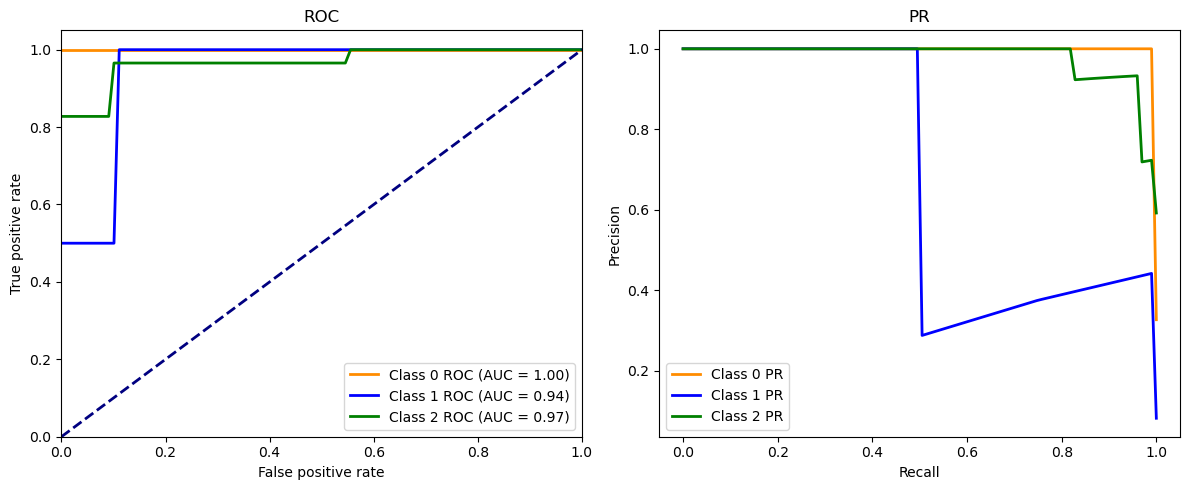

Epoch 56 model saved!
Model saved for epoch 56
Train Epoch: 57 [68/321 (20%)]	Loss: 0.565607, Accu: 100.00%
Train Epoch: 57 [136/321 (40%)]	Loss: 0.561183, Accu: 100.00%
Train Epoch: 57 [204/321 (60%)]	Loss: 0.567216, Accu: 100.00%
Train Epoch: 57 [272/321 (80%)]	Loss: 0.575879, Accu: 100.00%
Train Epoch: 57 [321/321 (100%)]	Loss: 0.565525, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.29      0.50      0.36         4
           2       0.92      0.83      0.87        29

    accuracy                           0.86        49
   macro avg       0.74      0.78      0.75        49
weighted avg       0.90      0.86      0.87        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


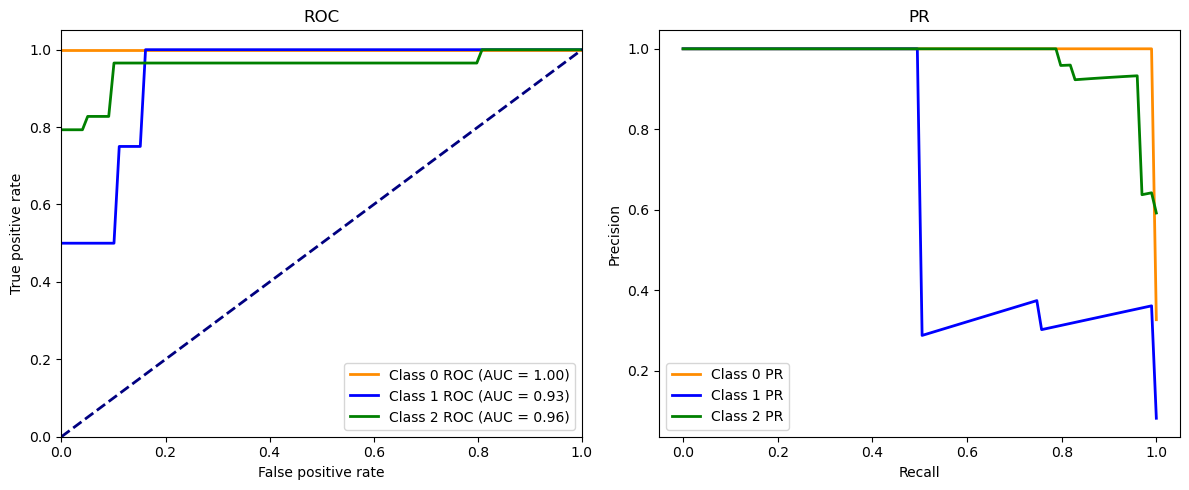

Epoch 57 model saved!
Model saved for epoch 57
Train Epoch: 58 [68/321 (20%)]	Loss: 0.560202, Accu: 100.00%
Train Epoch: 58 [136/321 (40%)]	Loss: 0.560174, Accu: 100.00%
Train Epoch: 58 [204/321 (60%)]	Loss: 0.559919, Accu: 100.00%
Train Epoch: 58 [272/321 (80%)]	Loss: 0.560125, Accu: 100.00%
Train Epoch: 58 [321/321 (100%)]	Loss: 0.579003, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.36      1.00      0.53         4
           2       1.00      0.79      0.88        29

    accuracy                           0.86        49
   macro avg       0.79      0.91      0.80        49
weighted avg       0.95      0.86      0.88        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


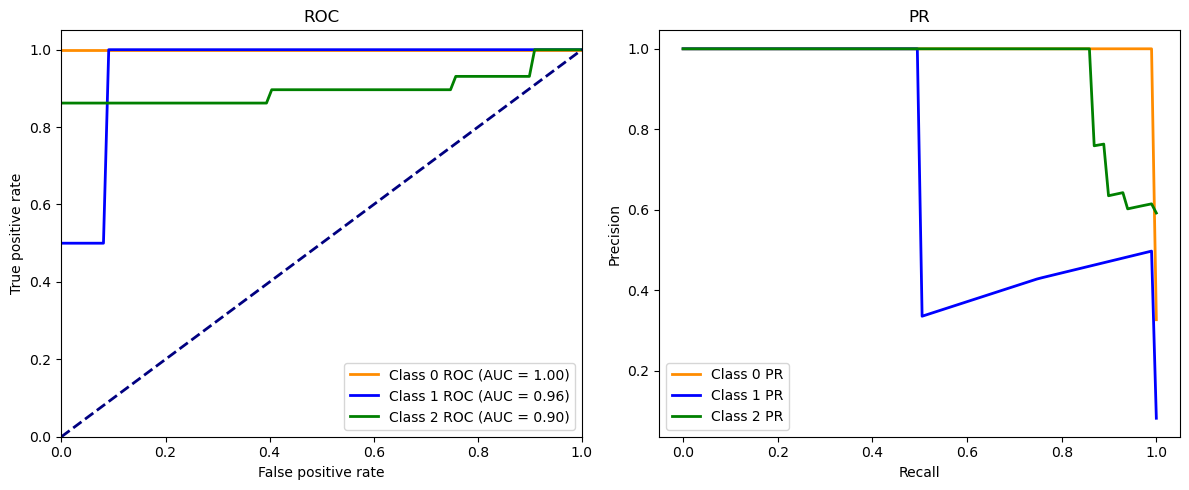

Epoch 58 model saved!
Model saved for epoch 58
Train Epoch: 59 [68/321 (20%)]	Loss: 0.562481, Accu: 100.00%
Train Epoch: 59 [136/321 (40%)]	Loss: 0.566440, Accu: 100.00%
Train Epoch: 59 [204/321 (60%)]	Loss: 0.565375, Accu: 100.00%
Train Epoch: 59 [272/321 (80%)]	Loss: 0.559424, Accu: 100.00%
Train Epoch: 59 [321/321 (100%)]	Loss: 0.563040, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.67      0.50      0.57         4
           2       0.93      0.97      0.95        29

    accuracy                           0.94        49
   macro avg       0.87      0.82      0.84        49
weighted avg       0.93      0.94      0.93        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


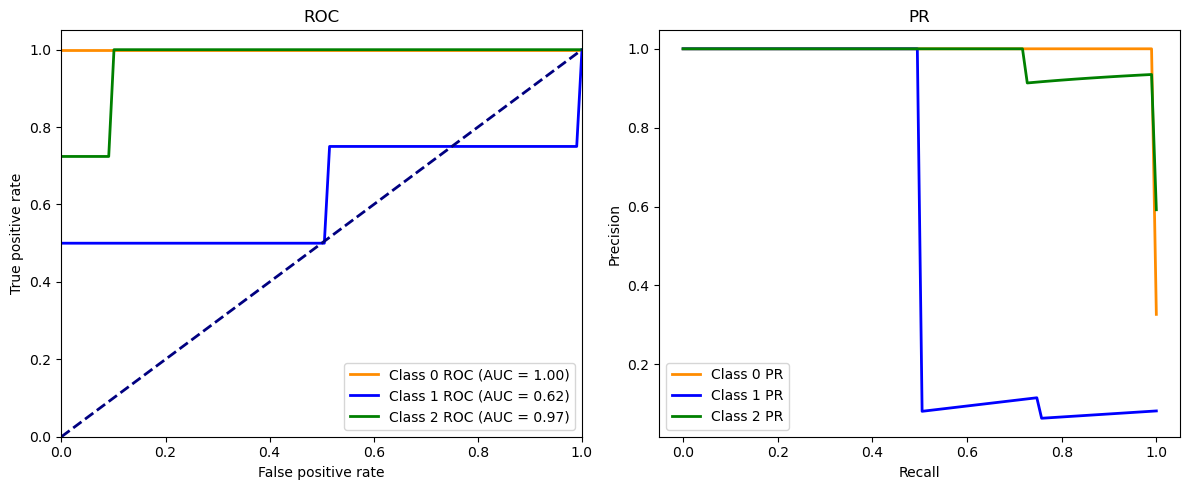

Epoch 59 model saved!
Model saved for epoch 59
Train Epoch: 60 [68/321 (20%)]	Loss: 0.563070, Accu: 100.00%
Train Epoch: 60 [136/321 (40%)]	Loss: 0.561518, Accu: 100.00%
Train Epoch: 60 [204/321 (60%)]	Loss: 0.559912, Accu: 100.00%
Train Epoch: 60 [272/321 (80%)]	Loss: 0.560125, Accu: 100.00%
Train Epoch: 60 [321/321 (100%)]	Loss: 0.571377, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.67      0.50      0.57         4
           2       0.93      0.97      0.95        29

    accuracy                           0.94        49
   macro avg       0.87      0.82      0.84        49
weighted avg       0.93      0.94      0.93        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


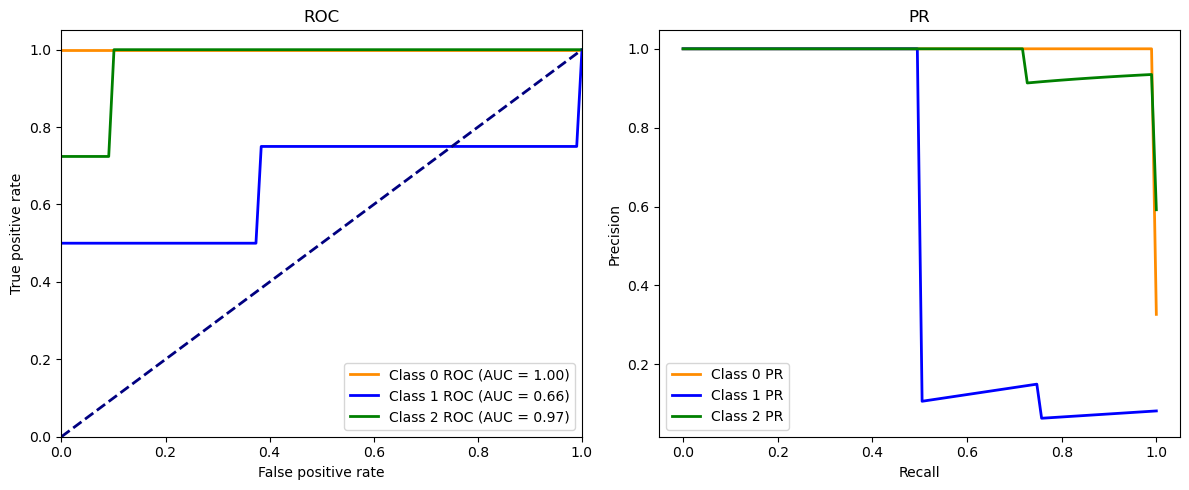

Epoch 60 model saved!
Model saved for epoch 60
Train Epoch: 61 [68/321 (20%)]	Loss: 0.562848, Accu: 100.00%
Train Epoch: 61 [136/321 (40%)]	Loss: 0.561180, Accu: 100.00%
Train Epoch: 61 [204/321 (60%)]	Loss: 0.561806, Accu: 100.00%
Train Epoch: 61 [272/321 (80%)]	Loss: 0.560968, Accu: 100.00%
Train Epoch: 61 [321/321 (100%)]	Loss: 0.558485, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


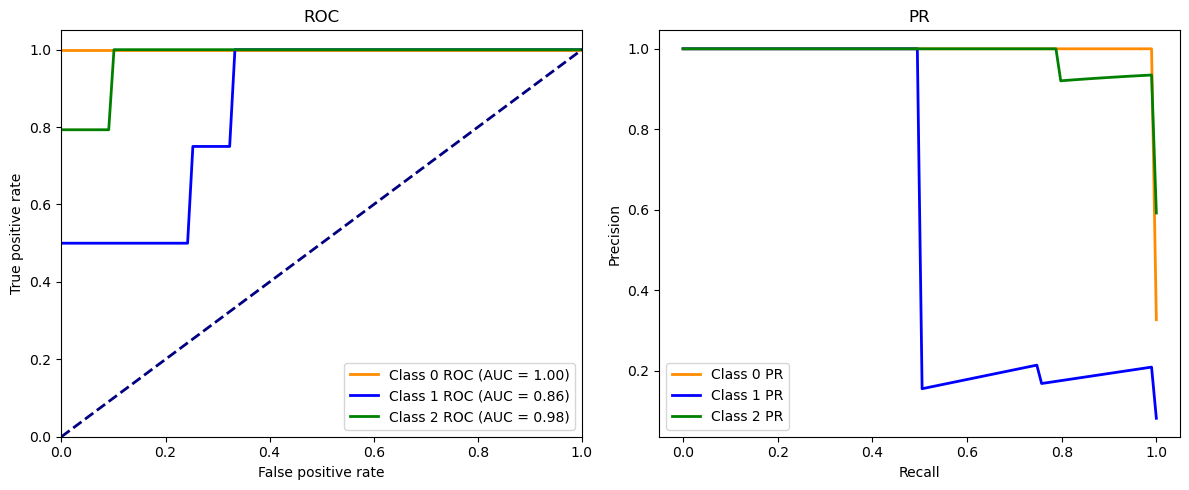

Epoch 61 model saved!
Model saved for epoch 61
Train Epoch: 62 [68/321 (20%)]	Loss: 0.561114, Accu: 100.00%
Train Epoch: 62 [136/321 (40%)]	Loss: 0.559104, Accu: 100.00%
Train Epoch: 62 [204/321 (60%)]	Loss: 0.570930, Accu: 100.00%
Train Epoch: 62 [272/321 (80%)]	Loss: 0.558589, Accu: 100.00%
Train Epoch: 62 [321/321 (100%)]	Loss: 0.572244, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.29      0.50      0.36         4
           2       0.93      0.86      0.89        29

    accuracy                           0.86        49
   macro avg       0.74      0.77      0.74        49
weighted avg       0.90      0.86      0.87        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


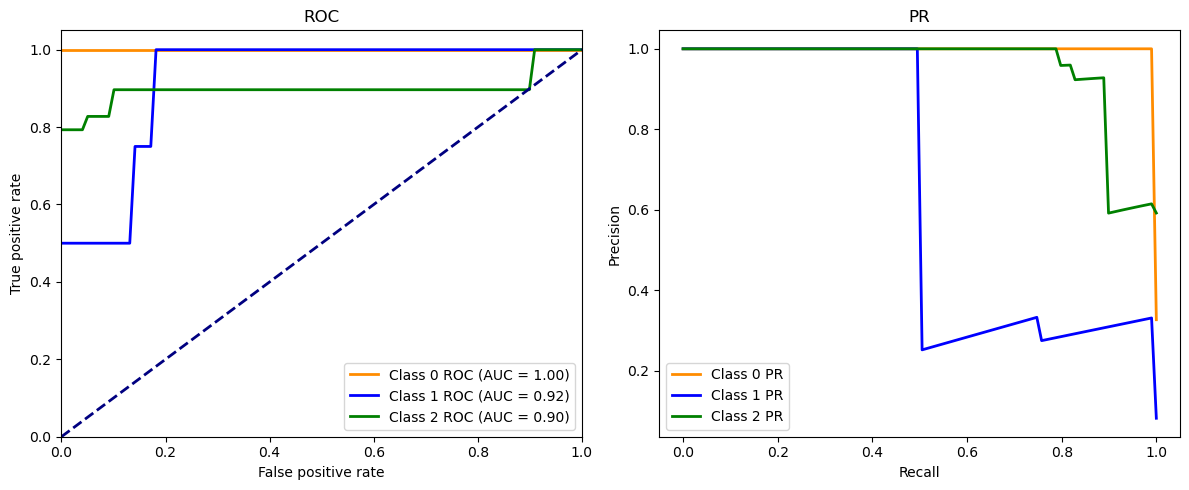

Epoch 62 model saved!
Model saved for epoch 62
Train Epoch: 63 [68/321 (20%)]	Loss: 0.562672, Accu: 100.00%
Train Epoch: 63 [136/321 (40%)]	Loss: 0.563485, Accu: 100.00%
Train Epoch: 63 [204/321 (60%)]	Loss: 0.560489, Accu: 100.00%
Train Epoch: 63 [272/321 (80%)]	Loss: 0.561375, Accu: 100.00%
Train Epoch: 63 [321/321 (100%)]	Loss: 0.564890, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.33      1.00      0.50         4
           2       1.00      0.76      0.86        29

    accuracy                           0.84        49
   macro avg       0.78      0.90      0.78        49
weighted avg       0.95      0.84      0.87        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


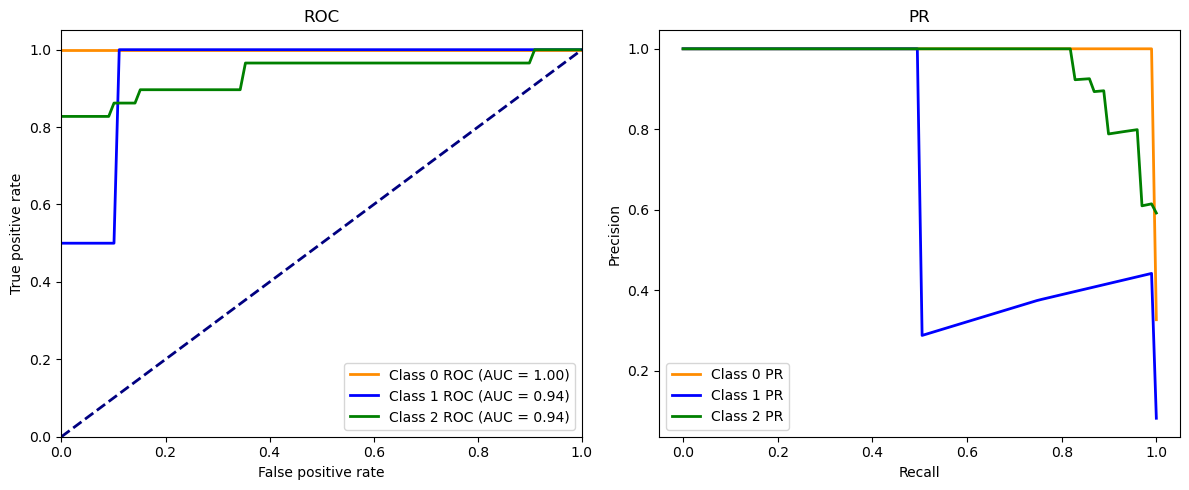

Epoch 63 model saved!
Model saved for epoch 63
Train Epoch: 64 [68/321 (20%)]	Loss: 0.560173, Accu: 100.00%
Train Epoch: 64 [136/321 (40%)]	Loss: 0.560315, Accu: 100.00%
Train Epoch: 64 [204/321 (60%)]	Loss: 0.562927, Accu: 100.00%
Train Epoch: 64 [272/321 (80%)]	Loss: 0.562613, Accu: 100.00%
Train Epoch: 64 [321/321 (100%)]	Loss: 0.561685, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.38      0.75      0.50         4
           2       0.96      0.83      0.89        29

    accuracy                           0.88        49
   macro avg       0.78      0.86      0.80        49
weighted avg       0.93      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


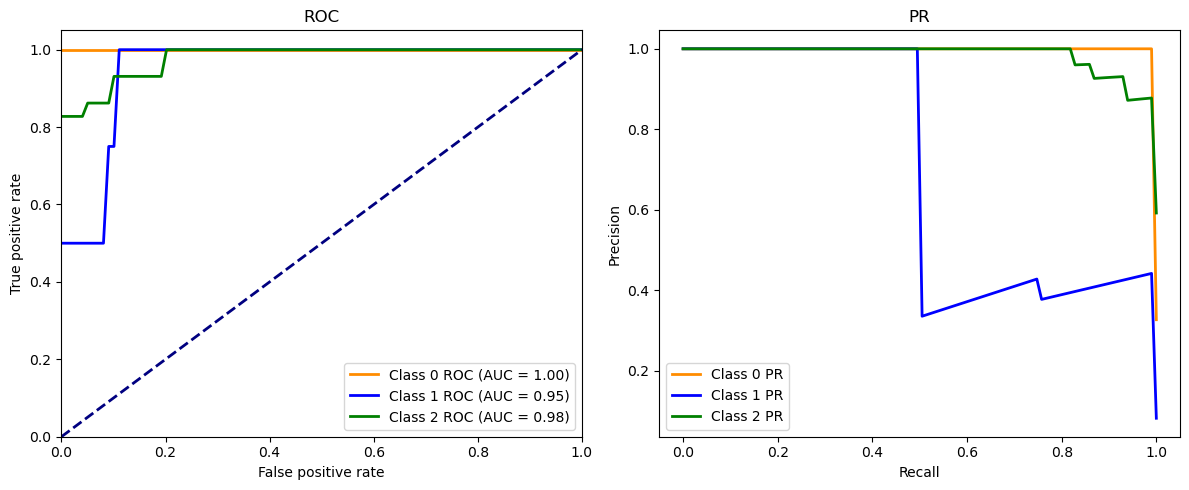

Epoch 64 model saved!
Model saved for epoch 64
Train Epoch: 65 [68/321 (20%)]	Loss: 0.560407, Accu: 100.00%
Train Epoch: 65 [136/321 (40%)]	Loss: 0.561133, Accu: 100.00%
Train Epoch: 65 [204/321 (60%)]	Loss: 0.560232, Accu: 100.00%
Train Epoch: 65 [272/321 (80%)]	Loss: 0.561384, Accu: 100.00%
Train Epoch: 65 [321/321 (100%)]	Loss: 0.560591, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.40      0.50      0.44         4
           2       0.93      0.90      0.91        29

    accuracy                           0.90        49
   macro avg       0.78      0.80      0.79        49
weighted avg       0.91      0.90      0.90        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


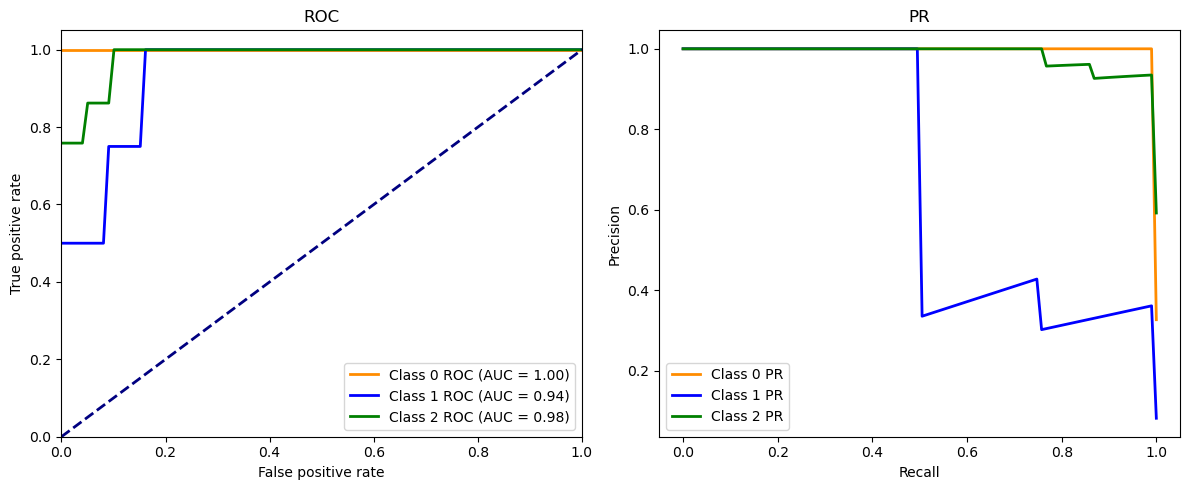

Epoch 65 model saved!
Model saved for epoch 65
Train Epoch: 66 [68/321 (20%)]	Loss: 0.558550, Accu: 100.00%
Train Epoch: 66 [136/321 (40%)]	Loss: 0.561409, Accu: 100.00%
Train Epoch: 66 [204/321 (60%)]	Loss: 0.558968, Accu: 100.00%
Train Epoch: 66 [272/321 (80%)]	Loss: 0.557554, Accu: 100.00%
Train Epoch: 66 [321/321 (100%)]	Loss: 0.581229, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.29      1.00      0.44         4
           2       1.00      0.69      0.82        29

    accuracy                           0.80        49
   macro avg       0.76      0.88      0.74        49
weighted avg       0.94      0.80      0.84        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


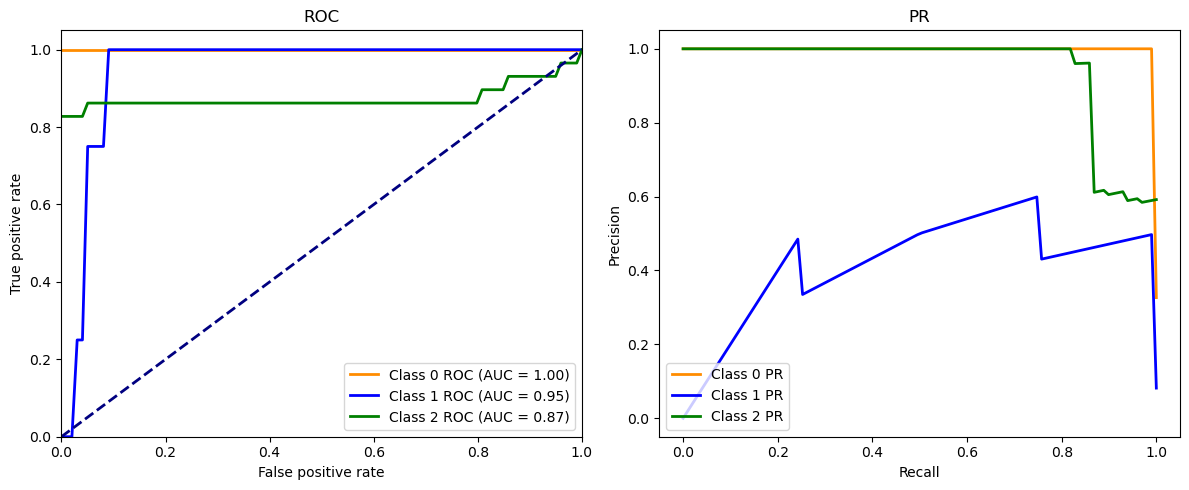

Epoch 66 model saved!
Model saved for epoch 66
Train Epoch: 67 [68/321 (20%)]	Loss: 0.560420, Accu: 100.00%
Train Epoch: 67 [136/321 (40%)]	Loss: 0.558731, Accu: 100.00%
Train Epoch: 67 [204/321 (60%)]	Loss: 0.567282, Accu: 100.00%
Train Epoch: 67 [272/321 (80%)]	Loss: 0.561564, Accu: 100.00%
Train Epoch: 67 [321/321 (100%)]	Loss: 0.575823, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.33      0.50      0.40         4
           2       0.93      0.86      0.89        29

    accuracy                           0.88        49
   macro avg       0.75      0.79      0.76        49
weighted avg       0.90      0.88      0.89        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


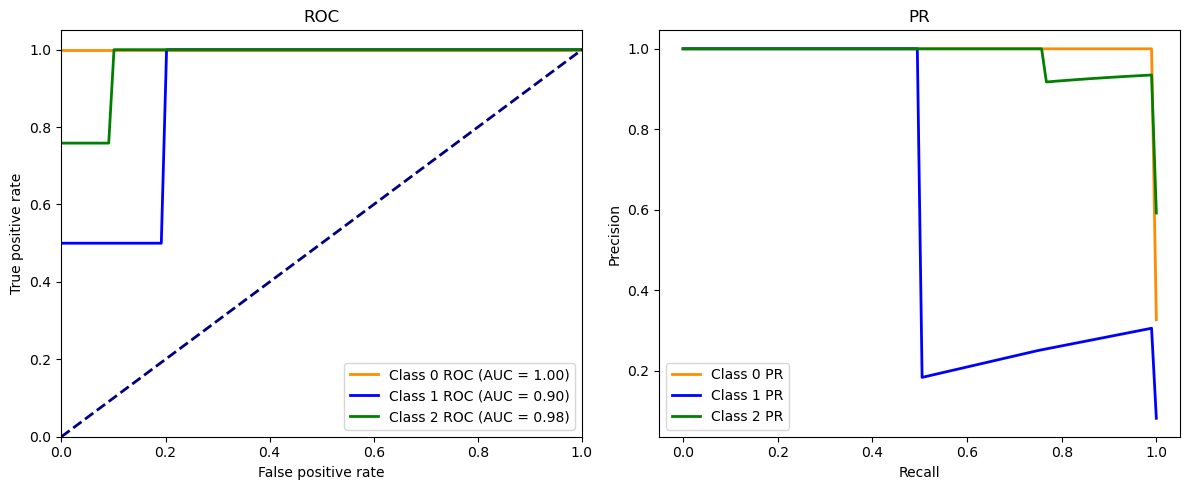

Epoch 67 model saved!
Model saved for epoch 67
Train Epoch: 68 [68/321 (20%)]	Loss: 0.556963, Accu: 100.00%
Train Epoch: 68 [136/321 (40%)]	Loss: 0.564647, Accu: 100.00%
Train Epoch: 68 [204/321 (60%)]	Loss: 0.560713, Accu: 100.00%
Train Epoch: 68 [272/321 (80%)]	Loss: 0.559739, Accu: 100.00%
Train Epoch: 68 [321/321 (100%)]	Loss: 0.725926, Accu: 86.67%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.25      1.00      0.40         4
           2       1.00      0.59      0.74        29

    accuracy                           0.76        49
   macro avg       0.75      0.86      0.71        49
weighted avg       0.94      0.76      0.80        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


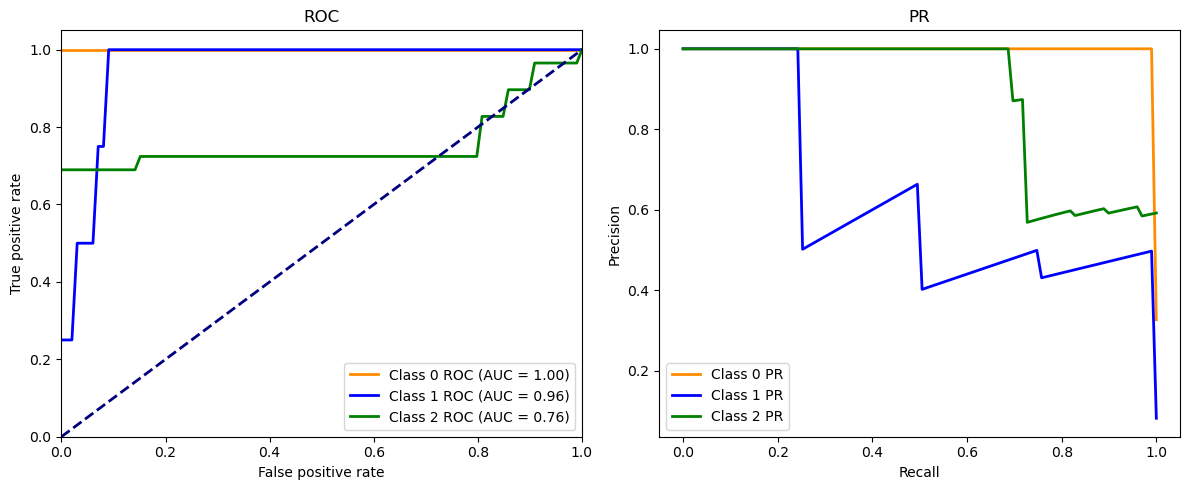

Epoch 68 model saved!
Model saved for epoch 68
Train Epoch: 69 [68/321 (20%)]	Loss: 0.558157, Accu: 100.00%
Train Epoch: 69 [136/321 (40%)]	Loss: 0.580873, Accu: 97.06%
Train Epoch: 69 [204/321 (60%)]	Loss: 0.562540, Accu: 100.00%
Train Epoch: 69 [272/321 (80%)]	Loss: 0.563200, Accu: 100.00%
Train Epoch: 69 [321/321 (100%)]	Loss: 0.566473, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.50      0.67         4
           2       0.94      1.00      0.97        29

    accuracy                           0.96        49
   macro avg       0.98      0.83      0.88        49
weighted avg       0.96      0.96      0.95        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


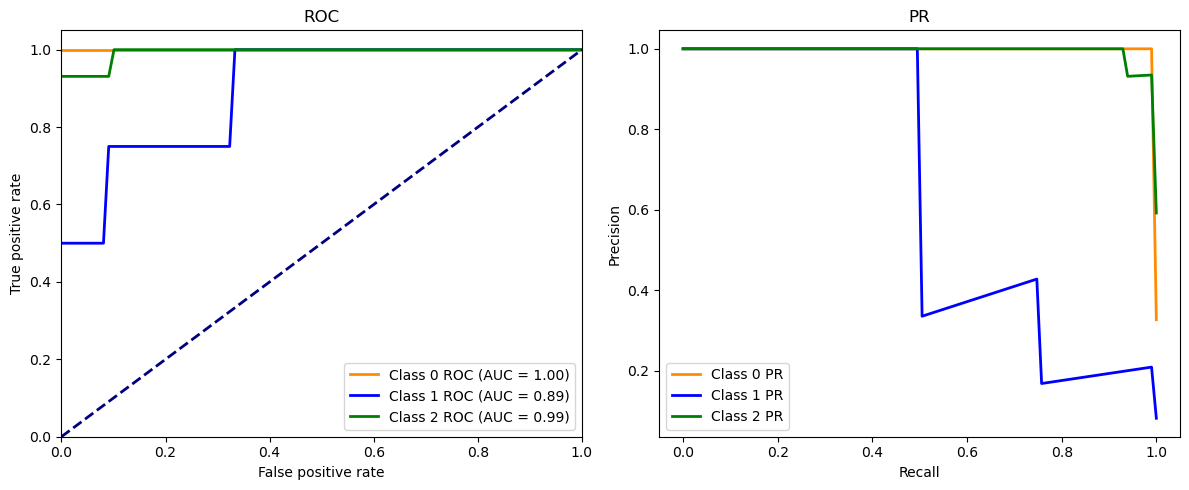

Epoch 69 model saved!
Model saved for epoch 69
Train Epoch: 70 [68/321 (20%)]	Loss: 0.562862, Accu: 100.00%
Train Epoch: 70 [136/321 (40%)]	Loss: 0.563635, Accu: 100.00%
Train Epoch: 70 [204/321 (60%)]	Loss: 0.561836, Accu: 100.00%
Train Epoch: 70 [272/321 (80%)]	Loss: 0.559368, Accu: 100.00%
Train Epoch: 70 [321/321 (100%)]	Loss: 0.558493, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.60      0.75      0.67         4
           2       0.96      0.93      0.95        29

    accuracy                           0.94        49
   macro avg       0.85      0.89      0.87        49
weighted avg       0.95      0.94      0.94        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


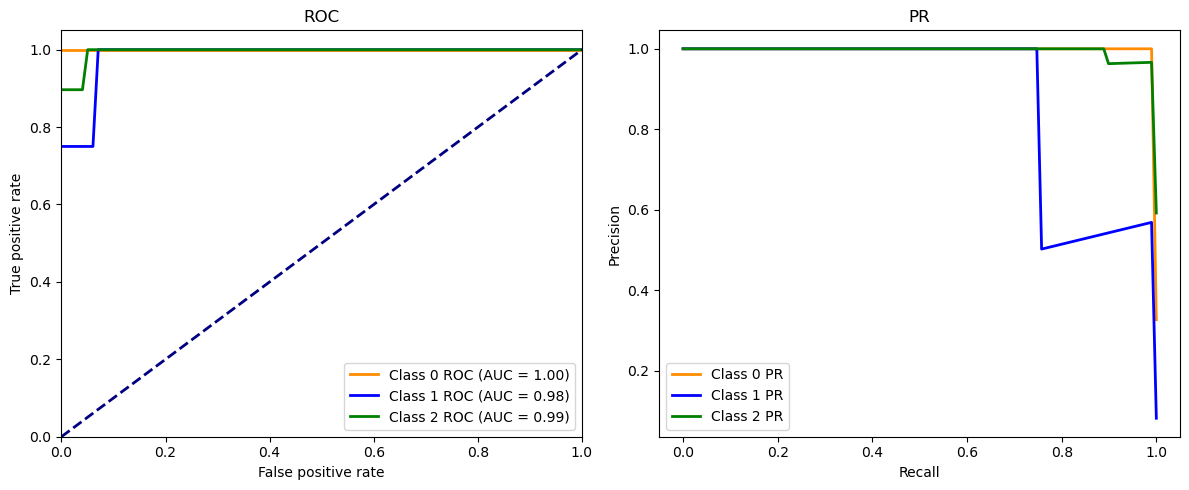

Epoch 70 model saved!
Model saved for epoch 70
Train Epoch: 71 [68/321 (20%)]	Loss: 0.560830, Accu: 100.00%
Train Epoch: 71 [136/321 (40%)]	Loss: 0.557872, Accu: 100.00%
Train Epoch: 71 [204/321 (60%)]	Loss: 0.563494, Accu: 100.00%
Train Epoch: 71 [272/321 (80%)]	Loss: 0.565245, Accu: 100.00%
Train Epoch: 71 [321/321 (100%)]	Loss: 0.560852, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.75      0.75      0.75         4
           2       0.97      0.97      0.97        29

    accuracy                           0.96        49
   macro avg       0.91      0.91      0.91        49
weighted avg       0.96      0.96      0.96        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


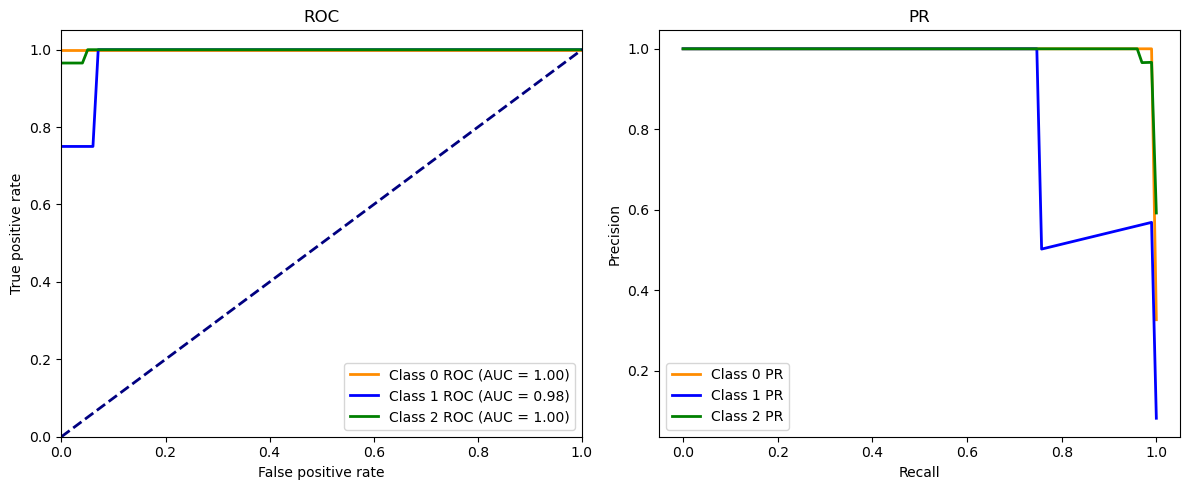

Epoch 71 model saved!
Model saved for epoch 71
Train Epoch: 72 [68/321 (20%)]	Loss: 0.558796, Accu: 100.00%
Train Epoch: 72 [136/321 (40%)]	Loss: 0.562752, Accu: 100.00%
Train Epoch: 72 [204/321 (60%)]	Loss: 0.559224, Accu: 100.00%
Train Epoch: 72 [272/321 (80%)]	Loss: 0.609673, Accu: 94.12%
Train Epoch: 72 [321/321 (100%)]	Loss: 0.563526, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.67      0.50      0.57         4
           2       0.94      1.00      0.97        29

    accuracy                           0.94        49
   macro avg       0.87      0.81      0.84        49
weighted avg       0.93      0.94      0.93        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


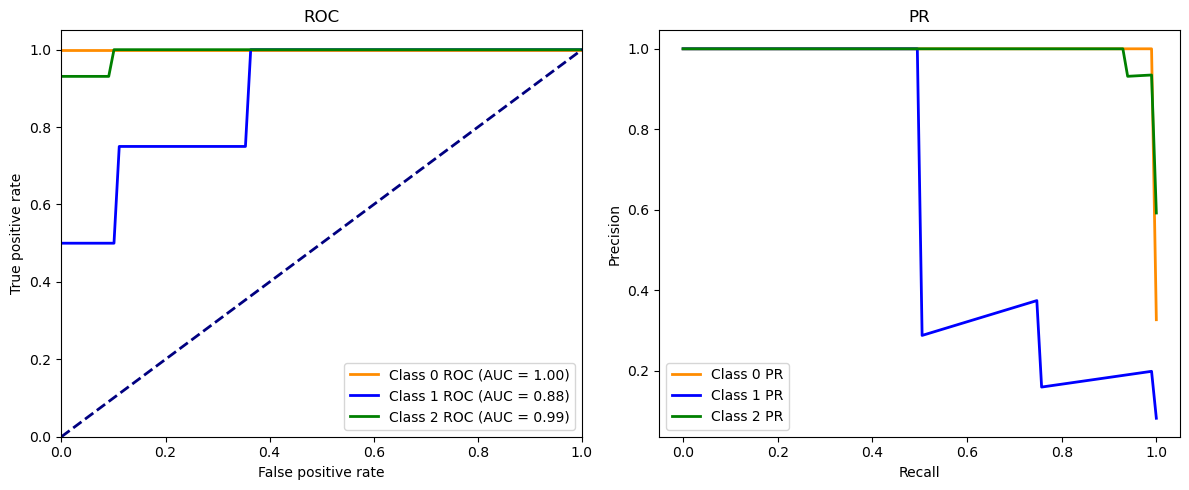

Epoch 72 model saved!
Model saved for epoch 72
Train Epoch: 73 [68/321 (20%)]	Loss: 0.559458, Accu: 100.00%
Train Epoch: 73 [136/321 (40%)]	Loss: 0.558590, Accu: 100.00%
Train Epoch: 73 [204/321 (60%)]	Loss: 0.641315, Accu: 88.24%
Train Epoch: 73 [272/321 (80%)]	Loss: 0.560549, Accu: 100.00%
Train Epoch: 73 [321/321 (100%)]	Loss: 0.571707, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.29      0.50      0.36         4
           2       0.93      0.90      0.91        29

    accuracy                           0.86        49
   macro avg       0.74      0.76      0.74        49
weighted avg       0.90      0.86      0.87        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


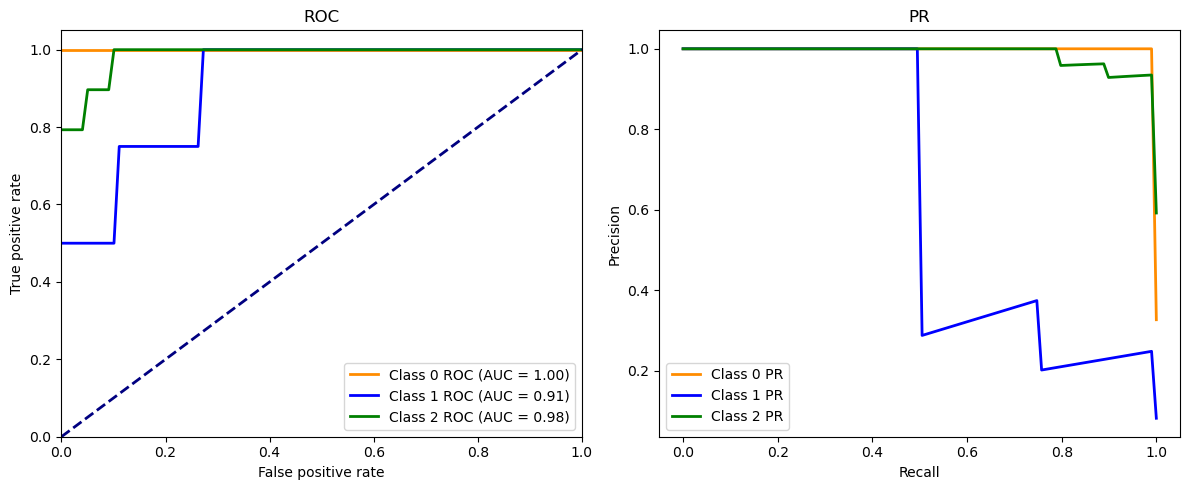

Epoch 73 model saved!
Model saved for epoch 73
Train Epoch: 74 [68/321 (20%)]	Loss: 0.558690, Accu: 100.00%
Train Epoch: 74 [136/321 (40%)]	Loss: 0.603419, Accu: 94.12%
Train Epoch: 74 [204/321 (60%)]	Loss: 0.562102, Accu: 100.00%
Train Epoch: 74 [272/321 (80%)]	Loss: 0.603474, Accu: 94.12%
Train Epoch: 74 [321/321 (100%)]	Loss: 0.622935, Accu: 93.33%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.40      0.50      0.44         4
           2       0.93      0.86      0.89        29

    accuracy                           0.88        49
   macro avg       0.76      0.79      0.77        49
weighted avg       0.89      0.88      0.88        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


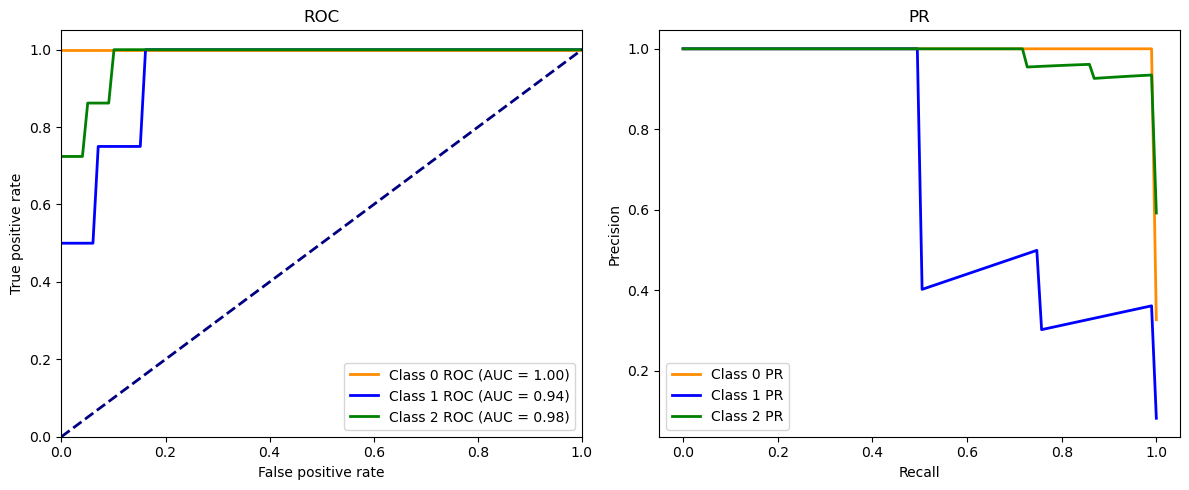

Epoch 74 model saved!
Model saved for epoch 74
Train Epoch: 75 [68/321 (20%)]	Loss: 0.584641, Accu: 97.06%
Train Epoch: 75 [136/321 (40%)]	Loss: 0.561106, Accu: 100.00%
Train Epoch: 75 [204/321 (60%)]	Loss: 0.593518, Accu: 97.06%
Train Epoch: 75 [272/321 (80%)]	Loss: 0.558966, Accu: 100.00%
Train Epoch: 75 [321/321 (100%)]	Loss: 0.561107, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.43      0.75      0.55         4
           2       0.96      0.90      0.93        29

    accuracy                           0.90        49
   macro avg       0.80      0.86      0.81        49
weighted avg       0.93      0.90      0.91        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


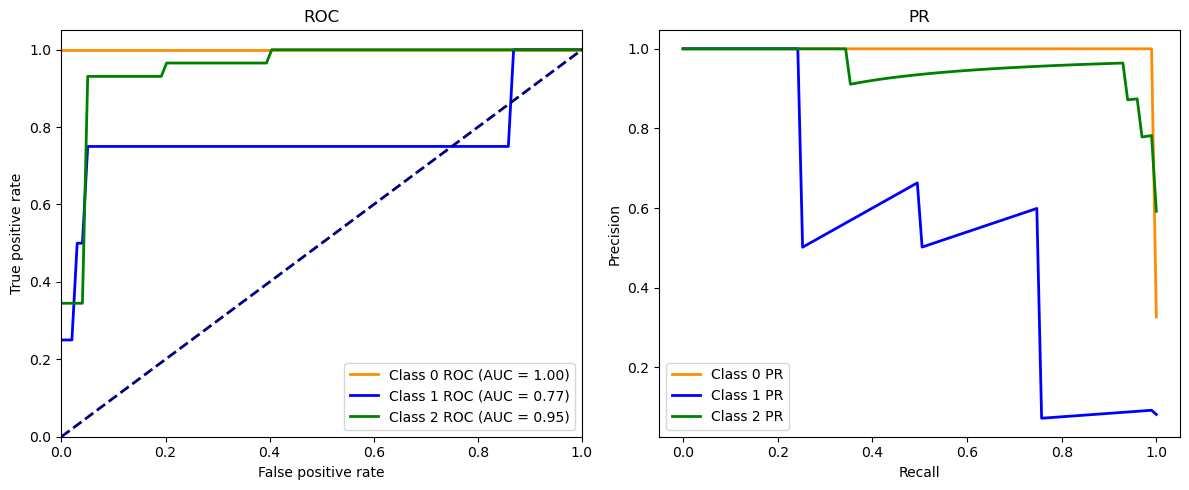

Epoch 75 model saved!
Model saved for epoch 75
Train Epoch: 76 [68/321 (20%)]	Loss: 0.559771, Accu: 100.00%
Train Epoch: 76 [136/321 (40%)]	Loss: 0.592118, Accu: 97.06%
Train Epoch: 76 [204/321 (60%)]	Loss: 0.558349, Accu: 100.00%
Train Epoch: 76 [272/321 (80%)]	Loss: 0.558522, Accu: 100.00%
Train Epoch: 76 [321/321 (100%)]	Loss: 0.754820, Accu: 80.00%
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        16
           1       0.60      0.75      0.67         4
           2       0.96      0.76      0.85        29

    accuracy                           0.84        49
   macro avg       0.77      0.84      0.79        49
weighted avg       0.86      0.84      0.84        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


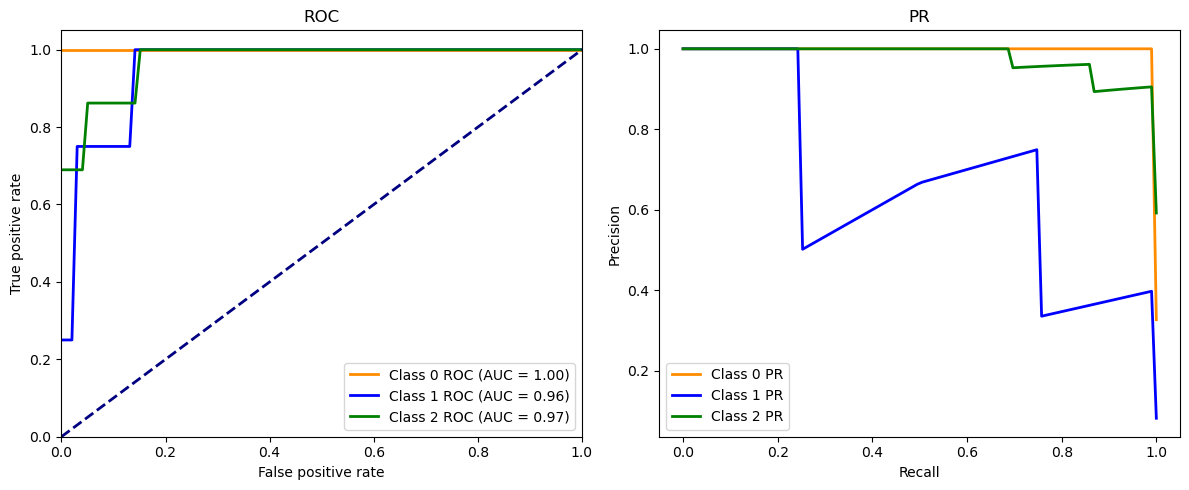

Epoch 76 model saved!
Model saved for epoch 76
Train Epoch: 77 [68/321 (20%)]	Loss: 0.557719, Accu: 100.00%
Train Epoch: 77 [136/321 (40%)]	Loss: 0.566756, Accu: 100.00%
Train Epoch: 77 [204/321 (60%)]	Loss: 0.560147, Accu: 100.00%
Train Epoch: 77 [272/321 (80%)]	Loss: 0.560948, Accu: 100.00%
Train Epoch: 77 [321/321 (100%)]	Loss: 0.599974, Accu: 93.33%
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.43      0.75      0.55         4
           2       0.96      0.93      0.95        29

    accuracy                           0.90        49
   macro avg       0.80      0.85      0.81        49
weighted avg       0.93      0.90      0.91        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


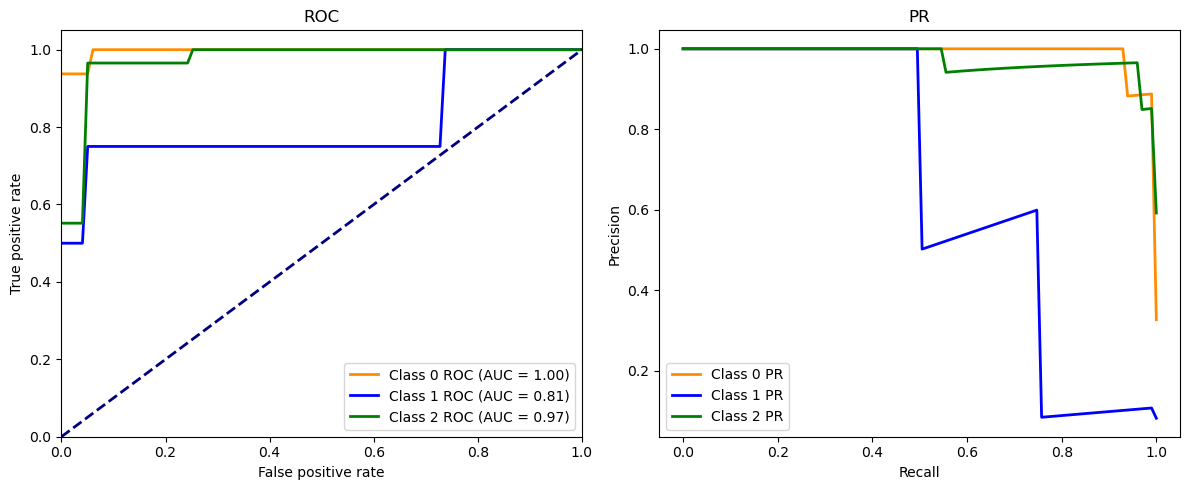

Epoch 77 model saved!
Model saved for epoch 77
Train Epoch: 78 [68/321 (20%)]	Loss: 0.565630, Accu: 100.00%
Train Epoch: 78 [136/321 (40%)]	Loss: 0.563129, Accu: 100.00%
Train Epoch: 78 [204/321 (60%)]	Loss: 0.560933, Accu: 100.00%
Train Epoch: 78 [272/321 (80%)]	Loss: 0.567115, Accu: 100.00%
Train Epoch: 78 [321/321 (100%)]	Loss: 0.557906, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.50      0.67         4
           2       0.94      1.00      0.97        29

    accuracy                           0.96        49
   macro avg       0.98      0.83      0.88        49
weighted avg       0.96      0.96      0.95        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


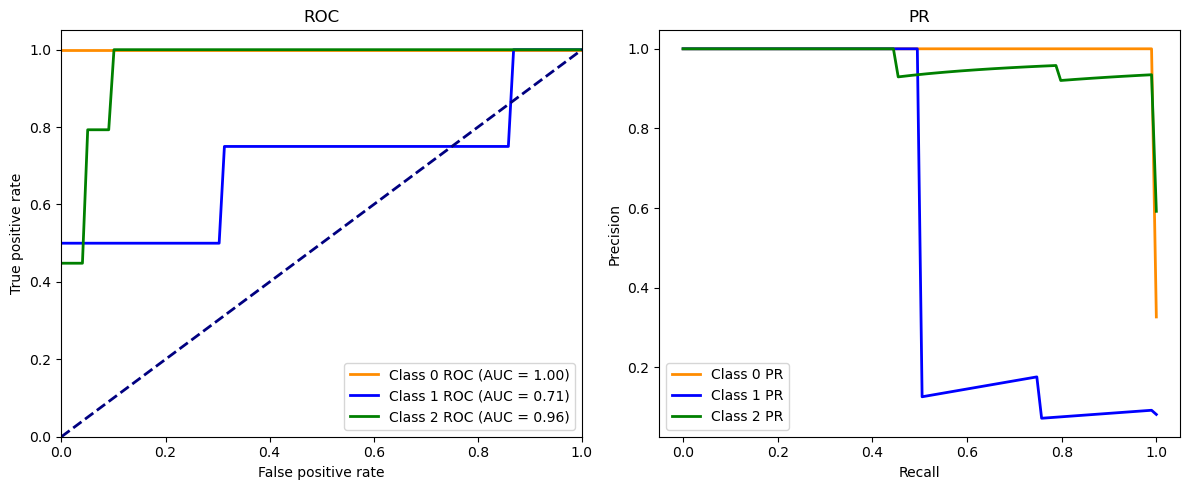

Epoch 78 model saved!
Model saved for epoch 78
Train Epoch: 79 [68/321 (20%)]	Loss: 0.562088, Accu: 100.00%
Train Epoch: 79 [136/321 (40%)]	Loss: 0.615994, Accu: 94.12%
Train Epoch: 79 [204/321 (60%)]	Loss: 0.566904, Accu: 100.00%
Train Epoch: 79 [272/321 (80%)]	Loss: 0.563995, Accu: 100.00%
Train Epoch: 79 [321/321 (100%)]	Loss: 0.804955, Accu: 73.33%
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       0.29      0.50      0.36         4
           2       0.91      0.72      0.81        29

    accuracy                           0.80        49
   macro avg       0.68      0.74      0.70        49
weighted avg       0.84      0.80      0.81        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


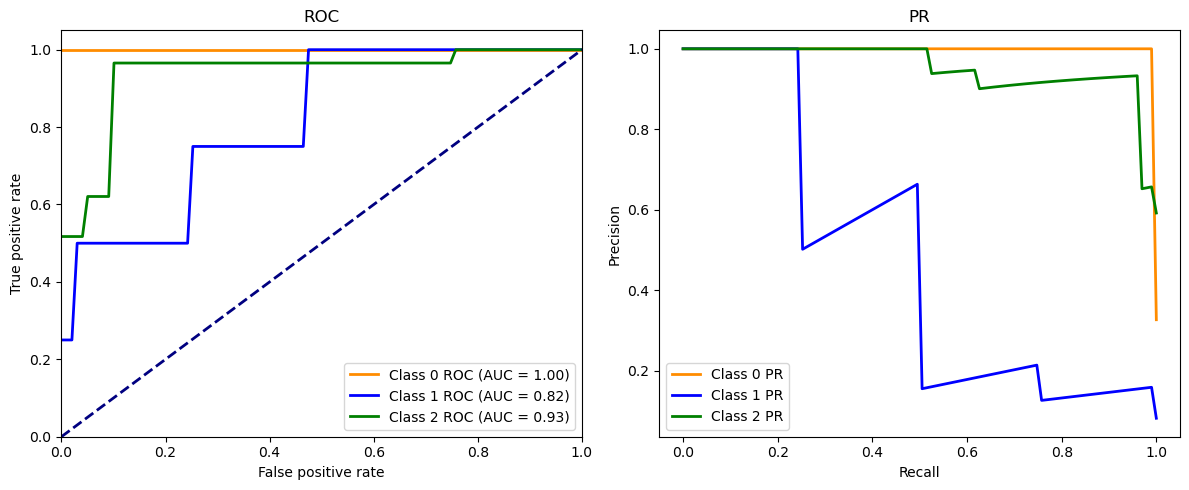

Epoch 79 model saved!
Model saved for epoch 79
Train Epoch: 80 [68/321 (20%)]	Loss: 0.561922, Accu: 100.00%
Train Epoch: 80 [136/321 (40%)]	Loss: 0.560332, Accu: 100.00%
Train Epoch: 80 [204/321 (60%)]	Loss: 0.576716, Accu: 100.00%
Train Epoch: 80 [272/321 (80%)]	Loss: 0.604533, Accu: 94.12%
Train Epoch: 80 [321/321 (100%)]	Loss: 0.561311, Accu: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.50      0.67         4
           2       0.94      1.00      0.97        29

    accuracy                           0.96        49
   macro avg       0.98      0.83      0.88        49
weighted avg       0.96      0.96      0.95        49

y_true_bin shape: (49, 3)
y_score shape: (49, 3)


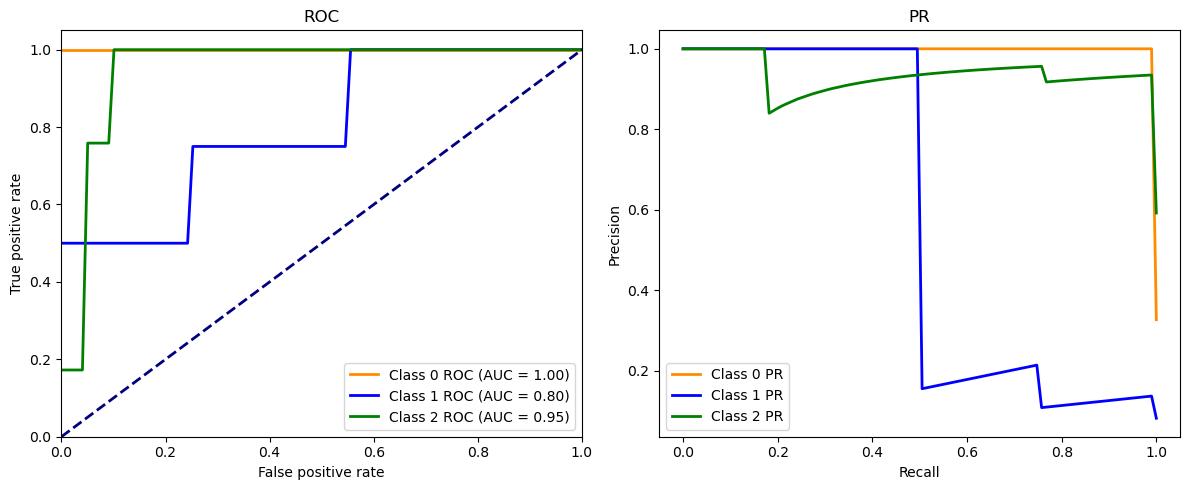

Epoch 80 model saved!
Model saved for epoch 80


In [15]:
import warnings
warnings.filterwarnings("ignore")
os.makedirs('./saved_models', exist_ok=True)

for epoch in range(epochs):
    train_losses, train_scores = train(log_interval, [cnn_encoder, rnn_decoder, Transformer], device, train_loader, optimizer, epoch)
    epoch_test_loss, epoch_test_score = validation([cnn_encoder, rnn_decoder, Transformer], device, optimizer, valid_loader)

    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    epoch_test_losses.append(epoch_test_loss)
    epoch_test_scores.append(epoch_test_score)

    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)
    np.save('./CRNN_epoch_training_losses.npy', A)
    np.save('./CRNN_epoch_training_scores.npy', B)
    np.save('./CRNN_epoch_test_loss.npy', C)
    np.save('./CRNN_epoch_test_score.npy', D)
    
    torch.save({
        'epoch': epoch,
        'cnn_encoder_state_dict': cnn_encoder.state_dict(),
        'rnn_decoder_state_dict': rnn_decoder.state_dict(),
        'transformer_state_dict': Transformer.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, f'./saved_models/model_epoch_{epoch+1}.pth')

    print(f"Model saved for epoch {epoch+1}")